In [ ]:
# Import libraries

import sys
import re
import requests
import json
import asyncio
import nest_asyncio
import aiohttp
import time
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Suppress unnecessary Shapely warning
warnings.filterwarnings('ignore',
                        '.*Shapely GEOS version.*')

from aiohttp import ClientSession
from requests import request, Session
from itertools import product, repeat
import os
from dotenv import load_dotenv
from os import getenv
from threading import Thread
import time
import inspect
import pandas as pd
import geopandas as gp
import shapely
import pygeos
from functools import reduce
from pandas.plotting import lag_plot
import pickle
import numpy as np
import seaborn as sns
import datetime as dt
import copy
import math
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from multiprocess import Process, Pool

from sklearn.linear_model import LinearRegression, Ridge

# Set up Pandas defaults
pd.options.display.float_format = '{:.6f}'.format
pd.set_option("display.max_columns", None)



### Define script variables

In [ ]:
# Get the beginning year for job data. If it is past June,
# just analyze this year's job growth data from the beginning
# of the year to the present. If it is
# before June, analyze data from the beginning of last
# year to the present. Note below we test to see if
# it is after July, because if it is, we should have June's
# data at that point.
now = datetime.today()
if now.month > 7:
    begin_job_year = now.year
else:
    begin_job_year = now.year - 1

# Get the most recent year of census data
def get_end_year():
    """
    The ACS typically releases the previous year's
    data on Dec 15th. So we will determine the end_year
    based on the current date. For example, if it's
    August 8th, 2023, that is before December 15th, 2023.
    So in this case, we will make the end year 2021, as
    the 2022 data will likely be released by Dec 15th,
    2023. Otherwise, if we are accessing this data between
    Dec 15th and the end of the current year, we will take
    the current year and subtract by 1, as the previous
    year's data is likely released.
    """

    # Get today
    now = datetime.today()

    # get this year
    this_year = now.year

    # Make Dec 15th
    dec_15 = datetime(this_year, 12, 15)

    # If it's before Dec 15th of this year,
    # the end_year will be the current year
    # subtracted by 2 (see function docstring)
    if now < dec_15:
        end_year = this_year - 2
    else:
        end_year = this_year - 1

    return end_year

# Get the census end year
census_end_year = get_end_year()

# Census beginning year is end_year - 5
census_begin_year = census_end_year - 5

In [ ]:
### Read in state and MSA codes

# Read in state FIPS codes
state_fips = pd.read_csv(
    "datasets/helper_datasets/state_FIPS_codes.csv",
    dtype={'state_code':str}
)

# Read in MSA state codes
msa_state_fips = pd.read_csv(
    "datasets/helper_datasets/msa_and_state_codes.csv",
    dtype={'FIPS State Code':str, 'CBSA Code':str}
)

# Get only necessary columns
msa_state_fips = msa_state_fips[['CBSA Code','CBSA Title','FIPS State Code']]

# Rename column
msa_state_fips.rename(columns={'FIPS State Code':'state_code'}, inplace=True)

msa_state_fips.head(3)

### Define Helper Functions

In [ ]:
# Define helper function to create directory
def create_folder(the_path):
    if not os.path.isdir(the_path):
        os.mkdir(the_path)

# Turn into datetime format
def turn_df_into_datetime(dataframe):
    """
    Turns a dataframe created by the API functions
    into a tidy datetime format.
    """
    # Make a copy
    df = dataframe.copy()
    
    # Set index
    df = df.set_index(['msa_name','msa_code'])
    
    # Stack
    df = df.stack()
    
    # Turn into dataframe
    df = pd.DataFrame(df).reset_index()
    
    # Rename the post-stacked columns
    df.rename(columns={'level_2':'year', 0:'value'}, inplace=True)
    
    # Make year column integer
    df['year'] = df['year'].astype(int)
    
    # Make datetime column
    df['date'] = pd.to_datetime(df['year'], format='%Y')
    
    return df


In [ ]:
### Helper function for Census Datasets
def prep_census_datasets(dataframe, msa_state_fips=msa_state_fips):
    """
    This function preps the census datasets into
    the same format as the BLS job datasets
    for future city comparisons using both
    Census and BLS datasets.
    """
    # Make copy
    df = dataframe.copy()
    
    # Turn into tidy datetime
    df = turn_df_into_datetime(df)

    # Add MSA state code
    df = df.merge(msa_state_fips, 
                    how='left', 
                    left_on=['msa_name','msa_code'],
                    right_on=['CBSA Title','CBSA Code'])

    # Drop unnecessary columns
    df.drop(columns=['CBSA Title','CBSA Code'], inplace=True)

    # Replace NECTA Division
    df['msa_name'] = df['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
    df['msa_name'] = df['msa_name'].apply(lambda x: x.replace(" NECTA",""))
    
    return df

In [ ]:
### Define normalizing function
def normalize_column(
    series, mean_standardize=False, 
    min_max_standardized=False):
    """
    Normalizes a column's values.
    
    Arguments
    -----------
        series (Series): A pandas Series, which can
            simply be passed as a column of a
            DataFrame.
            
    Returns
    -----------
        series (Series): A normalized Series, which can
            be set to a column in a DataFrame.
    """
    # Make a copy
    sr = series.copy()
    
    # Standardize around the mean or by min-max
    if mean_standardize:
        # Make normalized column
        sr = (sr - sr.mean())/sr.std()
    elif min_max_standardized:
        # Make normalized column
        sr = (sr - sr.min())/(sr.max()-sr.min())
    else:
        raise ValueError("Please specify how to normalize.")
    
    return sr

### Analyze MSA Growth

In [ ]:
# Read in most recent job data
jobs = pd.read_csv('datasets/bls/raw/most_recent_bls_data.csv',
                   dtype={'msa_code':str, 'state_code':str})

# Make sure the date column is in datetime format
jobs['date'] = pd.to_datetime(jobs['date'])

# Replace NECTA Division
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA",""))

jobs

### Read in: 

1. Median Rent
2. Median Price
3. Rent-to-Price ratio per MSA

In [ ]:
# Read in median rent
median_rent = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/median_rent_msa.csv",
    dtype={'msa_code':str}
)

# Run prep function to get into correct format
median_rent = prep_census_datasets(median_rent)

median_rent.head(3)


In [ ]:
# Read in median price
median_price = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/median_price_msa.csv",
    dtype={'msa_code':str}
)

# Run prep function to get into correct format
median_price = prep_census_datasets(median_price)

median_price.head(3)

In [ ]:
# Read in rent_to_price
rent_to_price = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/rent_to_price_ratio_msa.csv",
    dtype={'msa_code':str}
)

# Run prep function to get into correct format
rent_to_price = prep_census_datasets(rent_to_price)

rent_to_price.head(3)

In [ ]:
# Read in median income
median_income = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/median_income_msa.csv",
    dtype={'msa_code':str}
)

# Run prep function to get into correct format
median_income = prep_census_datasets(median_income)

median_income.head(3)

### Define Graphing Functions

In [ ]:
# Define helper function that runs linear regression
def run_lr(df, column):
    """
    Run linear regression on time-series data 
    and return the coefficient and intercept.
    
    Arguments
    -----------
        df (DataFrame): A dataframe that contains the
            target column and an 'ordinal_date' column
            that was created by a time-series column in 
            the format of "%Y-%m-%d" and making it ordinal,
            such as running the code below in some other 
            step. 
            
            EXAMPLE...
            # Create ordinal column
            df['ordinal_date'] = df['date'].map(
                datetime.toordinal)
                
        column (str): The name of the target column.
            
    Returns
    -----------
        coef (float): The coefficient of the linear
            equation calculated.
        
        intercept (float): The y-intercept of the linear
            equation calculated.
    
    """
    # Run linear regression
    normal_lr = LinearRegression()
    X = df[['ordinal_date']]
    y = df[column]
    normal_lr.fit(X, y)
    coef = normal_lr.coef_[0]
    intercept = normal_lr.intercept_

    # Return lr coefficient
    return coef, intercept

### Define plotting function

In [ ]:
# Loop through all cities, sort by coefficient, plot top 10
def plot_top_10_cities(
    ranked_cities,
    plot_jobs=False,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    begin_year_1=2013,
    plot_all=False,
):
    """
    Plots the top cities for a given demographic. Top cities
    are chosen based on their trend. This function can also 
    find the top cities based on multiple datasets.
    
    Arguments
    ----------
        ranked_cities (DataFrame): A dataframe of cities
            already ranked by various demographics. The
            dataframe returned by the "make_ranking()"
            function is the ideal dataframe to pass
            to this function.
            
        plot_jobs (True/False): If Ture, plot jobs. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_rent (True/False): If Ture, plot rent. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_income (True/False): If Ture, plot income. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_price (True/False): If Ture, plot price. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_units (True/False): If Ture, plot units. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_rent_to_price (True/False): If Ture, plot rent-ro-price
            ratio. Only one demographic can be plotted at a time, 
            so if you'd like to plot a different demographic, 
            this must be set to False.
        
        plot_jobs_per_unit (True/False): If Ture, plot jobs-per-unit. 
            Only one demographic can be plotted at a time, so if 
            you'd like to plot a different demographic, this must 
            be set to False.
            
        begin_year_1 (int): The year you'd like the
            analysis to start.
            
        plot_all (True/False): True if you want to plot every
            city in the dataframe (slow). False if you only want
            to plot the top 5 (fast).
    
    Returns
    ----------
        coef_df (DataFrame): A dataframe with the rankings
            of each city, from "best to worst."
    
    """
    # Make a copy of the ranked cities
    ranked = ranked_cities.copy()
    
    # If not plotting all cities (and just top 10),
    # keep only the top 10 cities in the dataframe
    if not plot_all:
        ranked = ranked.head(10)
    
    ### Call in the dataset we will be graphing from
    
    # If plotting job growth
    if plot_jobs:
        
        # Set demographic title for graphs
        demographic_1="Job"
        
        # Read in most recent job data
        dataframe_1 = pd.read_csv('datasets/bls/raw/most_recent_bls_data.csv',
                           dtype={'msa_code':str, 'state_code':str})

        # Make sure the date column is in datetime format
        dataframe_1['date'] = pd.to_datetime(dataframe_1['date'])

        # Replace NECTA Division
        dataframe_1['msa_name'] = dataframe_1['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
        dataframe_1['msa_name'] = dataframe_1['msa_name'].apply(lambda x: x.replace(" NECTA",""))
    
    # If plotting rent growth
    elif plot_rent:
        
        # Set demographic title for graphs
        demographic_1="Median Rent"
        
        # Read in data
        dataframe_1 = pd.read_csv(
            "datasets/cleaned_census_api_files/msa_data/median_rent_msa.csv",
            dtype={'msa_code':str})

        # Run prep function to get into correct format
        dataframe_1 = prep_census_datasets(dataframe_1)
        
    # If plotting income growth
    elif plot_income:
        
        # Set demographic title for graphs
        demographic_1="Median Income"
        
        # Read in data
        dataframe_1 = pd.read_csv(
            "datasets/cleaned_census_api_files/msa_data/median_income_msa.csv",
            dtype={'msa_code':str})

        # Run prep function to get into correct format
        dataframe_1 = prep_census_datasets(dataframe_1)
        
    # If plotting price growth
    elif plot_price:
        
        # Set demographic title for graphs
        demographic_1="Median Price"
        
        # Read in data
        dataframe_1 = pd.read_csv(
            "datasets/cleaned_census_api_files/msa_data/median_price_msa.csv",
            dtype={'msa_code':str})

        # Run prep function to get into correct format
        dataframe_1 = prep_census_datasets(dataframe_1)
        
    # If plotting unit growth
    elif plot_units:
        
        # Set demographic title for graphs
        demographic_1="Total Units"
        
        # Read in data
        dataframe_1 = pd.read_csv(
            "datasets/cleaned_census_api_files/msa_data/total_units_msa.csv",
            dtype={'msa_code':str})

        # Run prep function to get into correct format
        dataframe_1 = prep_census_datasets(dataframe_1)
        
    # If plotting rent-to-price
    elif plot_rent_to_price:
        
        # Set demographic title for graphs
        demographic_1="Rent-to-Price"
        
        # Read in data
        dataframe_1 = pd.read_csv(
            "datasets/cleaned_census_api_files/msa_data/rent_to_price_ratio_msa.csv",
            dtype={'msa_code':str})

        # Run prep function to get into correct format
        dataframe_1 = prep_census_datasets(dataframe_1)
        
    # If plotting jobs-per-unit
    elif plot_jobs_per_unit:
        
        # Set demographic title for graphs
        demographic_1="Jobs per Unit"
        
        # Read in data
        dataframe_1 = pd.read_csv(
            "datasets/cleaned_census_api_files/msa_data/jobs_per_unit_msa.csv",
            dtype={'msa_code':str})

        # Run prep function to get into correct format
        dataframe_1 = prep_census_datasets(dataframe_1)
        
    # Otherwise, print error statement
    else:
        print("Please specify a demographic to plot by setting it to True, and leaving the others set to False.")
        raise Exception("SPECIFY A DEMOGRAPHIC TO PLOT.")
    
    # Make copy
    main_df = dataframe_1.copy()
            
    # Create main variable to use for the rest of the script
    column = 'value'

    # Create dictionary to store filtered dataframes
    filtered_dict = {}

    # Set y_lim list to find max and min
    y_lim_list_trend = []
    y_min_list_trend = [0]
    y_lim_list_pct = []
    y_min_list_pct = [0]
    
    # Loop through all cities in the ranked dataframe
    for city in ranked['msa_name'].dropna().unique():

        # Isolate just that city
        df = main_df[main_df['msa_name']==city].copy()
        
        # Sort by date
        df = df.sort_values('date')
                
        # Create difference column
        df['value_change'] = df['value'].diff()
        
        # Create pct_change column
        df['percent_change'] = df['value'].pct_change()
        
        # Filter by beginning year
        df = df[df['year']>=begin_year_1].reset_index(drop=True)
                
        # If an MSA's most recent year is after the beginning
        # year, remove it from the graphs. For example, if we want to
        # view the growth of all cities since 2016, but Prescott Valley
        # only has data starting at 2019, this may skew the data.
        if df['year'].iloc[0] != begin_year_1:
            print(f"Dropping {city}, it's dataframe has a smaller window.")
            continue
                
        # Remove NaN values
        df = df[df['percent_change'].notna()]
        
        # Isolate date and value columns
        df = df[[
            'date', 'value', 'value_change',
            'percent_change']].reset_index(drop=True)
        
        # Add this dataframe's y_lim to list
        y_lim_list_trend.append(df['value'].max())
        y_min_list_trend.append(df['value'].min())
        y_lim_list_pct.append(df['percent_change'].max())
        y_min_list_pct.append(df['percent_change'].min())
        
        # get next months's datetime
        next_year = df['date'].iloc[-1] + relativedelta(months=1)
        
        # Create ordinal column
        df['ordinal_date'] = df['date'].map(datetime.toordinal)
        
        # Run linear regression and get the trend's coefficient
        coef_value, intercept_value = run_lr(df, column='value')
        coef_pct, intercept_pct = run_lr(df, column='percent_change')
        
        # Create next year's date
        df.loc[len(df.index)] = [
            next_year, np.nan, np.nan, 
            np.nan, datetime.toordinal(next_year)]
        
        # Create averages column
        the_average_pct = df['percent_change'].mean()
        df['average_pct'] = the_average_pct
        the_average_value = df['value_change'].mean()
        df['average_value'] = the_average_value

        # Fill in with linear regression values.
        # Also add highest trend value to lim_list.
        df['value_trend'] = df['ordinal_date']*coef_value + intercept_value
        df['percent_change_trend'] = df['ordinal_date']*coef_pct + intercept_pct

        # Also add highest trend value to lim_list
        y_lim_list_trend.append(df['value_trend'].max())
        y_lim_list_pct.append(df['percent_change_trend'].max())

        # Get the y_lim
        y_lim_trend = max(y_lim_list_trend) * 1.1
        y_min_trend = min(y_min_list_trend)
        y_lim_pct = max(y_lim_list_pct) * 1.1
        y_min_pct = min(y_min_list_pct)
            
        # Save filtered data to dictionary
        filtered_dict[city] = df
    
    # Loop through each city in the ranked df
    for city_name in ranked['msa_name']:

        # Get the job data
        df = filtered_dict[city_name]    
            
        # Make a grid to plot 2 graphs on
        fig = plt.figure(figsize=(12,3), dpi=300)
        gs = GridSpec(nrows=1, ncols=2)
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax_list = [ax1, ax2]
        
        # Set grid
        plt.style.use('seaborn-whitegrid')

        # Set title
        fig.suptitle(f"{city_name}\n\n\n", 
             fontweight="bold")

        # Plot first graph
        ax1 = df.plot(x='date',y='value', ax=ax1)
        ax1 = df.plot(x='date',y='value_trend', ax=ax1, linestyle="--")

        # Plot second graph
        ax2 = df.plot(x='date',y='percent_change', ax=ax2)
        ax2 = df.plot(x='date',y='percent_change_trend', ax=ax2, linestyle="--")

        # Second graph's zero line
        df['zero'] = 0
        ax2 = df.plot(x='date', y='zero', ax=ax2, color="grey")

        # Also plot the average line
        ax2 = df.plot(x='date', y='average_pct', 
                      ax=ax2, color="black", linestyle="-")

        # Set title's for both graphs
        ax1.set_title(f"{demographic_1} Growth")
        ax2.set_title(f"Percent Change in {demographic_1}")

        # Set y lims and y ticks
        ax1.set_ylim([y_min_trend, y_lim_trend])
        ax2.set_ylim([y_min_pct, y_lim_pct])

        # Set y limits
        y_tick_list_trend = [
            y_lim_trend*0.25, y_lim_trend*0.5, 
            y_lim_trend*0.75, y_lim_trend]
        y_tick_list_pct = [
            y_min_pct, y_min_pct*0.5, 0, 
            y_lim_pct*0.5, y_lim_pct]

        # Set y_ticks
        ax1.yaxis.set_major_locator(
            mticker.FixedLocator(y_tick_list_trend))
        ax2.yaxis.set_major_locator(
            mticker.FixedLocator(y_tick_list_pct))

        # Set y-tick labels
        ax1.set_yticklabels(
            ['{:,}'.format(round(float(x), 3)) for x in y_tick_list_trend])
        ax2.set_yticklabels(
            ['{:,}'.format(round(float(x), 3)) for x in y_tick_list_pct])
        
        # Give suptitle more room
        fig.subplots_adjust(top=0.85)

        # Create folder to save graphs into
        create_folder("graphs")
        create_folder("graphs/msa_graphs")
        create_folder(f"graphs/msa_graphs/{city_name}")

        # Create filepath to save graph to
        save_filepath = f"graphs/msa_graphs/{city_name}/{demographic_1} Growth.png"

        # Save the graphs
        plt.savefig(save_filepath)
        
        # Show plot
        if not plot_all:
            plt.show()
        
        # Clear plot
        plt.close("all")




### Define Ranking Function

In [169]:
### MAKE FUNCTION THAT MAKES A TOTAL RANK 
### BASED ON MULTIPLE DEMOGRAPHICS

def make_ranking(
    df_dict,
    max_price=False,
    min_rent_to_price=False,
    use_total_trend=True,
    use_average_percent=True,
    total_trend_weight_dict={},
    average_percent_weight_dict={},
    plot_graphs=False
):
    """
    This function ranks the invest-ability of every
    city based on the demographics passed. It
    analyzes the total average growth per year, as 
    well as the relative average growth per year
    (measured as the average percent growth per year).
    
    Arguments
    -----------
        df_dict (dict): A dictionary to be used if you
            want to combine multiple dataframes for analysis
            and plotting. If using this, the key should be
            a string with the demographic name, and the value
            should be a list containing the dataframe in position
            0, and the beginning year in position 1. See below
            for two examples...
            
            Example 1, One Extra Dataframe
            {"Median Rent": [median_rent_df, 2013]}
            
            Example 2, Multiple Extra Dataframes
            {"Median Rent": [median_rent_df, 2013],
            "Population" : [population_df, 2013]}
            
        max_price (int): If you only want to measure and
            compare MSAs up to a certain median price,
            enter the max median price as an integer.
            
        min_rent_to_price (float): If you only want to measure and
            compare MSAs up to a certain rent-to-price ratio
            (based on median rent and median price values),
            enter the minimum rent-to-price ratio as a float.
            
        use_total_trend (True/False): Set to True if you'd like
            to include the total trend weights in the ranking
            of MSAs. Use False if not.
        
        use_average_percent (True/False): Set to True if you'd like
            to include the average percent weights in the ranking
            of MSAs. Use False if not.
        
        total_trend_weight_dict (dict): A dictionary to set the
            weights of each demo. For example, if you'd like to
            multiply the "Median Rent" weights by 2, giving a bigger
            weight to the "Median Rent" demographic, all you need
            is to make the key "Median Rent" set to a value of 2.
            This dictionary is specifically for total trend weights.
            See the example below.
            
            EXAMPLE...
            total_trend_weight_dict={
                "Jobs":1,
                "Median Rent":1}
        
        average_percent_weight_dict (dict): A dictionary to set the
            weights of each demo. For example, if you'd like to
            multiply the "Median Rent" weights by 2, giving a bigger
            weight to the "Median Rent" demographic, all you need
            is to make the key "Median Rent" set to a value of 2.
            This dictionary is specifically for average percent weights.
            See the example below.
            
            EXAMPLE...
            average_percent_weight_dict={
                "Jobs":3,
                "Median Rent":3}
                
        plot_graphs (True/False): If True, ask for user inputs
            and run the plot_top_10_cities() function.
            
    Returns
    -----------
        final_df (DataFrame): A dataframe with each city
            sorted by total rank.
    """
    # Make a list to add each dataframe to
    df_list = []
    
    # Rename all columns by appending the demo name,
    # except for the MSA name and date, which we will 
    # use as the key to merge all dataframes.
    for demo in df_dict:
        
        # Get dataframe
        df = df_dict[demo][0].copy()
        
        # Rename every column except for msa_name
        for col in df.columns:
            if (col != 'msa_name') & (col != 'date'):
                df.rename(
                    columns={col:f'{col}_{demo}'}, 
                    inplace=True)
                
        # Add dataframe to list
        df_list.append(df)
                
    # Merge all dataframes
    merged_df = reduce(lambda left, right: 
                       pd.merge(left, right, 
                                left_on=['msa_name','date'], 
                                right_on=['msa_name','date'],
                                suffixes=(None, "_y"),
                                how="outer"), df_list)
    
    # Only keep necessary columns
    for demo in df_dict:
        merged_df.drop(columns=[
            f"msa_code_{demo}",
            f"state_code_{demo}",
        ], inplace=True)
        
    # Loop through columns and clean out the rest
    for col in merged_df.columns:
        if ('month_' in col) | ('series_id_' in col):
            merged_df.drop(columns=[col], inplace=True)
    
    # Create new df to store coefficients
    coef_df = pd.DataFrame(
        data=None, columns=['msa_name'])
    
    # Add columns for every demo
    for demo in df_dict:
        coef_df[f'trend_coef_{demo}'] = None
        coef_df[f'average_value_{demo}'] = None
        coef_df[f'average_pct_{demo}'] = None
        
    # Make temporary coef_df to use later
    temp_coef_1 = coef_df.copy()
        
    # Create ordinal column
    merged_df['ordinal_date'] = merged_df['date'].map(datetime.toordinal)
    
    # Loop through all cities
    for city in merged_df['msa_name'].dropna().unique():

        # Isolate just that city
        df = merged_df[merged_df['msa_name']==city].copy()
        
        # Sort by date
        df = df.sort_values('date')
        
        # Make duplicate
        temp_coef_2 = temp_coef_1.copy()
        
        # Set temp coef_df
        temp_coef_2.loc[len(temp_coef_2.index)] = np.nan
        temp_coef_2['msa_name'] = city
        
        # Loop through each demo
        for demo in df_dict:
            
            # Test to see if there's data for the demo
            if df[df[f'year_{demo}'].notna()].shape[0] > 0:
                
                # Make copy
                df_temp = df.copy()
                
                # Get beginning year
                begin_year = df_dict[demo][1]
                
                # Filter by beginning year minus 1
                df_temp = df[df[f'year_{demo}']>=begin_year-1].reset_index(drop=True)
                        
                # Create difference column
                df_temp[f'value_change_{demo}'] = df_temp[f'value_{demo}'].diff()

                # Create pct_change column
                df_temp[f'percent_change_{demo}'] = df_temp[f'value_{demo}'].pct_change()

                # Filter by beginning year
                df_temp = df_temp[
                    df_temp[f'year_{demo}']>=begin_year].reset_index(drop=True)

                # If an MSA's most recent year is after the beginning
                # year, remove it from the graphs. For example, if we want to
                # view the growth of all cities since 2016, but Prescott Valley
                # only has data starting at 2019, this may skew the data.
                if df_temp[f'year_{demo}'].iloc[0] != begin_year:
                    continue

                # Remove NaN values
                df_temp = df_temp[df_temp[f'percent_change_{demo}'].notna()]

                # Run linear regression
                coef_value, intercept_value = run_lr(df_temp, column=f'value_{demo}')
                coef_pct, intercept_pct = run_lr(df_temp, column=f'percent_change_{demo}')

                # Create trend columns
                df_temp[f'value_trend_{demo}'] = df_temp['ordinal_date']*coef_value + intercept_value
                df_temp[f'percent_change_trend_{demo}'] = df_temp['ordinal_date']*coef_pct + intercept_pct

                # Create averages column
                the_average_pct = df_temp[f'percent_change_{demo}'].mean()
                df_temp[f'average_pct_{demo}'] = the_average_pct
                the_average_value = df_temp[f'value_change_{demo}'].mean()
                df_temp[f'average_value_{demo}'] = the_average_value
                
                # Update temp coef
                temp_coef_2[f'trend_coef_{demo}'] = coef_value
                temp_coef_2[f'average_value_{demo}'] = the_average_value
                temp_coef_2[f'average_pct_{demo}'] = the_average_pct
            
        # Append temp coef to dataframe
        coef_df = pd.concat([coef_df, temp_coef_2])
            
    # Drop duplicates
    coef_df = coef_df.drop_duplicates().reset_index(drop=True)
    
    # Drop MSAs that have missing values (they will have missing
    # values if we couldn't join Census MSAs with BLS MSAs which
    # only occurs for a few specific MSAs)
    bad_msa = set()
    
    for demo in df_dict:
        
        # Filter by nulls
        coef_temp = coef_df[coef_df[f'trend_coef_{demo}'].isnull()]
        
        # Get list of MSAs
        bad_msa.update(coef_temp['msa_name'].unique())
        
    # Remove these cities Print helpful message
    if len(bad_msa) > 0:
        
        # Remove cities in bad_msa
        coef_df = coef_df[~coef_df['msa_name'].isin(bad_msa)].reset_index(drop=True)
        
    # Create the rankings for each demographic
    for demo in df_dict:
        
        # Calculate rankings for both, then sort by the total
        # ranking. For example, if a city has the highest average
        # percent change, it will get a ranking of "1" for average_pct,
        # and if it has the 8th highest trend coefficient, it will
        # get a ranking of "8" for trend_coef. When we add those two
        # rankings together, the city will have a total ranking
        # of "9". In this case, the lower the ranking, the better,
        # and we will sort total rankings from lowest to highest.
        
        # Normalize total trend column
        coef_df[f'normalized_trend_coef_{demo}'] = normalize_column(
            coef_df[f'trend_coef_{demo}'], min_max_standardized=True)
        
        # Normalize avg pct column
        coef_df[f'normalized_average_pct_{demo}'] = normalize_column(
            coef_df[f'average_pct_{demo}'], min_max_standardized=True)
        
        # Check to see if there are weights, and if not,
        # set each weight to 1
        if demo in total_trend_weight_dict.keys():
            trend_weight = total_trend_weight_dict[demo]
        else:
            trend_weight = 1
            
        # Check pct weight dict
        if demo in average_percent_weight_dict.keys():
            pct_weight = average_percent_weight_dict[demo]
        else:
            pct_weight = 1
            
        # Re-adjust weights based on whether we are using
        # only total trend, only percent, or both. As an example, 
        # if we aren't using percent, we set the weight to 0, that
        # way the percent weight isn't used when totalling the
        # demographic's weight.
        if use_total_trend == False:
            trend_weight = 0
        if use_average_percent == False:
            pct_weight = 0
        
        # Create weights
        coef_df[f'{demo}_weight'] = (
            (coef_df[f'normalized_trend_coef_{demo}'] * trend_weight) 
            + (coef_df[f'normalized_average_pct_{demo}'] * pct_weight)
        )

    # Make final total rank column by adding up
    # all demo total rankings
    coef_df['total_weight'] = 0
    for demo in df_dict:
        coef_df['total_weight'] += coef_df[f'{demo}_weight']

    # Sort by total weight, highest to lowest
    final_df = coef_df.sort_values(
        'total_weight', ascending=False).reset_index(drop=True)
    
    # Merge median rent, price, and income to final df
    for demo in ["median_rent","median_price",
                 "median_income","rent_to_price_ratio",
                 "total_units"]:
        
        # Call in demographic dataset
        demo_df = pd.read_csv(
            f"datasets/cleaned_census_api_files/msa_data/{demo}_msa.csv",
            dtype={'msa_code':str}
        )

        # Run prep function to get into correct format
        demo_df = prep_census_datasets(demo_df)

        # Get most recent year for median price
        recent_year = demo_df['year'].max()

        # Filter by recent_year
        recent_year_df = demo_df[demo_df['year']==recent_year].copy()        
        
        # Only keep certain columns
        recent_year_df = recent_year_df[['msa_name','value']]
        
        # Rename column
        recent_year_df.rename(columns={'value':f'{demo}'}, inplace=True)
        
        # Merge to final_df
        final_df = final_df.merge(recent_year_df, how='left', on='msa_name')
        
    # Merge jobs and create jobs-per-unit
    jobs = pd.read_csv('datasets/bls/raw/most_recent_bls_data.csv',
                   dtype={'msa_code':str, 'state_code':str})

    # Make sure the date column is in datetime format
    jobs['date'] = pd.to_datetime(jobs['date'])

    # Replace NECTA Division
    jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
    jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA",""))

    # Get most recent job date
    recent_date = jobs['date'].max()

    # Filter jobs so it's the most recent date
    new_jobs = jobs[jobs['date']==recent_date].copy().reset_index(drop=True)

    # Only keep certain columns
    new_jobs = new_jobs[['msa_name','value']]
    
    # Rename column
    new_jobs.rename(columns={'value':f'jobs'}, inplace=True)

    # Merge to final_df
    final_df = final_df.merge(new_jobs, how='left', on='msa_name')
    
    # Create jobs-per-units column
    final_df['jobs_per_unit'] = final_df['jobs']/final_df['total_units']
    
    # If max price, filter it
    if max_price:
        final_df = final_df[final_df['median_price']<=max_price].reset_index(drop=True)
        
    # If min rent-price ratio, filter
    if min_rent_to_price:
        final_df = final_df[final_df['rent_to_price_ratio']>=min_rent_to_price].reset_index(drop=True)
    
    # If plot_grpahs = True, ask for user input to then
    # pass as arguments to the plot_top_10_cities() function
    if plot_graphs:
        
        # Define argument dictionary
        plot_arg_dict = {}
        
        # 'ranked_cities' is the final_df
        plot_arg_dict['ranked_cities'] = final_df
        
        # Define loop to ensure the right arguments
        # are passed
        num_input = 0
        while num_input not in [i for i in range(1,8)]:
        
            # Ask user what demographic they'd like
            print("""Please enter a number (1-7) according to which
                    demographic you'd like to graph:
                    1) Jobs
                    2) Median Rent
                    3) Median Income
                    4) Median Price
                    5) Total Units
                    6) Rent-to-Price Ratio
                    7) Jobs-per-Unit Ratio
            """)
            num_input = int(input())

            # Fill dictionary based on input
            if num_input == 1:
                plot_arg_dict['plot_jobs'] = True
                print("Plotting Job Growth.")
            elif num_input == 2:
                plot_arg_dict['plot_rent'] = True
                print("Plotting Median Rent Growth.")
            elif num_input == 3:
                plot_arg_dict['plot_income'] = True
                print("Plotting Median Income Growth.")
            elif num_input == 4:
                plot_arg_dict['plot_price'] = True
                print("Plotting Median Price Growth.")
            elif num_input == 5:
                plot_arg_dict['plot_units'] = True
                print("Plotting Total Unit Growth.")
            elif num_input == 6:
                plot_arg_dict['plot_rent_to_price'] = True
                print("Plotting Rent to Price Growth.")
            elif num_input == 7:
                plot_arg_dict['plot_jobs_per_unit'] = True
                print("Plotting Jobs per Unit Growth.")
            else:
                print("Invalid entry, please try again.")
                
        # Ask for the beginning year
        print("""Input the year to begin the graph. If plotting jobs,
                it's recommended to input the most recent year, as the
                job data is organized monthly. Otherwise, 2013 is always
                a good starting date, as some MSAs don't have data before
                then.
        """)
        plot_arg_dict['begin_year_1'] = int(input())
        
        # Ask if plotting all graphs or only top 10
        print("""Input 'all' to graph every MSA, otherwise enter anything
                else to only graph the top 10 MSAs.
        """)
        all_or_10 = input()
        if all_or_10 == 'all':
            plot_arg_dict['plot_all'] = True
            
        # Run the plotting function
        plot_top_10_cities(**plot_arg_dict)
            
    return final_df



In [ ]:
def ask_ranking_function_args(
    jobs=jobs,
    median_rent=median_rent,
    median_price=median_price,
    median_income=median_income,
):
    """
    This function asks for user input
    and turns them into inputs for the
    ranking function.
    """
    # Define main argument dictionary
    function_args = {}
    
    # Ask for which dataframes to make the
    # ranking based off of
    
    # Create the df_dict to pass as an argument
    df_dict = {}
    
    # Ask for Jobs dataframe
    use_jobs = False
    print("""Want to include the Jobs dataframe in the ranking?""")
    y_input = input("Type 'y' if yes, or anything else if not: ")
    if y_input == 'y':
        use_jobs = True
        jobs_begin_year = int(input("What's the year you want to start analysis on? For jobs, its recommended to start with the most recent year: "))
        df_dict['Jobs'] = [jobs, jobs_begin_year]
    
    # Ask for Rent dataframe
    use_rent = False
    print("""Want to include the Median Rent dataframe in the ranking?""")
    y_input = input("Type 'y' if yes, or anything else if not: ")
    if y_input == 'y':
        use_rent = True
        rent_begin_year = int(input("What's the year you want to start analysis on? For rent, its recommended to start with the year 2013: "))
        df_dict['Median Rent'] = [median_rent, rent_begin_year]
        
    # Ask for Price dataframe
    use_price = False
    print("""Want to include the Median Price dataframe in the ranking?""")
    y_input = input("Type 'y' if yes, or anything else if not: ")
    if y_input == 'y':
        use_price = True
        price_begin_year = int(input("What's the year you want to start analysis on? For price, its recommended to start with the year 2013: "))
        df_dict['Median Price'] = [median_price, price_begin_year]
        
    # Ask for Income dataframe
    use_income = False
    print("""Want to include the Median Income dataframe in the ranking?""")
    y_input = input("Type 'y' if yes, or anything else if not: ")
    if y_input == 'y':
        use_income = True
        income_begin_year = int(input("What's the year you want to start analysis on? For income, its recommended to start with the year 2013: "))
        df_dict['Median Income'] = [median_income, income_begin_year]
            
    # Ask about max price filtering
    max_price_number = False
    use_max_price = input("""Type 'y' to filter ranking by a maximum median price.
    Type anything else to not filter by a maximum purchase price.""")
    if use_max_price == 'y':
        max_price_number = int(input("Enter the maximum median price (in integer form, no commas): "))
        
    # Ask about rent-to-price filtering
    min_rent_price = False
    use_rent_price = input("""Type 'y' to filter ranking by a minimum rent-to-price ratio.
    Type anything else to not filter by a rent-to-price ratio.""")
    if use_rent_price == 'y':
        min_rent_price = float(input("Enter the minimum rent-to-price ratio (in decimal form, not as percentage, such as '0.002' for a 0.2% rent-to-price ratio): "))
        
    # Ask about using total trend
    use_total_trend = False
    total_trend_ask = input("""Type 'y' to include the total growth trend into the ranking weights.
    Type anything else to not use it.""")
    if total_trend_ask == 'y':
        use_total_trend = True
        
    # Ask about using average percent
    use_avg_percent = False
    percent_ask = input("""Type 'y' to include the average percent growth into the ranking weights.
    Type anything else to not use it.""")
    if percent_ask == 'y':
        use_avg_percent = True
        
    # Define the total trend weights dictionary.
    # If using total trend, add weights
    total_trend_weight_dict = {}
    if use_total_trend:
        
        # Loop through the keys in df_dict
        for demo in df_dict:
            print(f"What weight will you assign to {demo}'s total trend?")
            temp_weight = int(input("For total trend, the recommended weight for everything is 1: "))
            total_trend_weight_dict[demo] = temp_weight
            
    # Define the avg percent weights dictionary.
    # If using avg percent, add weights
    average_percent_weight_dict = {}
    if use_avg_percent:
        
        # Loop through the keys in df_dict
        for demo in df_dict:
            print(f"What weight will you assign to {demo}'s average percent growth?")
            temp_weight = int(input("Input your weight multiplier as an integer: "))
            average_percent_weight_dict[demo] = temp_weight
            
    # Ask if they want to plot immediately after
    plot_graphs = False
    ask_plot = input("Do you wish to plot the rankings immediately after creation? Type 'y' if yes, or anything else if no: ")
    if ask_plot == 'y':
        plot_graphs = True
        
    # Finalize the function_args dictionary
    function_args = {
    'df_dict': df_dict,
    'max_price':max_price_number,
    'min_rent_to_price':min_rent_price,
    'use_total_trend':use_total_trend,
    'use_average_percent':use_avg_percent,
    'total_trend_weight_dict':total_trend_weight_dict,
    'average_percent_weight_dict':average_percent_weight_dict,
    'plot_graphs':plot_graphs}
    
    return function_args


In [136]:
rank_jobs = make_ranking(
    df_dict={
        "Jobs":[jobs, begin_job_year],
    },
#     max_price=350_000,
#     min_rent_to_price=0.0030,
    use_total_trend=True,
    use_average_percent=True,
    total_trend_weight_dict={
        "Jobs":0.75,
    },
    average_percent_weight_dict={
        "Jobs":4,
    }
)

print(rank_jobs.shape)
rank_jobs.head(10)

(390, 15)


msa_name trend_coef_Jobs average_value_Jobs  \
0        Dallas-Fort Worth-Arlington, TX      704.550272       20818.181818   
1            Atlantic City-Hammonton, NJ       17.106954         763.636364   
2        Charleston-North Charleston, SC       76.480340        2127.272727   
3   Houston-The Woodlands-Sugar Land, TX      550.441836       14400.000000   
4            Portland-South Portland, ME       33.597982        1045.454545   
5           McAllen-Edinburg-Mission, TX       48.387082        1390.909091   
6      Charlotte-Concord-Gastonia, NC-SC      225.012109        5772.727273   
7                       Raleigh-Cary, NC       97.834876        3136.363636   
8         Boston-Cambridge-Newton, MA-NH      231.180930        8181.818182   
9  New York-Newark-Jersey City, NY-NJ-PA     1061.586947       29481.818182   

  average_pct_Jobs normalized_trend_coef_Jobs normalized_average_pct_Jobs  \
0         0.005119                   0.665472                    0.909931   
1         0.005837                   0.021367                    1.000000   
2         0.005480                   0.076998                    0.955218   
3         0.004472                   0.521079                    0.828814   
4         0.004916                   0.036819                    0.884499   
5         0.004869                   0.050675                    0.878685   
6         0.004476                   0.216165                    0.829398   
7         0.004569                   0.097006                    0.840981   
8         0.004318                   0.221945                    0.809530   
9         0.003049                   1.000000                    0.650507   

  Jobs_weight total_weight  median_rent  median_price  median_income  \
0    4.138826     4.138826  1149.000000 294900.000000   75975.000000   
1    4.016025     4.016025  1036.000000 254200.000000   66388.000000   
2    3.878621     3.878621  1128.000000 315400.000000   72719.000000   
3    3.706067     3.706067  1039.000000 252300.000000   70893.000000   
4    3.565611     3.565611  1107.000000 356800.000000   78558.000000   
5    3.552745     3.552745   672.000000 107500.000000   44818.000000   
6    3.479714     3.479714  1053.000000 286600.000000   71041.000000   
7    3.436680     3.436680  1132.000000 346400.000000   85303.000000   
8    3.404580     3.404580  1593.000000 561500.000000  100750.000000   
9    3.352027     3.352027  1476.000000 533700.000000   84409.000000   

   rent_to_price_ratio    total_units           jobs  jobs_per_unit  
0             0.003896 3020276.000000 4195600.000000       1.389145  
1             0.004076  132214.000000  136200.000000       1.030148  
2             0.003576  370105.000000  401400.000000       1.084557  
3             0.004118 2823969.000000 3309200.000000       1.171826  
4             0.003103  284005.000000  219100.000000       0.771465  
5             0.006251  301711.000000  294200.000000       0.975105  
6             0.003674 1139108.000000 1325700.000000       1.163805  
7             0.003268  595757.000000  705800.000000       1.184711  
8             0.002837 2048672.000000 1945700.000000       0.949737  
9             0.002766 8026716.000000 9850100.000000       1.227164

In [137]:
for i, city in enumerate(rank_jobs.head(10)['msa_name']):
    print(f"{i+1}. {city}")

1. Dallas-Fort Worth-Arlington, TX
2. Atlantic City-Hammonton, NJ
3. Charleston-North Charleston, SC
4. Houston-The Woodlands-Sugar Land, TX
5. Portland-South Portland, ME
6. McAllen-Edinburg-Mission, TX
7. Charlotte-Concord-Gastonia, NC-SC
8. Raleigh-Cary, NC
9. Boston-Cambridge-Newton, MA-NH
10. New York-Newark-Jersey City, NY-NJ-PA


In [138]:
rank_jobs_rent = make_ranking(
    df_dict={
        "Jobs":[jobs, begin_job_year],
        "Median Rent":[median_rent, census_begin_year]
    },
#     max_price=350_000,
#     min_rent_to_price=0.0030,
    use_total_trend=True,
    use_average_percent=True,
    total_trend_weight_dict={
        "Jobs":0.75,
        "Median Rent":0.5
    },
    average_percent_weight_dict={
        "Jobs":4,
        "Median Rent":3
    }
)

print(rank_jobs_rent.shape)
rank_jobs_rent.head(10)

(383, 21)


msa_name trend_coef_Jobs  \
0                 Dallas-Fort Worth-Arlington, TX      704.550272   
1                 Charleston-North Charleston, SC       76.480340   
2               Charlotte-Concord-Gastonia, NC-SC      225.012109   
3  Nashville-Davidson--Murfreesboro--Franklin, TN      147.028685   
4                  Boston-Cambridge-Newton, MA-NH      231.180930   
5            Atlanta-Sandy Springs-Alpharetta, GA      308.692668   
6                                        Reno, NV       21.709507   
7                                Raleigh-Cary, NC       97.834876   
8                       Phoenix-Mesa-Chandler, AZ      279.696613   
9                                The Villages, FL        4.779770   

  average_value_Jobs average_pct_Jobs trend_coef_Median Rent  \
0       20818.181818         0.005119               0.154711   
1        2127.272727         0.005480               0.151577   
2        5772.727273         0.004476               0.143409   
3        4681.818182         0.004241               0.157997   
4        8181.818182         0.004318               0.210905   
5       10927.272727         0.003706               0.172350   
6         772.727273         0.003044               0.224821   
7        3136.363636         0.004569               0.137154   
8        7563.636364         0.003313               0.187877   
9         109.090909         0.003056               0.163676   

  average_value_Median Rent average_pct_Median Rent  \
0                 52.833333                0.055326   
1                 47.500000                0.050103   
2                 51.666667                0.059921   
3                 57.166667                0.063134   
4                 70.000000                0.052390   
5                 61.166667                0.063149   
6                 72.500000                0.075800   
7                 50.333333                0.053124   
8                 64.166667                0.065387   
9                 42.666667                0.077162   

  normalized_trend_coef_Jobs normalized_average_pct_Jobs Jobs_weight  \
0                   0.665472                    0.909931    4.138826   
1                   0.076998                    0.955218    3.878621   
2                   0.216165                    0.829398    3.479714   
3                   0.143098                    0.799898    3.306915   
4                   0.221945                    0.809530    3.404580   
5                   0.294571                    0.732842    3.152296   
6                   0.025680                    0.649809    2.618495   
7                   0.097006                    0.840981    3.436680   
8                   0.267402                    0.683499    2.934548   
9                   0.009817                    0.651373    2.612854   

  normalized_trend_coef_Median Rent normalized_average_pct_Median Rent  \
0                          0.664503                           0.740122   
1                          0.652837                           0.688651   
2                          0.622442                           0.785407   
3                          0.676730                           0.817065   
4                          0.873631                           0.711190   
5                          0.730146                           0.817207   
6                          0.925422                           0.941874   
7                          0.599163                           0.718419   
8                          0.787931                           0.839262   
9                          0.697866                           0.955296   

  Median Rent_weight total_weight  median_rent  median_price  median_income  \
0           2.552616     6.691442  1149.000000 294900.000000   75975.000000   
1           2.392371     6.270993  1128.000000 315400.000000   72719.000000   
2           2.667442     6.147156  1053.000000 286600.000000   71041.000000   
3           2.789560     6.096475  1116.000000

In [139]:
for i, city in enumerate(rank_jobs_rent.head(10)['msa_name']):
    print(f"{i+1}. {city}")

1. Dallas-Fort Worth-Arlington, TX
2. Charleston-North Charleston, SC
3. Charlotte-Concord-Gastonia, NC-SC
4. Nashville-Davidson--Murfreesboro--Franklin, TN
5. Boston-Cambridge-Newton, MA-NH
6. Atlanta-Sandy Springs-Alpharetta, GA
7. Reno, NV
8. Raleigh-Cary, NC
9. Phoenix-Mesa-Chandler, AZ
10. The Villages, FL


In [140]:
rank_jobs_income_rent = make_ranking(
    df_dict={
        "Jobs":[jobs, 2022],
        "Median Income":[median_income, 2016],
        "Median Rent":[median_rent, 2016],
    },
#     max_price=350_000,
#     min_rent_to_price=0.0030,
    use_total_trend=True,
    use_average_percent=True,
    total_trend_weight_dict={
        "Jobs":0.75,
        "Median Rent":0.5,
        "Median Income":0.25
    },
    average_percent_weight_dict={
        "Jobs":4,
        "Median Rent":3,
        "Median Income":2
    }
)

rank_jobs_income_rent.head(10)

msa_name trend_coef_Jobs  \
0                 Dallas-Fort Worth-Arlington, TX      704.550272   
1                 Charleston-North Charleston, SC       76.480340   
2               Charlotte-Concord-Gastonia, NC-SC      225.012109   
3                        Athens-Clarke County, GA       11.925027   
4                                        Reno, NV       21.709507   
5                       Phoenix-Mesa-Chandler, AZ      279.696613   
6  Nashville-Davidson--Murfreesboro--Franklin, TN      147.028685   
7                     Seattle-Tacoma-Bellevue, WA      219.948864   
8                  Boston-Cambridge-Newton, MA-NH      231.180930   
9            Atlanta-Sandy Springs-Alpharetta, GA      308.692668   

  average_value_Jobs average_pct_Jobs trend_coef_Median Income  \
0       20818.181818         0.005119                 6.558466   
1        2127.272727         0.005480                 8.972444   
2        5772.727273         0.004476                 6.439511   
3         363.636364         0.003582                 8.455343   
4         772.727273         0.003044                10.768754   
5        7563.636364         0.003313                 9.595009   
6        4681.818182         0.004241                 7.077060   
7        7009.090909         0.003352                13.209182   
8        8181.818182         0.004318                10.423333   
9       10927.272727         0.003706                 8.213636   

  average_value_Median Income average_pct_Median Income  \
0                 2388.500000                  0.035506   
1                 2714.833333                  0.043587   
2                 2700.833333                  0.044472   
3                 3497.500000                  0.075790   
4                 3261.833333                  0.051447   
5                 3364.000000                  0.053029   
6                 2456.666667                  0.038665   
7                 4398.333333                  0.051414   
8                 3658.333333                  0.041863   
9                 2895.000000                  0.043185   

  trend_coef_Median Rent average_value_Median Rent average_pct_Median Rent  \
0               0.154711                 52.833333                0.055326   
1               0.151577                 47.500000                0.050103   
2               0.143409                 51.666667                0.059921   
3               0.117687                 42.166667                0.058996   
4               0.224821                 72.500000                0.075800   
5               0.187877                 64.166667                0.065387   
6               0.157997                 57.166667                0.063134   
7               0.218383                 79.500000                0.060896   
8               0.210905                 70.000000                0.052390   
9               0.172350                 61.166667                0.063149   

  normalized_trend_coef_Jobs normalized_average_pct_Jobs Jobs_weight  \
0                   0.665472                    0.909931    4.138826   
1                   0.076998                    0.955218    3.878621   
2                   0.216165                    0.829398    3.479714   
3                   0.016512                    0.717234    2.881318   
4                   0.025680                    0.649809    2.618495   
5                   0.267402                    0.683499    2.934548   
6                   0.143098                    0.799898    3.306915   
7                   0.211421                    0.688385    2.912107   
8                   0.221945                    0.809530    3.404580   
9                   0.294571                    0.732842    3.152296   

  normalized_trend_coef_Median Income normalized_average_pct_Median Income  \
0                            0.503468                             0.515330   
1                            0.625777                             0.597532   
2                 

In [141]:
for i, city in enumerate(rank_jobs_income_rent.head(10)['msa_name']):
    print(f"{i+1}. {city}")

1. Dallas-Fort Worth-Arlington, TX
2. Charleston-North Charleston, SC
3. Charlotte-Concord-Gastonia, NC-SC
4. Athens-Clarke County, GA
5. Reno, NV
6. Phoenix-Mesa-Chandler, AZ
7. Nashville-Davidson--Murfreesboro--Franklin, TN
8. Seattle-Tacoma-Bellevue, WA
9. Boston-Cambridge-Newton, MA-NH
10. Atlanta-Sandy Springs-Alpharetta, GA


In [160]:
rank_all = make_ranking(
    df_dict={
        "Jobs":[jobs, 2022],
        "Median Income":[median_income, 2016],
        "Median Rent":[median_rent, 2016],
        "Median Price":[median_price, 2016],
    },
#     max_price=350_000,
#     min_rent_to_price=0.0030,
    use_total_trend=True,
    use_average_percent=True,
    total_trend_weight_dict={
        "Jobs":0.75,
        "Median Rent":0.5,
        "Median Income":0.25,
        "Median Price":0
    },
    average_percent_weight_dict={
        "Jobs":4,
        "Median Rent":3,
        "Median Income":2,
        "Median Price":1
        
    }
)

rank_all.head(20)

msa_name trend_coef_Jobs  \
0                  Dallas-Fort Worth-Arlington, TX      704.550272   
1                  Charleston-North Charleston, SC       76.480340   
2                Charlotte-Concord-Gastonia, NC-SC      225.012109   
3                                         Reno, NV       21.709507   
4                         Athens-Clarke County, GA       11.925027   
5                        Phoenix-Mesa-Chandler, AZ      279.696613   
6   Nashville-Davidson--Murfreesboro--Franklin, TN      147.028685   
7                      Seattle-Tacoma-Bellevue, WA      219.948864   
8                                         Bend, OR        3.682328   
9             Atlanta-Sandy Springs-Alpharetta, GA      308.692668   
10                                    Stockton, CA       21.822021   
11             Portland-Vancouver-Hillsboro, OR-WA      171.708345   
12                                Raleigh-Cary, NC       97.834876   
13                                  Bellingham, WA        7.953235   
14                  Boston-Cambridge-Newton, MA-NH      231.180930   
15                   Orlando-Kissimmee-Sanford, FL      166.581290   
16                                  Boise City, ID       20.404284   
17             Tampa-St. Petersburg-Clearwater, FL      201.515774   
18            Riverside-San Bernardino-Ontario, CA      196.514014   
19              Los Angeles-Long Beach-Anaheim, CA      662.219942   

   average_value_Jobs average_pct_Jobs trend_coef_Median Income  \
0        20818.181818         0.005119                 6.558466   
1         2127.272727         0.005480                 8.972444   
2         5772.727273         0.004476                 6.439511   
3          772.727273         0.003044                10.768754   
4          363.636364         0.003582                 8.455343   
5         7563.636364         0.003313                 9.595009   
6         4681.818182         0.004241                 7.077060   
7         7009.090909         0.003352                13.209182   
8          200.000000         0.002207                 9.545418   
9        10927.272727         0.003706                 8.213636   
10         754.545455         0.002882                11.866654   
11        4618.181818         0.003773                 8.365656   
12        3136.363636         0.004569                 8.086442   
13         327.272727         0.003462                 8.909115   
14        8181.818182         0.004318                10.423333   
15        5072.727273         0.003754                 7.115334   
16         590.909091         0.001577                10.926534   
17        6027.272727         0.004133                 6.790800   
18        6290.909091         0.003839                10.572239   
19       21172.727273         0.003445                 9.261907   

   average_value_Median Income average_pct_Median Income  \
0                  2388.500000                  0.035506   
1                  2714.833333                  0.043587   
2                  2700.833333                  0.044472   
3                  3261.833333                  0.051447   
4                  3497.500000                  0.075790   
5                  3364.000000                  0.053029   
6                  2456.666667                  0.038665   
7                  4398.333333                  0.051414   
8                  3737.166667                  0.056688   
9                  2895.000000                  0.043185   
10                 4496.000000                  0.070503   
11                 3348.833333                  0.046753   
12                 3254.166667                  0.044582   
13                 2839.833333                  0.046680   
14                 3658.333333                  0.041863   
15                 2309.833333                  0.040954   
16                 3569.666667                  0.059756   
17                 2340.000000                  0.043011   
18                 3488

In [164]:
for i, city in enumerate(rank_all.head(20)['msa_name']):
    print(f"{i+1}. {city}")

1. Dallas-Fort Worth-Arlington, TX
2. Charleston-North Charleston, SC
3. Charlotte-Concord-Gastonia, NC-SC
4. Reno, NV
5. Athens-Clarke County, GA
6. Phoenix-Mesa-Chandler, AZ
7. Nashville-Davidson--Murfreesboro--Franklin, TN
8. Seattle-Tacoma-Bellevue, WA
9. Bend, OR
10. Atlanta-Sandy Springs-Alpharetta, GA
11. Stockton, CA
12. Portland-Vancouver-Hillsboro, OR-WA
13. Raleigh-Cary, NC
14. Bellingham, WA
15. Boston-Cambridge-Newton, MA-NH
16. Orlando-Kissimmee-Sanford, FL
17. Boise City, ID
18. Tampa-St. Petersburg-Clearwater, FL
19. Riverside-San Bernardino-Ontario, CA
20. Los Angeles-Long Beach-Anaheim, CA


In [168]:
rank_all[rank_all['median_price']<=350000].head(20)['msa_name']

0                    Dallas-Fort Worth-Arlington, TX
1                    Charleston-North Charleston, SC
2                  Charlotte-Concord-Gastonia, NC-SC
4                           Athens-Clarke County, GA
6     Nashville-Davidson--Murfreesboro--Franklin, TN
9               Atlanta-Sandy Springs-Alpharetta, GA
12                                  Raleigh-Cary, NC
15                     Orlando-Kissimmee-Sanford, FL
17               Tampa-St. Petersburg-Clearwater, FL
24                                     Knoxville, TN
26                                  The Villages, FL
28                                  Jacksonville, FL
29                            Kennewick-Richland, WA
32                           Greenville-Anderson, SC
33                                Port St. Lucie, FL
35                               Sherman-Denison, TX
39                         Cape Coral-Fort Myers, FL
41              Houston-The Woodlands-Sugar Land, TX
42                                Albany-Leban

In [122]:
rank_all.head(20)['msa_name']

0                    Dallas-Fort Worth-Arlington, TX
1                  Charlotte-Concord-Gastonia, NC-SC
2                    Charleston-North Charleston, SC
3     Nashville-Davidson--Murfreesboro--Franklin, TN
4               Atlanta-Sandy Springs-Alpharetta, GA
5                      Orlando-Kissimmee-Sanford, FL
6                                   Raleigh-Cary, NC
7                           Athens-Clarke County, GA
8                Tampa-St. Petersburg-Clearwater, FL
9               Houston-The Woodlands-Sugar Land, TX
10                                     Knoxville, TN
11                                  Jacksonville, FL
12                           Greenville-Anderson, SC
13                         Cape Coral-Fort Myers, FL
14                                Port St. Lucie, FL
15                                   Panama City, FL
16                               Sherman-Denison, TX
17                Fayetteville-Springdale-Rogers, AR
18                                    Rapid Ci

In [110]:
rank_all_no_restrictions = make_ranking(
    df_dict={
        "Jobs":[jobs, 2022],
        "Median Income":[median_income, 2016],
        "Median Rent":[median_rent, 2016],
        "Median Price":[median_price, 2016],
    },
    use_total_trend=True,
    use_average_percent=True,
    total_trend_weight_dict={
        "Jobs":0.75,
        "Median Rent":0.5,
        "Median Income":0.25,
        "Median Price":0
    },
    average_percent_weight_dict={
        "Jobs":3,
        "Median Rent":2,
        "Median Income":1,
        "Median Price":0.5
        
    }
)

rank_all_no_restrictions.head(10)


msa_name trend_coef_Jobs  \
0                 Dallas-Fort Worth-Arlington, TX      704.550272   
1                 Charleston-North Charleston, SC       76.480340   
2               Charlotte-Concord-Gastonia, NC-SC      225.012109   
3  Nashville-Davidson--Murfreesboro--Franklin, TN      147.028685   
4                       Phoenix-Mesa-Chandler, AZ      279.696613   
5                     Seattle-Tacoma-Bellevue, WA      219.948864   
6                                        Reno, NV       21.709507   
7            Atlanta-Sandy Springs-Alpharetta, GA      308.692668   
8                  Boston-Cambridge-Newton, MA-NH      231.180930   
9              Los Angeles-Long Beach-Anaheim, CA      662.219942   

  average_value_Jobs average_pct_Jobs trend_coef_Median Income  \
0       20818.181818         0.005119                 6.558466   
1        2127.272727         0.005480                 8.972444   
2        5772.727273         0.004476                 6.439511   
3        4681.818182         0.004241                 7.077060   
4        7563.636364         0.003313                 9.595009   
5        7009.090909         0.003352                13.209182   
6         772.727273         0.003044                10.768754   
7       10927.272727         0.003706                 8.213636   
8        8181.818182         0.004318                10.423333   
9       21172.727273         0.003445                 9.261907   

  average_value_Median Income average_pct_Median Income  \
0                 2388.500000                  0.035506   
1                 2714.833333                  0.043587   
2                 2700.833333                  0.044472   
3                 2456.666667                  0.038665   
4                 3364.000000                  0.053029   
5                 4398.333333                  0.051414   
6                 3261.833333                  0.051447   
7                 2895.000000                  0.043185   
8                 3658.333333                  0.041863   
9                 3326.500000                  0.047367   

  trend_coef_Median Rent average_value_Median Rent average_pct_Median Rent  \
0               0.154711                 52.833333                0.055326   
1               0.151577                 47.500000                0.050103   
2               0.143409                 51.666667                0.059921   
3               0.157997                 57.166667                0.063134   
4               0.187877                 64.166667                0.065387   
5               0.218383                 79.500000                0.060896   
6               0.224821                 72.500000                0.075800   
7               0.172350                 61.166667                0.063149   
8               0.210905                 70.000000                0.052390   
9               0.208952                 72.000000                0.050950   

  trend_coef_Median Price average_value_Median Price average_pct_Median Price  \
0               56.520446               20400.000000                 0.093761   
1               51.720159               17500.000000                 0.070749   
2               54.778361               18783.333333                 0.087024   
3               71.922190               25450.000000                 0.102708   
4               76.473878               25833.333333                 0.093986   
5              128.499529               46150.000000                 0.099969   
6               85.441468               31566.666667                 0.093290   
7               54.791711               18950.000000                 0.082788   
8               78.547439               28083.333333                 0.061379   
9               89.264030               34683.333333                 0.055878   

  normalized_trend_coef_Jobs normalized_average_pct_Jobs Jobs_weight  \
0                   0.665472                    0.909931    3.228896   
1        

In [51]:
rank_jobs_rent_no_restrictions = make_ranking(
    df_dict={
        "Jobs":[jobs, begin_job_year],
        "Median Rent":[median_rent, census_begin_year]
    },
    use_total_trend=True,
    use_average_percent=True,
    total_trend_weight_dict={
        "Jobs":0.75,
        "Median Rent":0.5
    },
    average_percent_weight_dict={
        "Jobs":3,
        "Median Rent":2
    }
)

print(rank_jobs_rent_no_restrictions.shape)
rank_jobs_rent_no_restrictions.head(10)

(383, 21)


msa_name trend_coef_Jobs  \
0                 Dallas-Fort Worth-Arlington, TX      704.550272   
1                 Charleston-North Charleston, SC       76.480340   
2               Charlotte-Concord-Gastonia, NC-SC      225.012109   
3  Nashville-Davidson--Murfreesboro--Franklin, TN      147.028685   
4                  Boston-Cambridge-Newton, MA-NH      231.180930   
5            Atlanta-Sandy Springs-Alpharetta, GA      308.692668   
6              Los Angeles-Long Beach-Anaheim, CA      662.219942   
7                                Raleigh-Cary, NC       97.834876   
8                       Phoenix-Mesa-Chandler, AZ      279.696613   
9                                        Reno, NV       21.709507   

  average_value_Jobs average_pct_Jobs trend_coef_Median Rent  \
0       20818.181818         0.005119               0.154711   
1        2127.272727         0.005480               0.151577   
2        5772.727273         0.004476               0.143409   
3        4681.818182         0.004241               0.157997   
4        8181.818182         0.004318               0.210905   
5       10927.272727         0.003706               0.172350   
6       21172.727273         0.003445               0.208952   
7        3136.363636         0.004569               0.137154   
8        7563.636364         0.003313               0.187877   
9         772.727273         0.003044               0.224821   

  average_value_Median Rent average_pct_Median Rent  \
0                 52.833333                0.055326   
1                 47.500000                0.050103   
2                 51.666667                0.059921   
3                 57.166667                0.063134   
4                 70.000000                0.052390   
5                 61.166667                0.063149   
6                 72.000000                0.050950   
7                 50.333333                0.053124   
8                 64.166667                0.065387   
9                 72.500000                0.075800   

  normalized_trend_coef_Jobs normalized_average_pct_Jobs Jobs_weight  \
0                   0.665472                    0.909931    3.228896   
1                   0.076998                    0.955218    2.923403   
2                   0.216165                    0.829398    2.650317   
3                   0.143098                    0.799898    2.507017   
4                   0.221945                    0.809530    2.595050   
5                   0.294571                    0.732842    2.419454   
6                   0.625810                    0.700116    2.569705   
7                   0.097006                    0.840981    2.595699   
8                   0.267402                    0.683499    2.251049   
9                   0.025680                    0.649809    1.968686   

  normalized_trend_coef_Median Rent normalized_average_pct_Median Rent  \
0                          0.664503                           0.740122   
1                          0.652837                           0.688651   
2                          0.622442                           0.785407   
3                          0.676730                           0.817065   
4                          0.873631                           0.711190   
5                          0.730146                           0.817207   
6                          0.866361                           0.697001   
7                          0.599163                           0.718419   
8                          0.787931                           0.839262   
9                          0.925422                           0.941874   

  Median Rent_weight total_weight  median_rent  median_price  median_income  \
0           1.812494     5.041390  1149.000000 294900.000000   75975.000000   
1           1.703720     4.627124  1128.000000 315400.000000   72719.000000   
2           1.882035     4.532352  1053.000000 286600.000000   71041.000000   
3           1.972495     4.479512  1116.000000

### Plot Growth

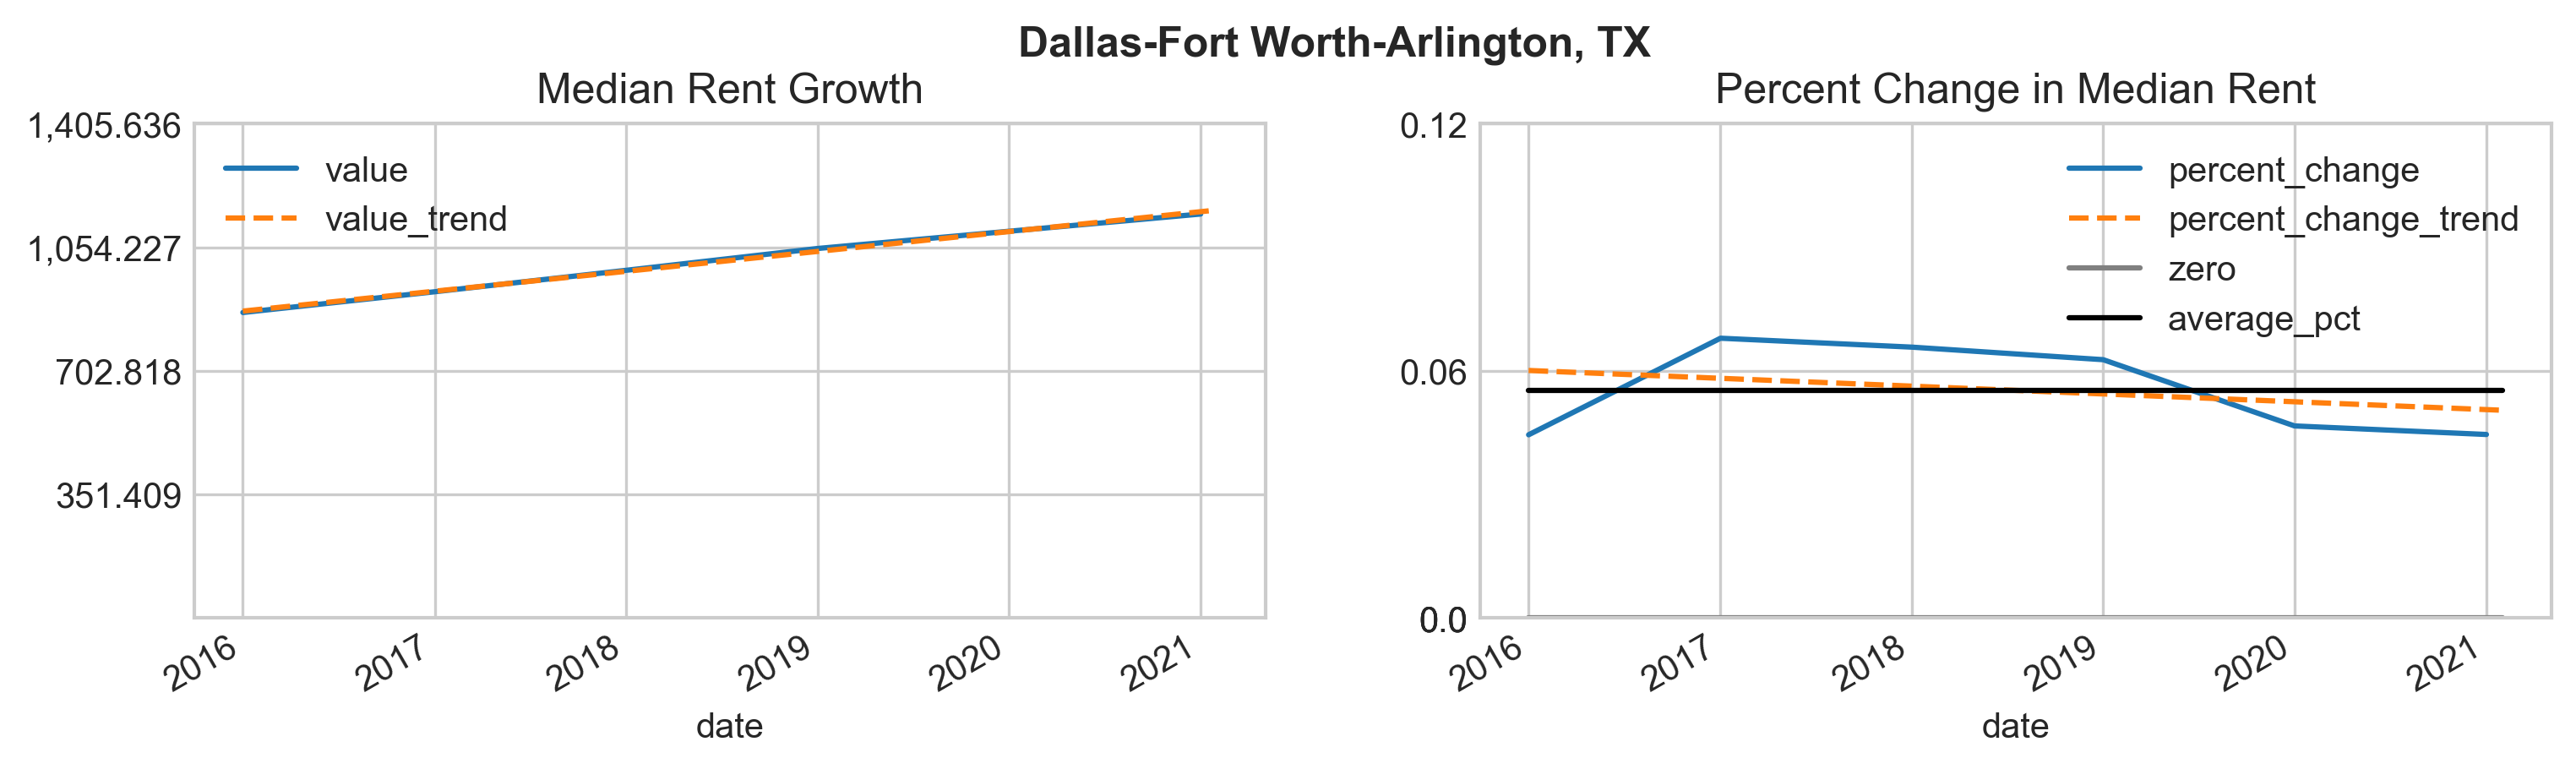

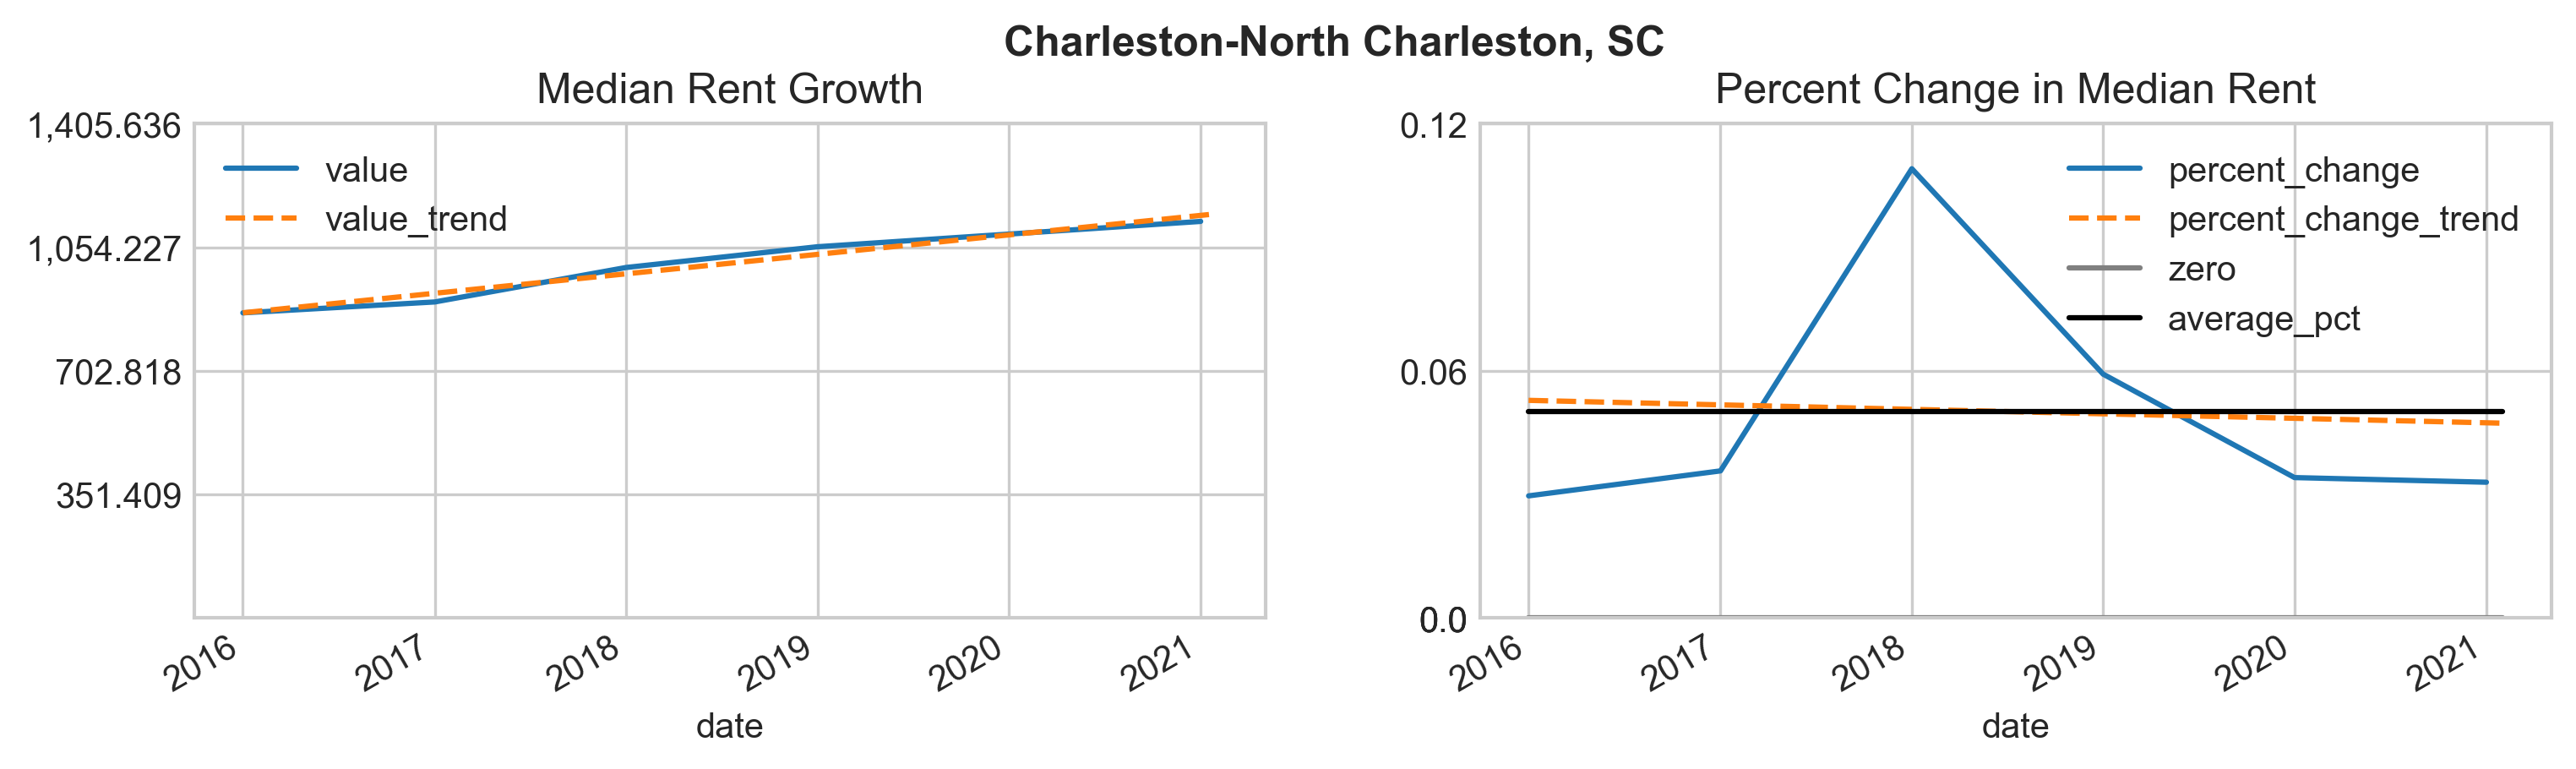

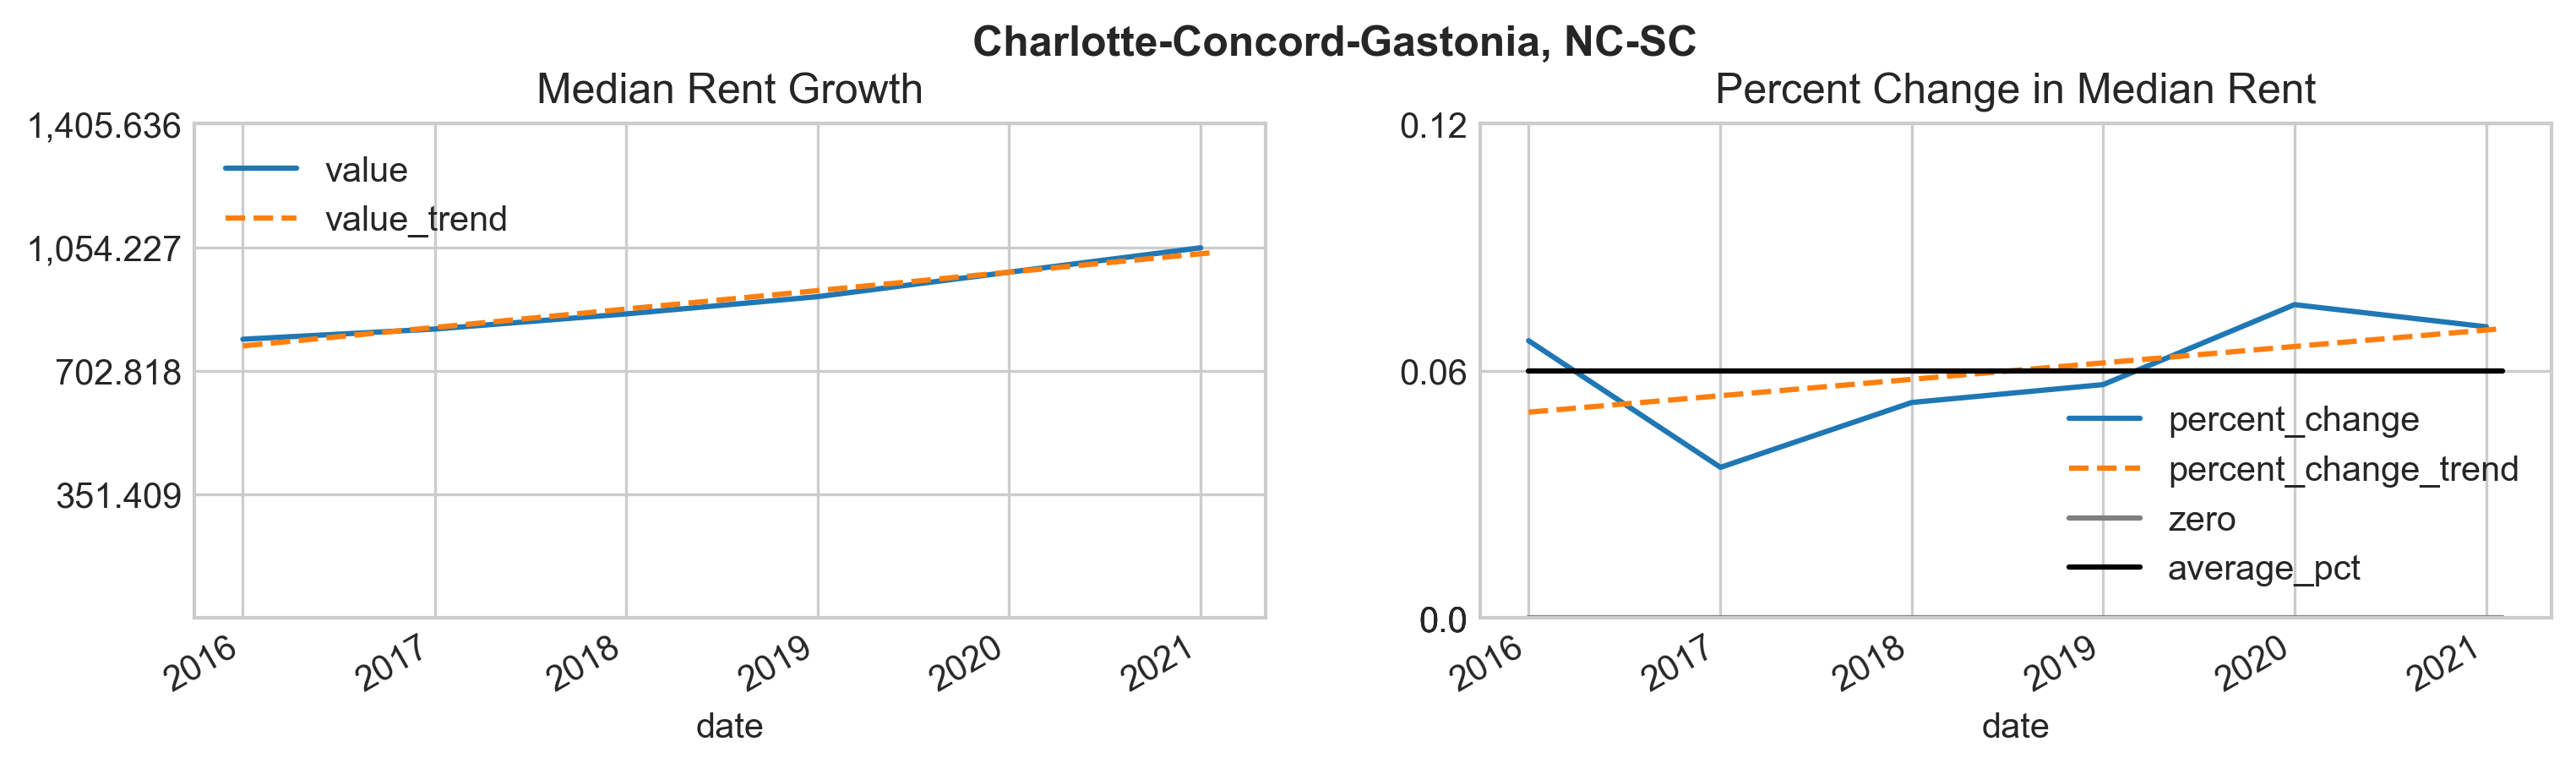

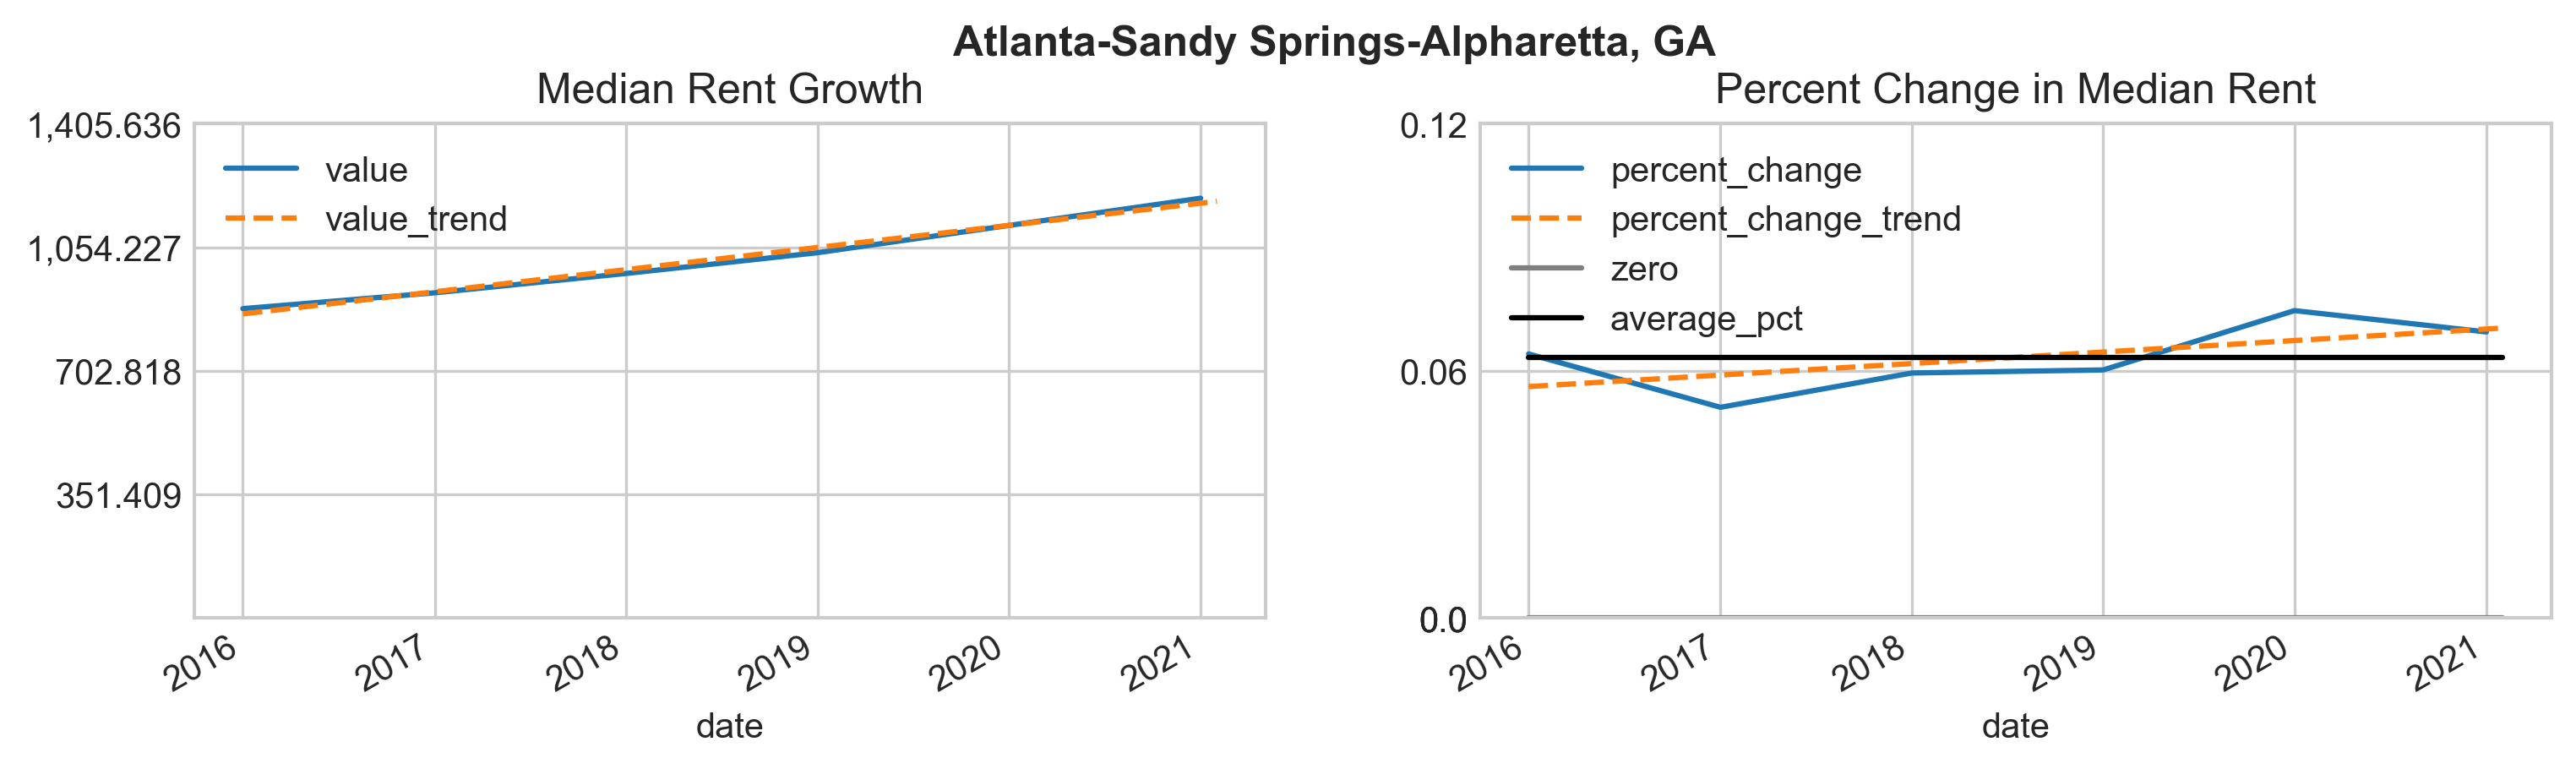

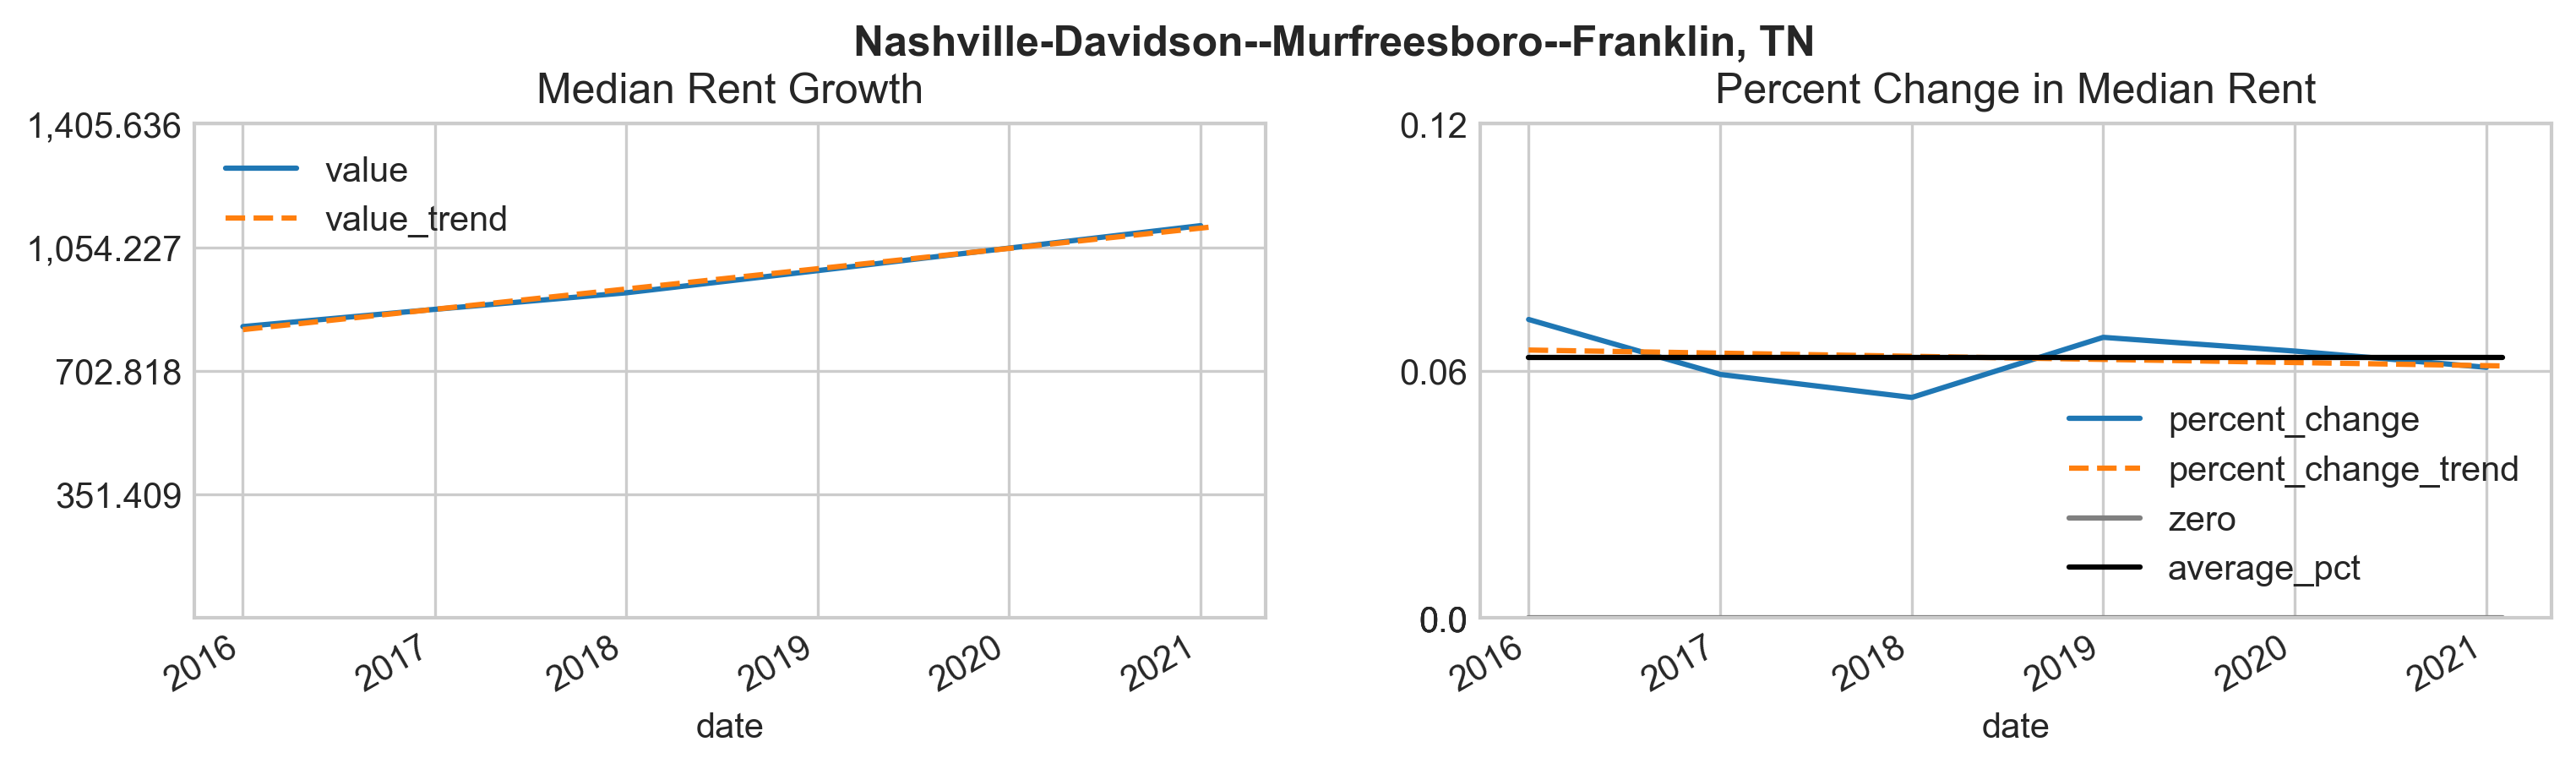

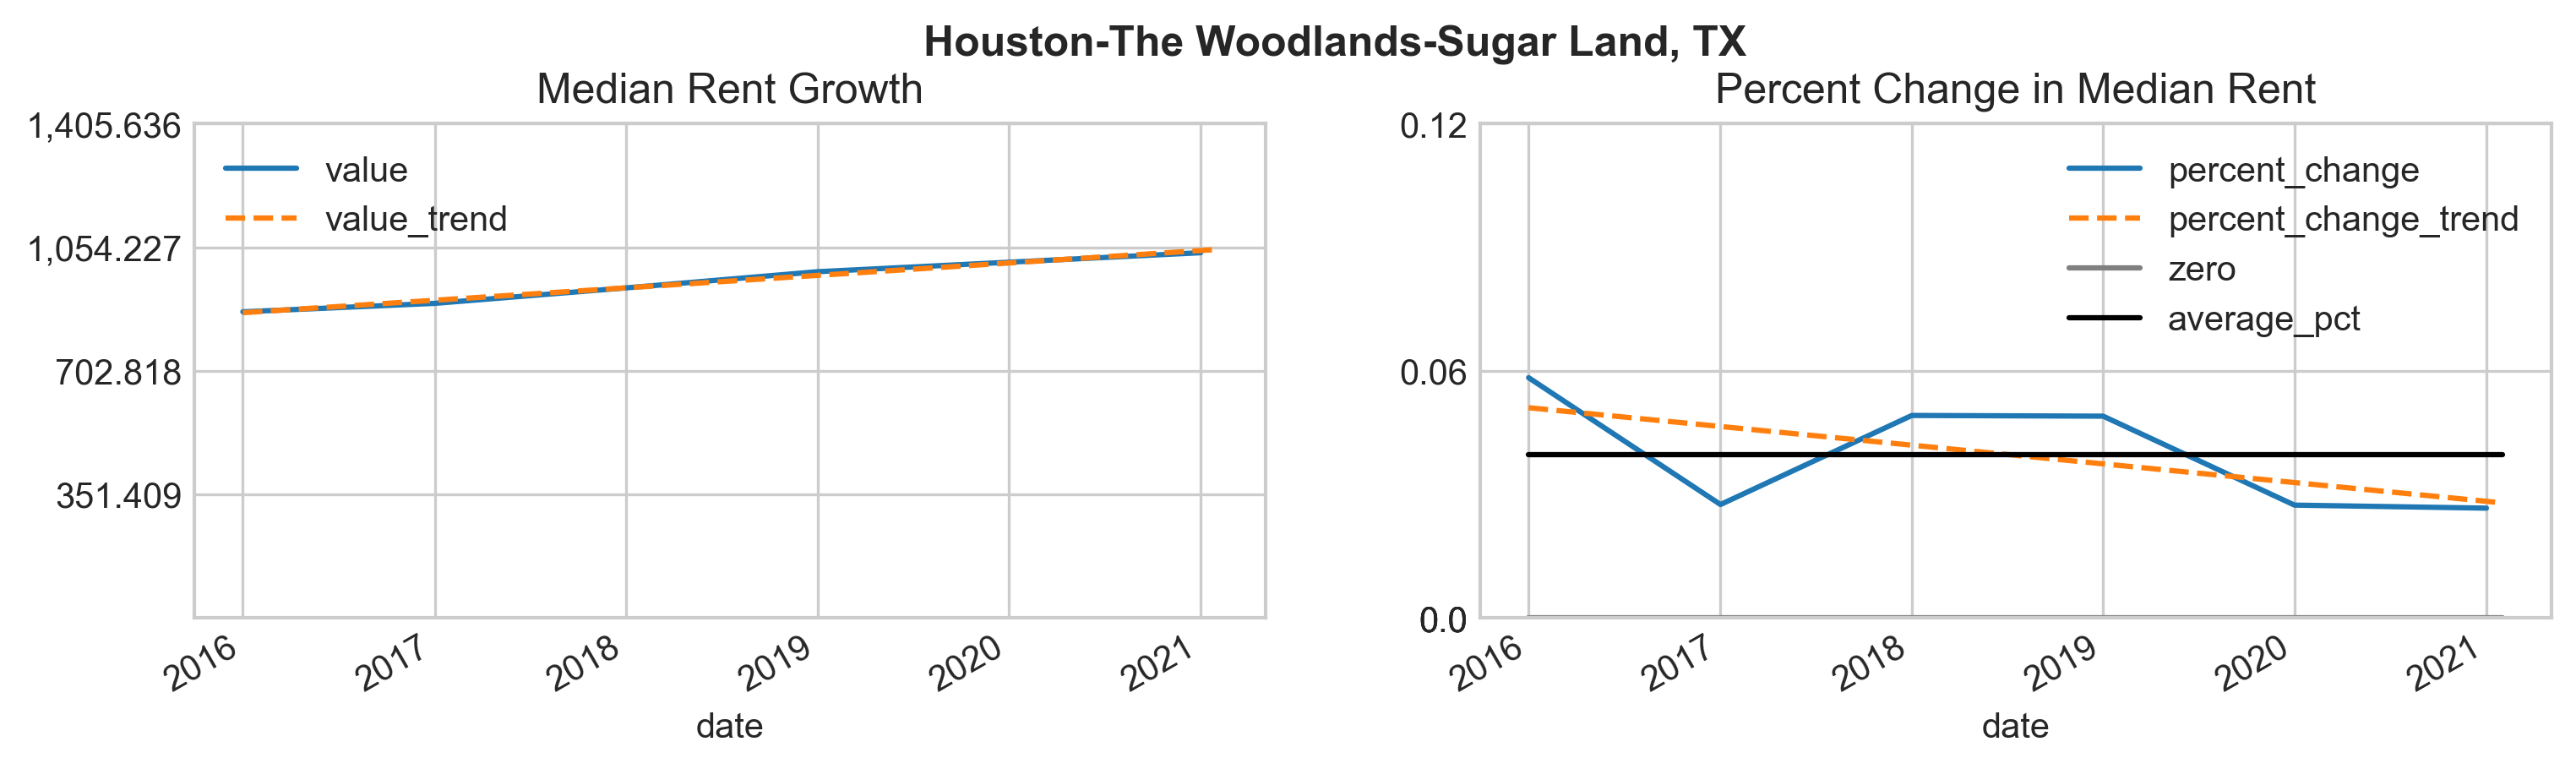

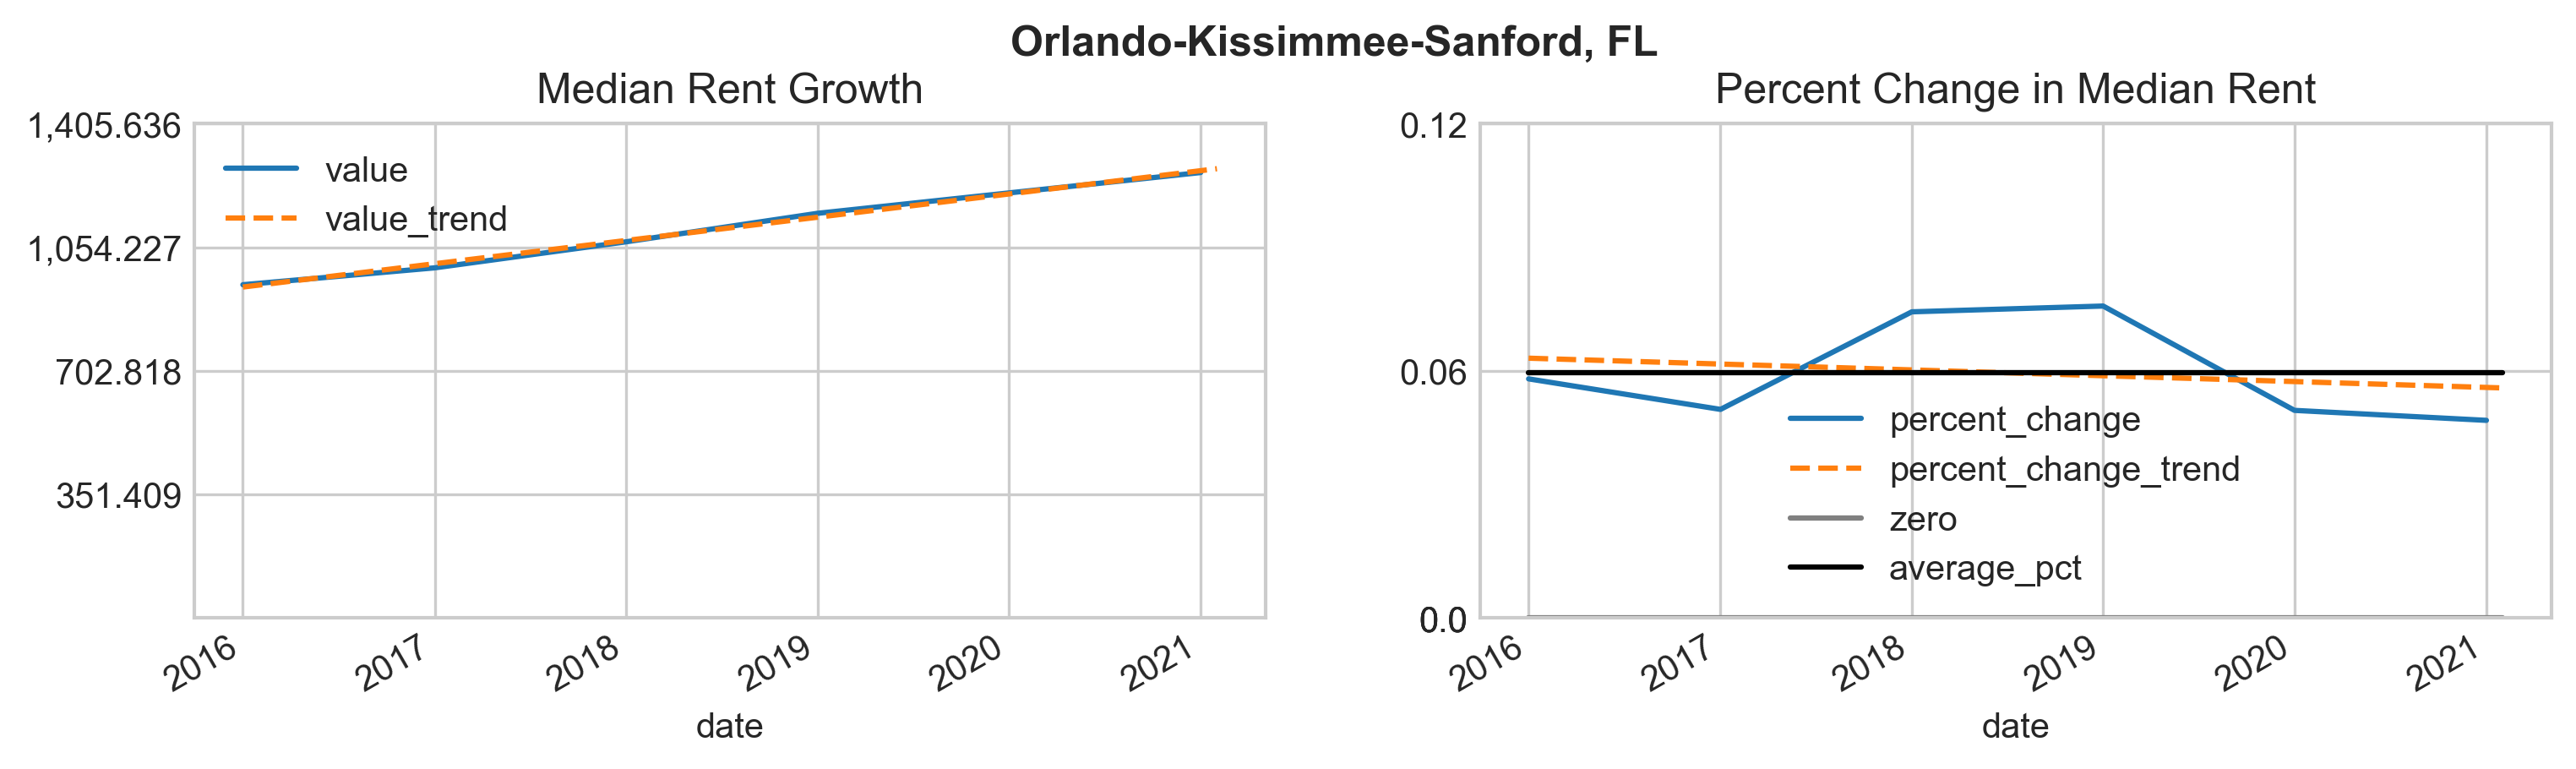

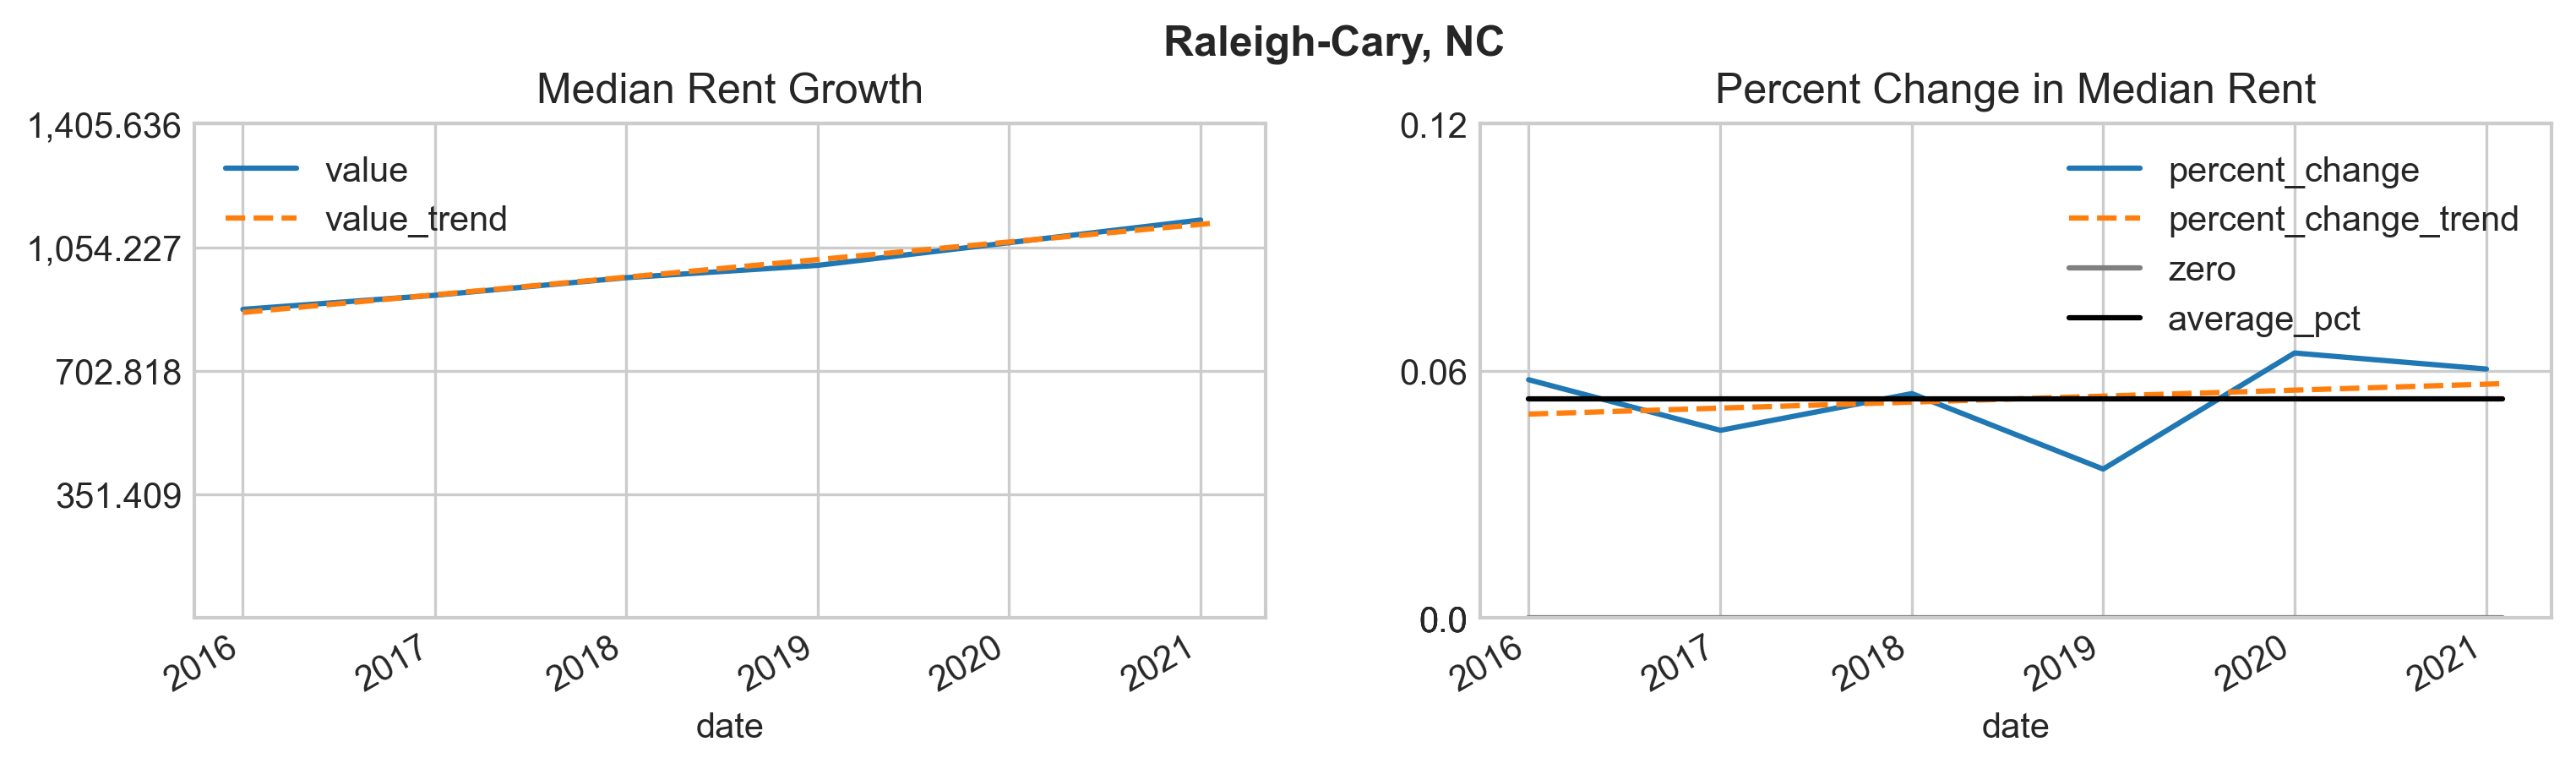

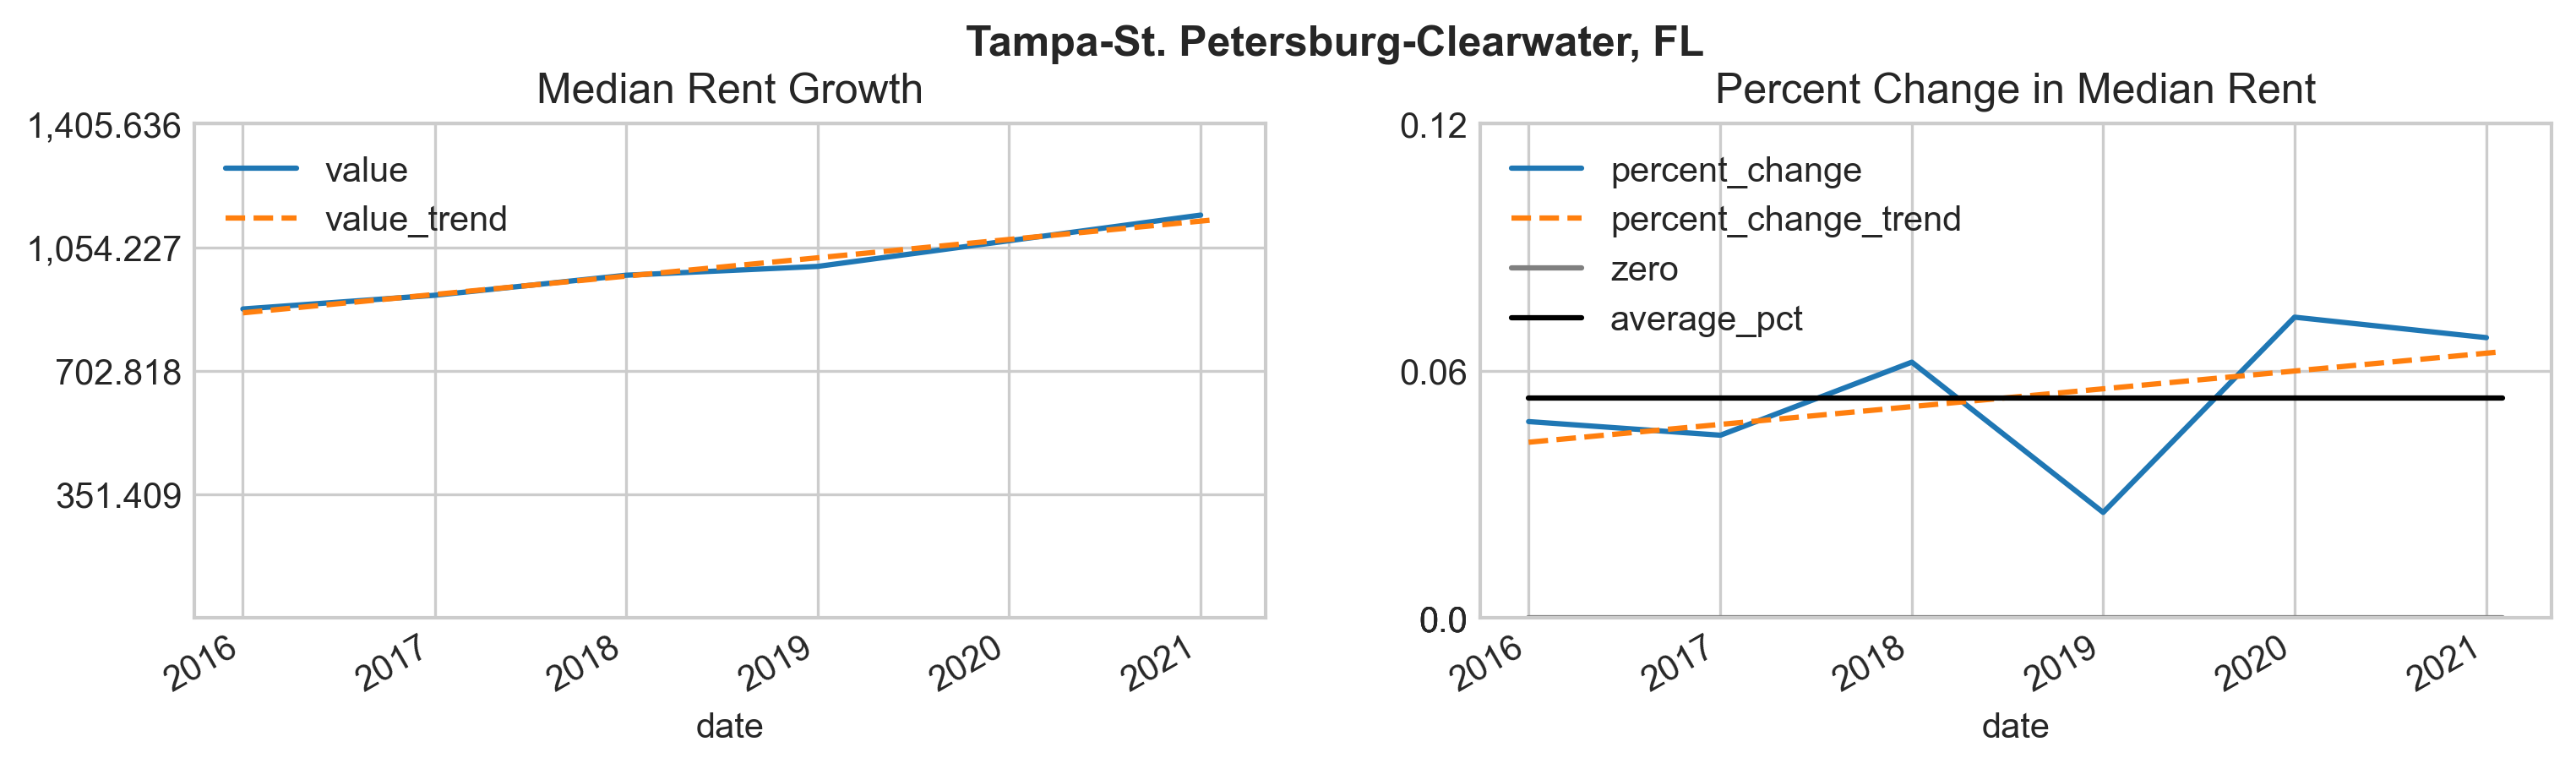

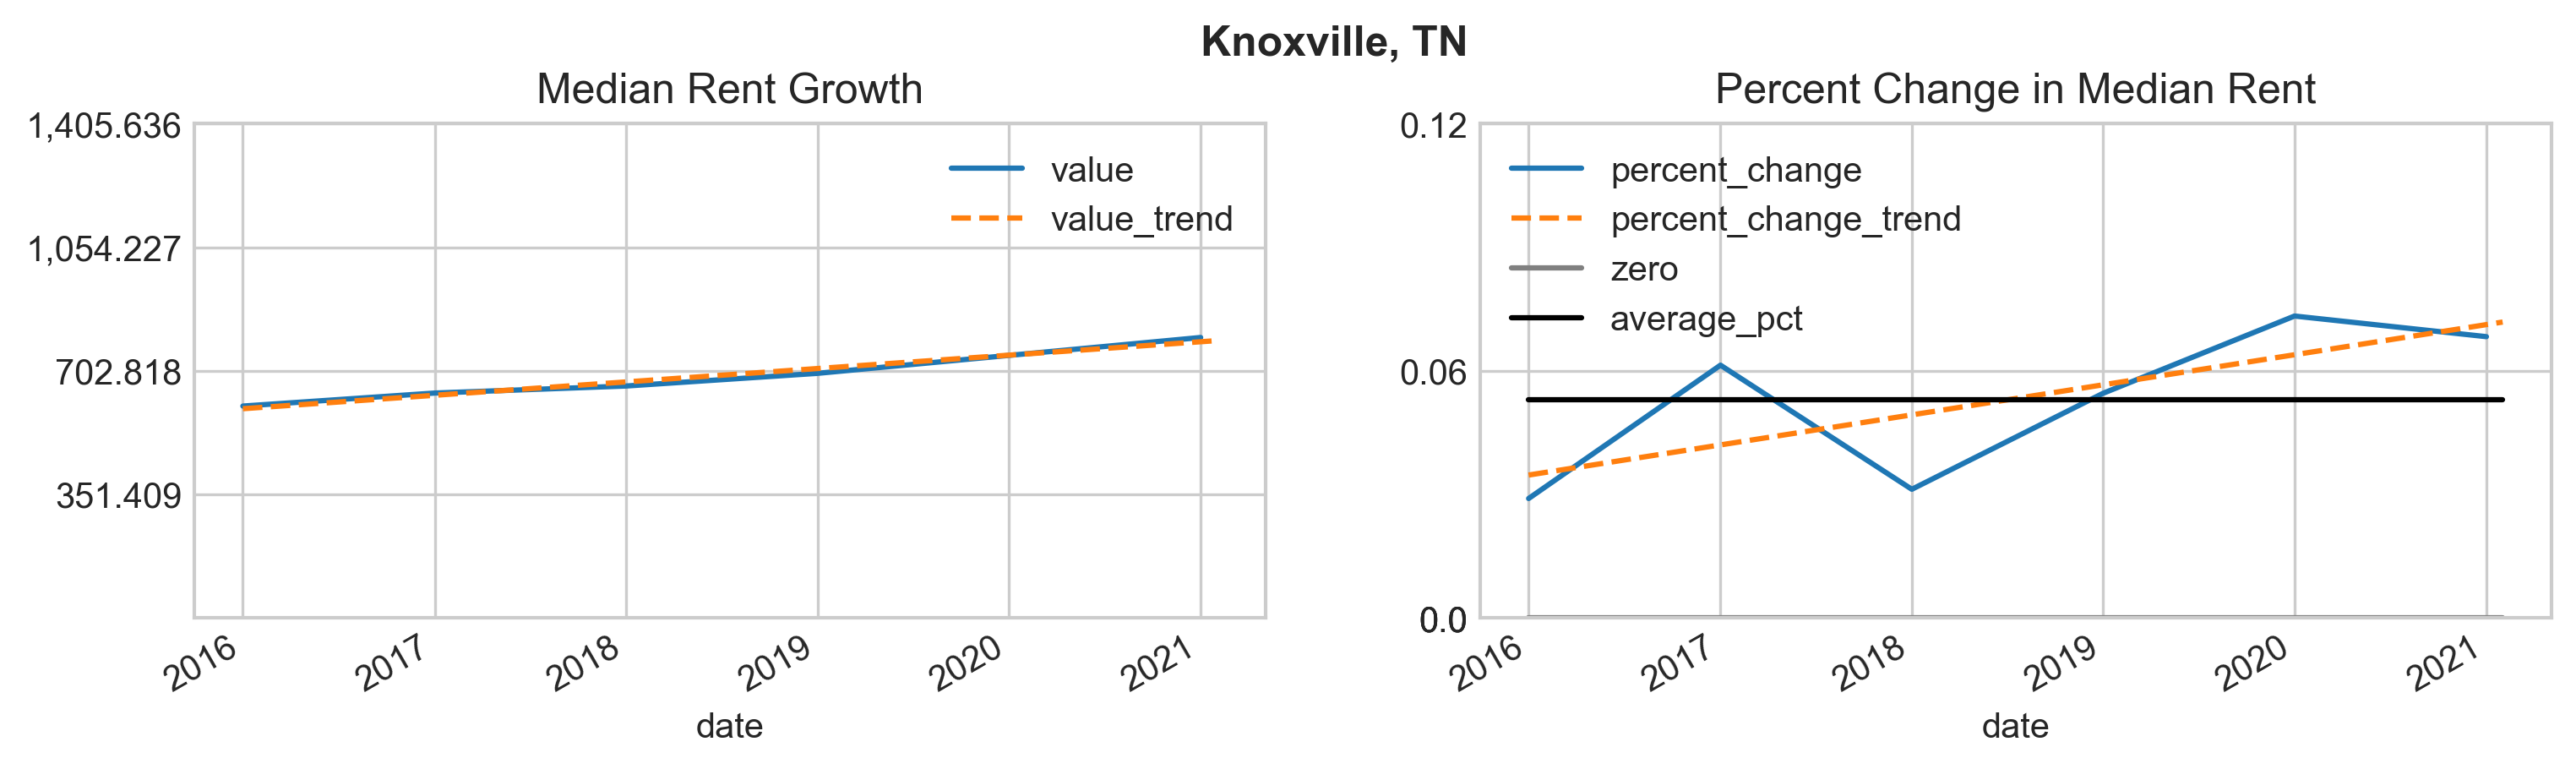

In [53]:
### Turn one of the plot_{demographics} to True,
### and leave the rest False to graph your demographic
plot_top_10_cities(
    ranked_cities=rank_jobs_rent,
    plot_jobs=False,
    plot_rent=True,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    begin_year_1=2016, 
)

In [ ]:
plot_top_10_cities(
    ranked_cities=rank_all,
    plot_jobs=False,
    plot_rent=True,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    begin_year_1=2016, 
)

In [ ]:
### PLOT EVERY MSA
plot_top_10_cities(
    ranked_cities=rank_jobs_rent,
    plot_jobs=True,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    begin_year_1=2022, 
    plot_all=True
)

In [ ]:
### Plot every demographic
def plot_every_demographic(
    ranking_df, 
    begin_job_year=begin_job_year, 
    census_begin_year=census_begin_year,
    plot_all=False
):
    
    # Plot job growth, ranked by job and rent
    plot_top_10_cities(
        ranked_cities=ranking_df,
        plot_jobs=True,
        begin_year_1=begin_job_year, 
    )
    
    # Plot every demographic 
    demo_kwargs = {
        'plot_rent':False,
        'plot_income':False,
        'plot_price':False,
        'plot_units':False,
        'plot_rent_to_price':False,
        'plot_jobs_per_unit':False,
    }

    # Loop through each demo argument
    for demo_arg in demo_kwargs:

        # Make a copy
        demo_kwargs_copy = demo_kwargs.copy()

        # Make the demo set to True
        demo_kwargs_copy[demo_arg] = True

        # Plot
        plot_top_10_cities(
            ranked_cities=ranking_df,
            begin_year_1=census_begin_year,
            plot_all=plot_all,
            **demo_kwargs_copy
        )
    


In [170]:
### PLOT SPECIFIC CITY
specific_city = rank_all_no_restrictions[
    rank_all_no_restrictions['msa_name'].str.contains('Bend')]

specific_city

msa_name trend_coef_Jobs average_value_Jobs  \
13                      Bend, OR        3.682328         200.000000   
120  South Bend-Mishawaka, IN-MI       19.986309         418.181818   

    average_pct_Jobs trend_coef_Median Income average_value_Median Income  \
13          0.002207                 9.545418                 3737.166667   
120         0.003041                 5.001788                 2034.833333   

    average_pct_Median Income trend_coef_Median Rent  \
13                   0.056688               0.214988   
120                  0.039480               0.060344   

    average_value_Median Rent average_pct_Median Rent trend_coef_Median Price  \
13                  81.333333                0.081699              114.774466   
120                 20.666667                0.032478               19.921228   

    average_value_Median Price average_pct_Median Price  \
13                38550.000000                 0.098498   
120                6300.000000                 0.045264   

    normalized_trend_coef_Jobs normalized_average_pct_Jobs Jobs_weight  \
13                    0.008789                    0.544922    1.641359   
120                   0.024065                    0.649413    1.966287   

    normalized_trend_coef_Median Income normalized_average_pct_Median Income  \
13                             0.654807                             0.730803   
120                            0.424596                             0.555750   

    Median Income_weight normalized_trend_coef_Median Rent  \
13              0.894505                          0.888826   
120             0.661899                          0.313307   

    normalized_average_pct_Median Rent Median Rent_weight  \
13                            1.000000           2.444413   
120                           0.514976           1.186606   

    normalized_trend_coef_Median Price normalized_average_pct_Median Price  \
13                            0.636336                            0.691832   
120                           0.114785                            0.350497   

    Median Price_weight total_weight  median_rent  median_price  \
13             0.345916     5.326194  1353.000000 543900.000000   
120            0.175249     3.990041   713.000000 163700.000000   

     median_income  rent_to_price_ratio   total_units          jobs  \
13    79796.000000             0.002488  96942.000000  92100.000000   
120   59416.000000             0.004356 143849.000000 140500.000000   

     jobs_per_unit  
13        0.950053  
120       0.976719

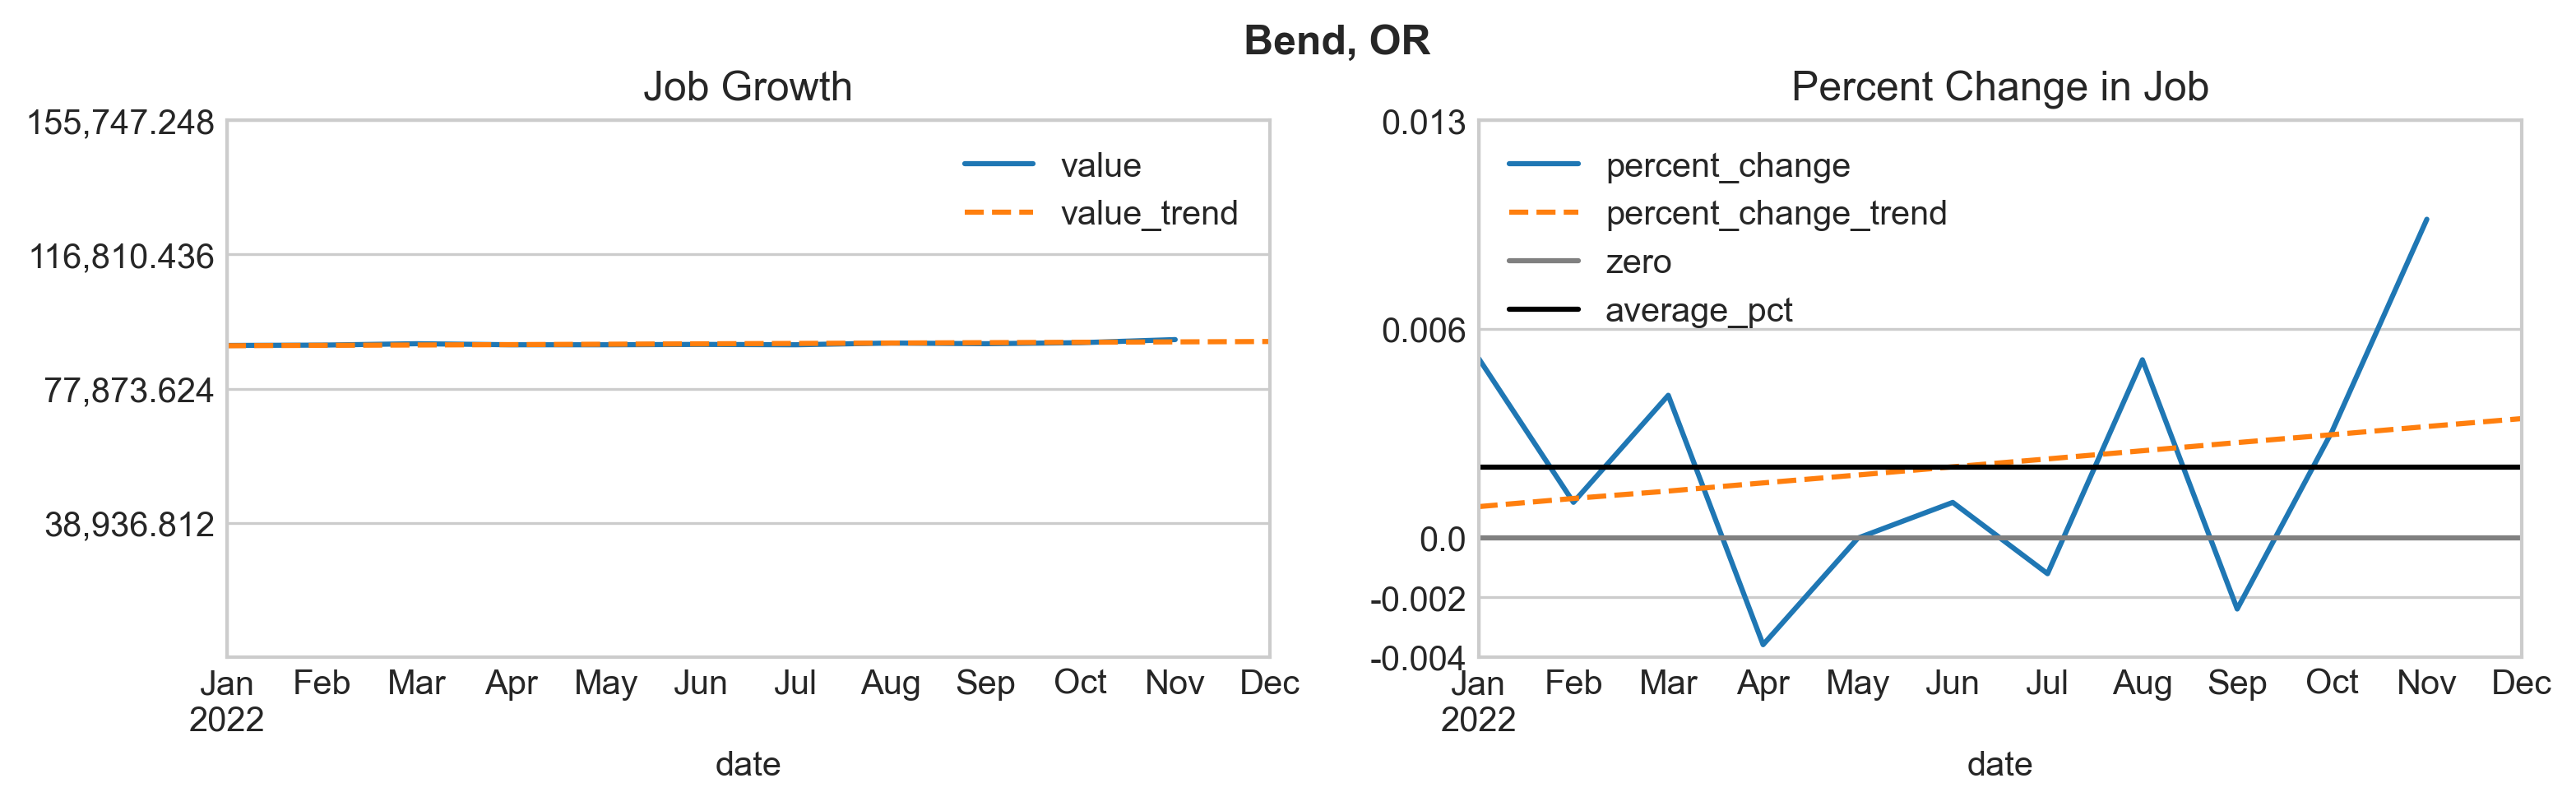

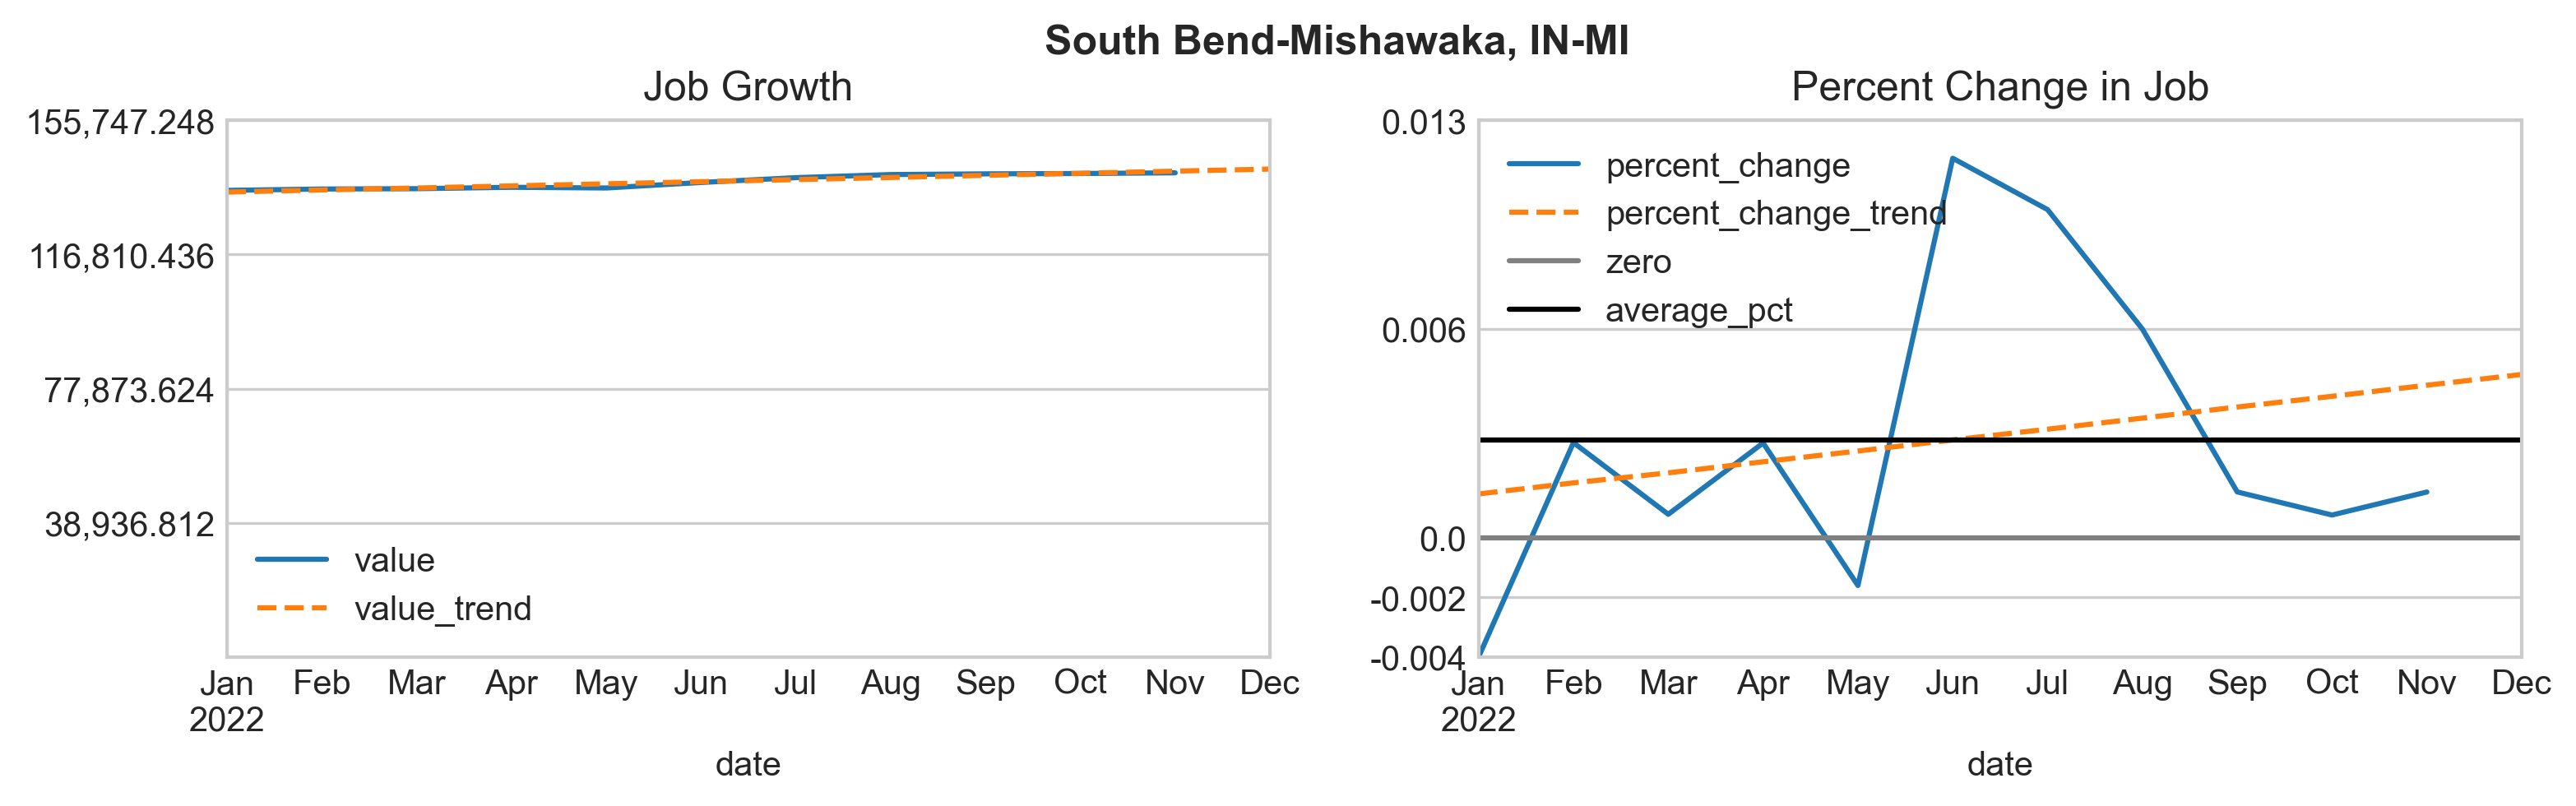

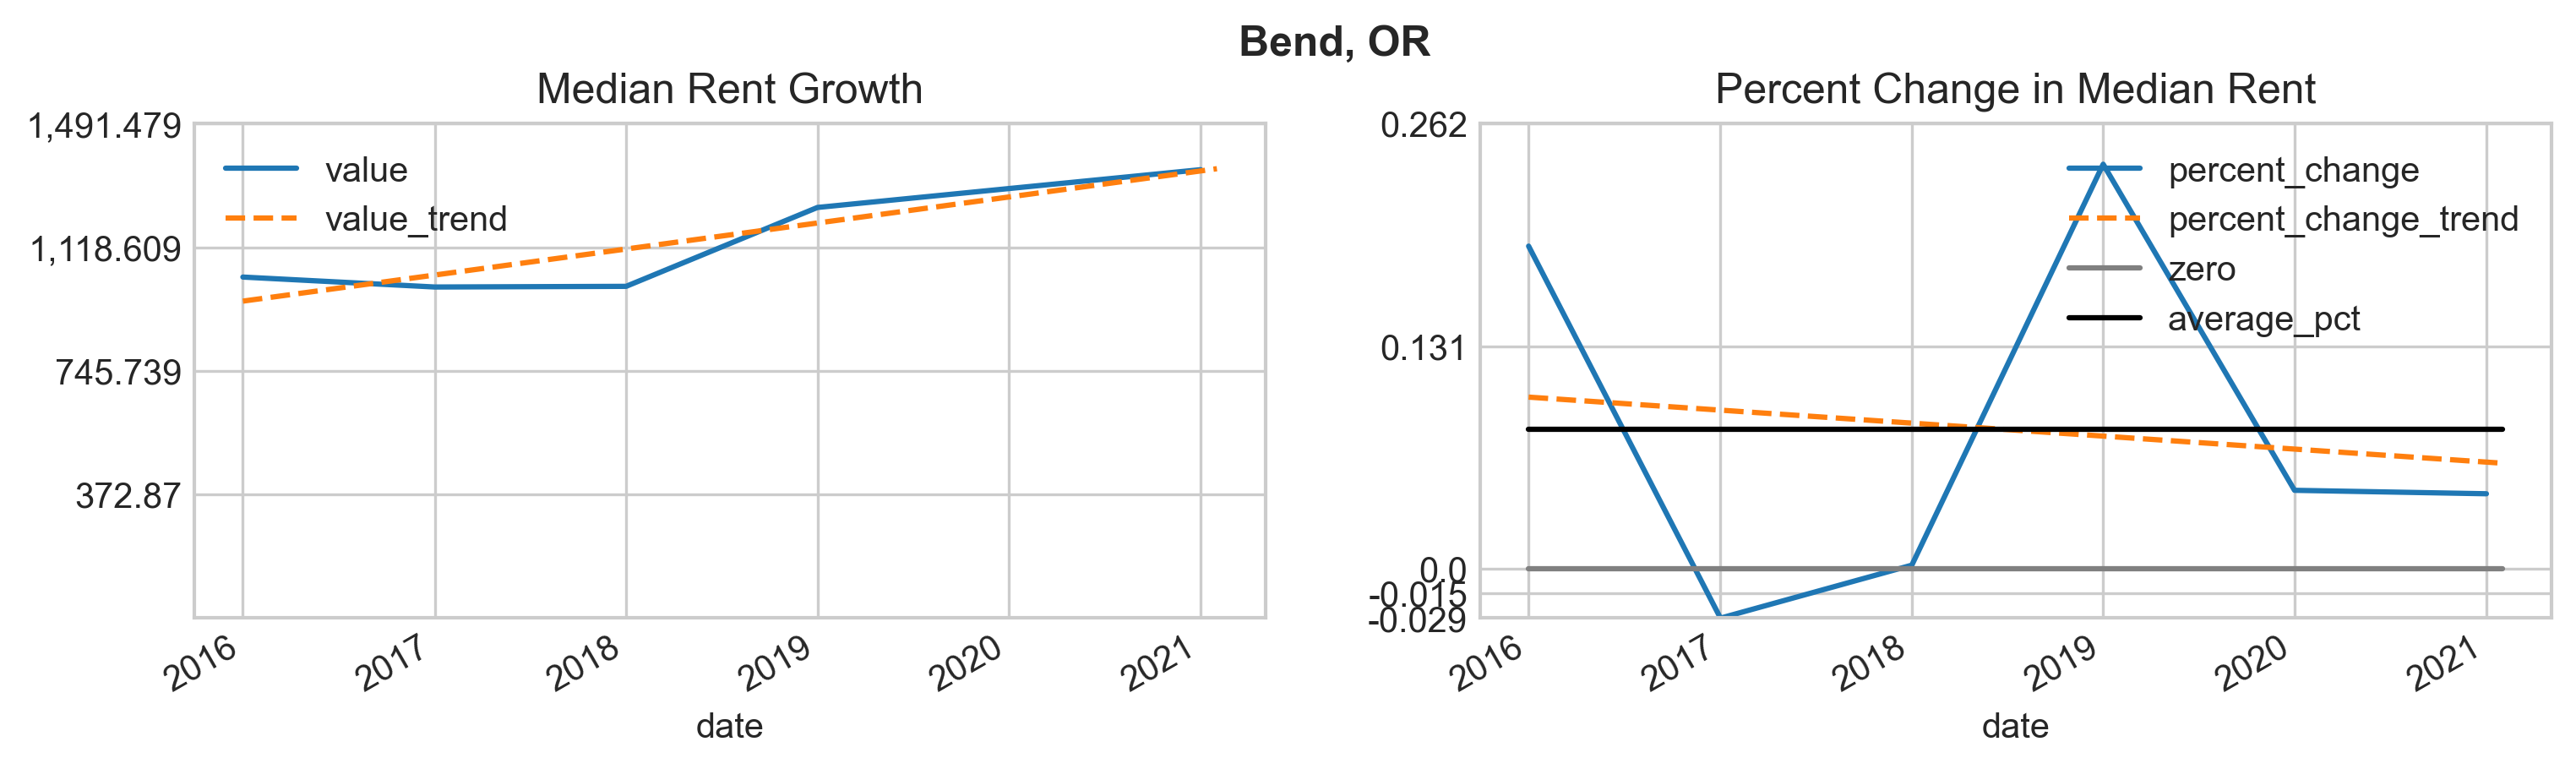

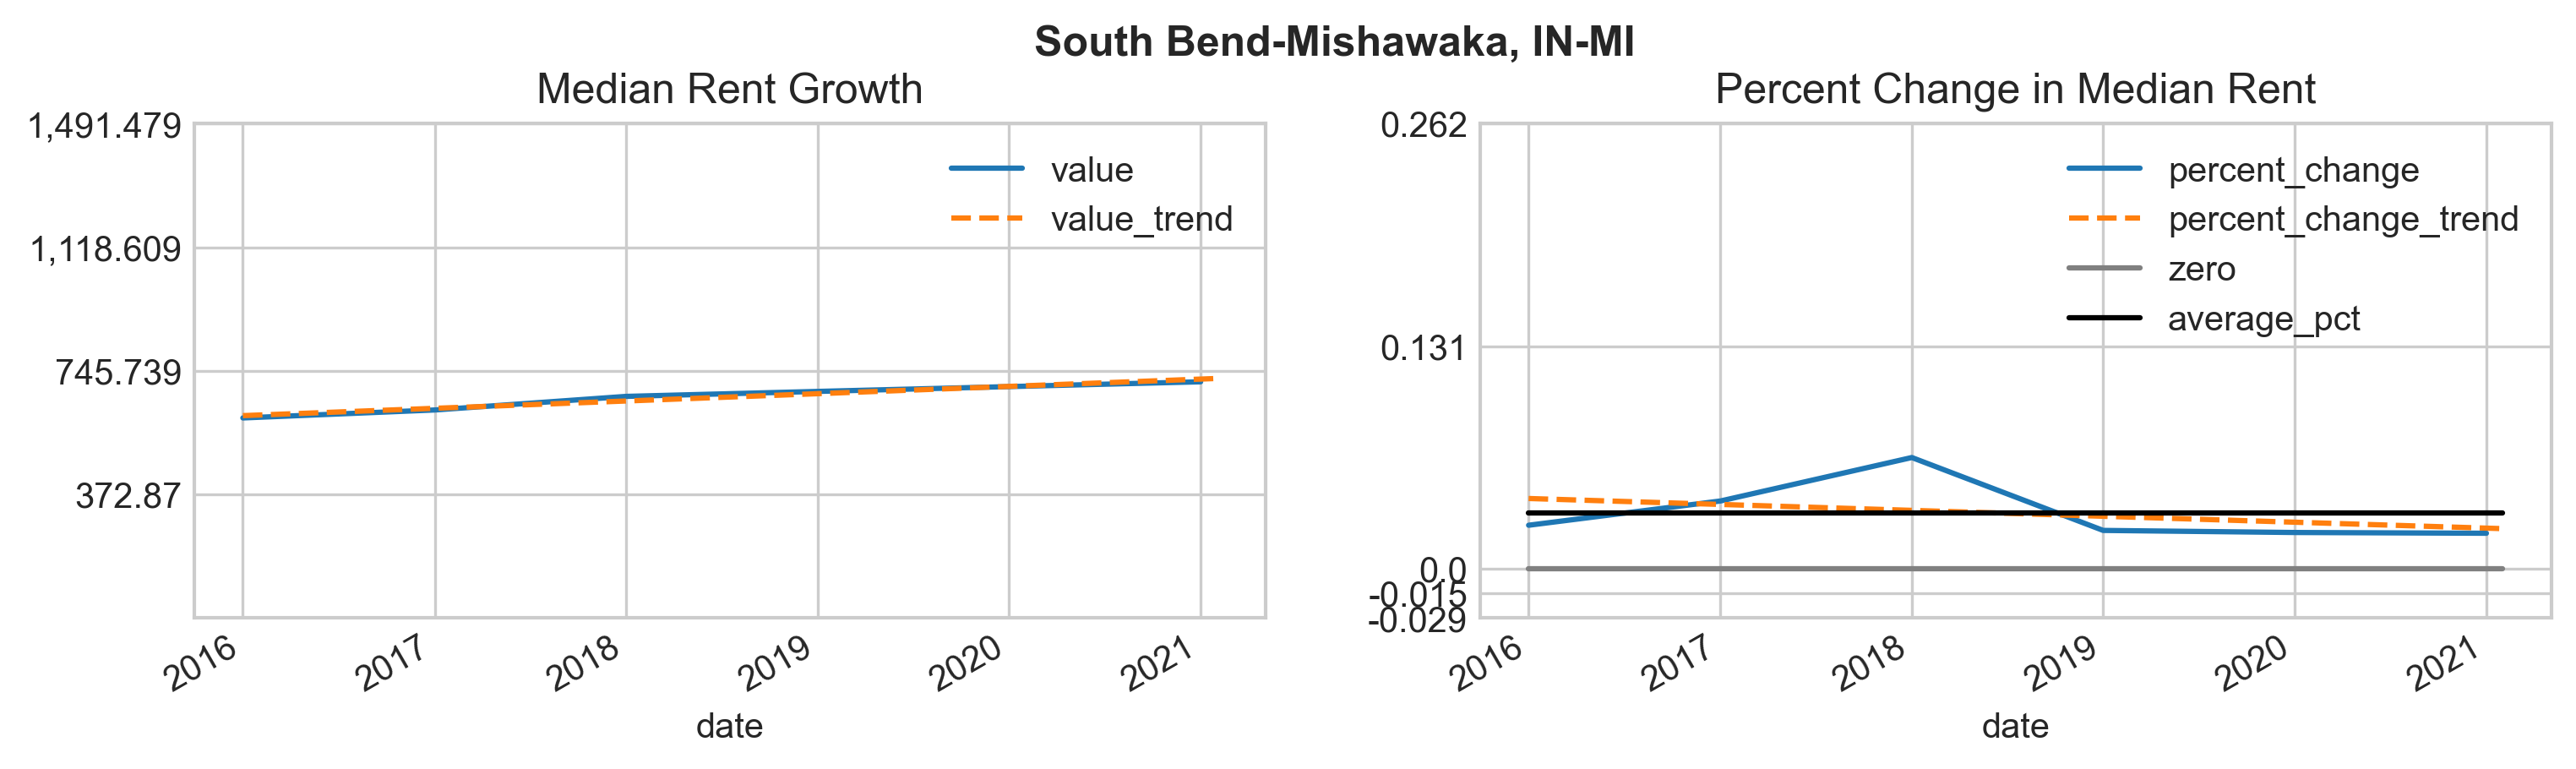

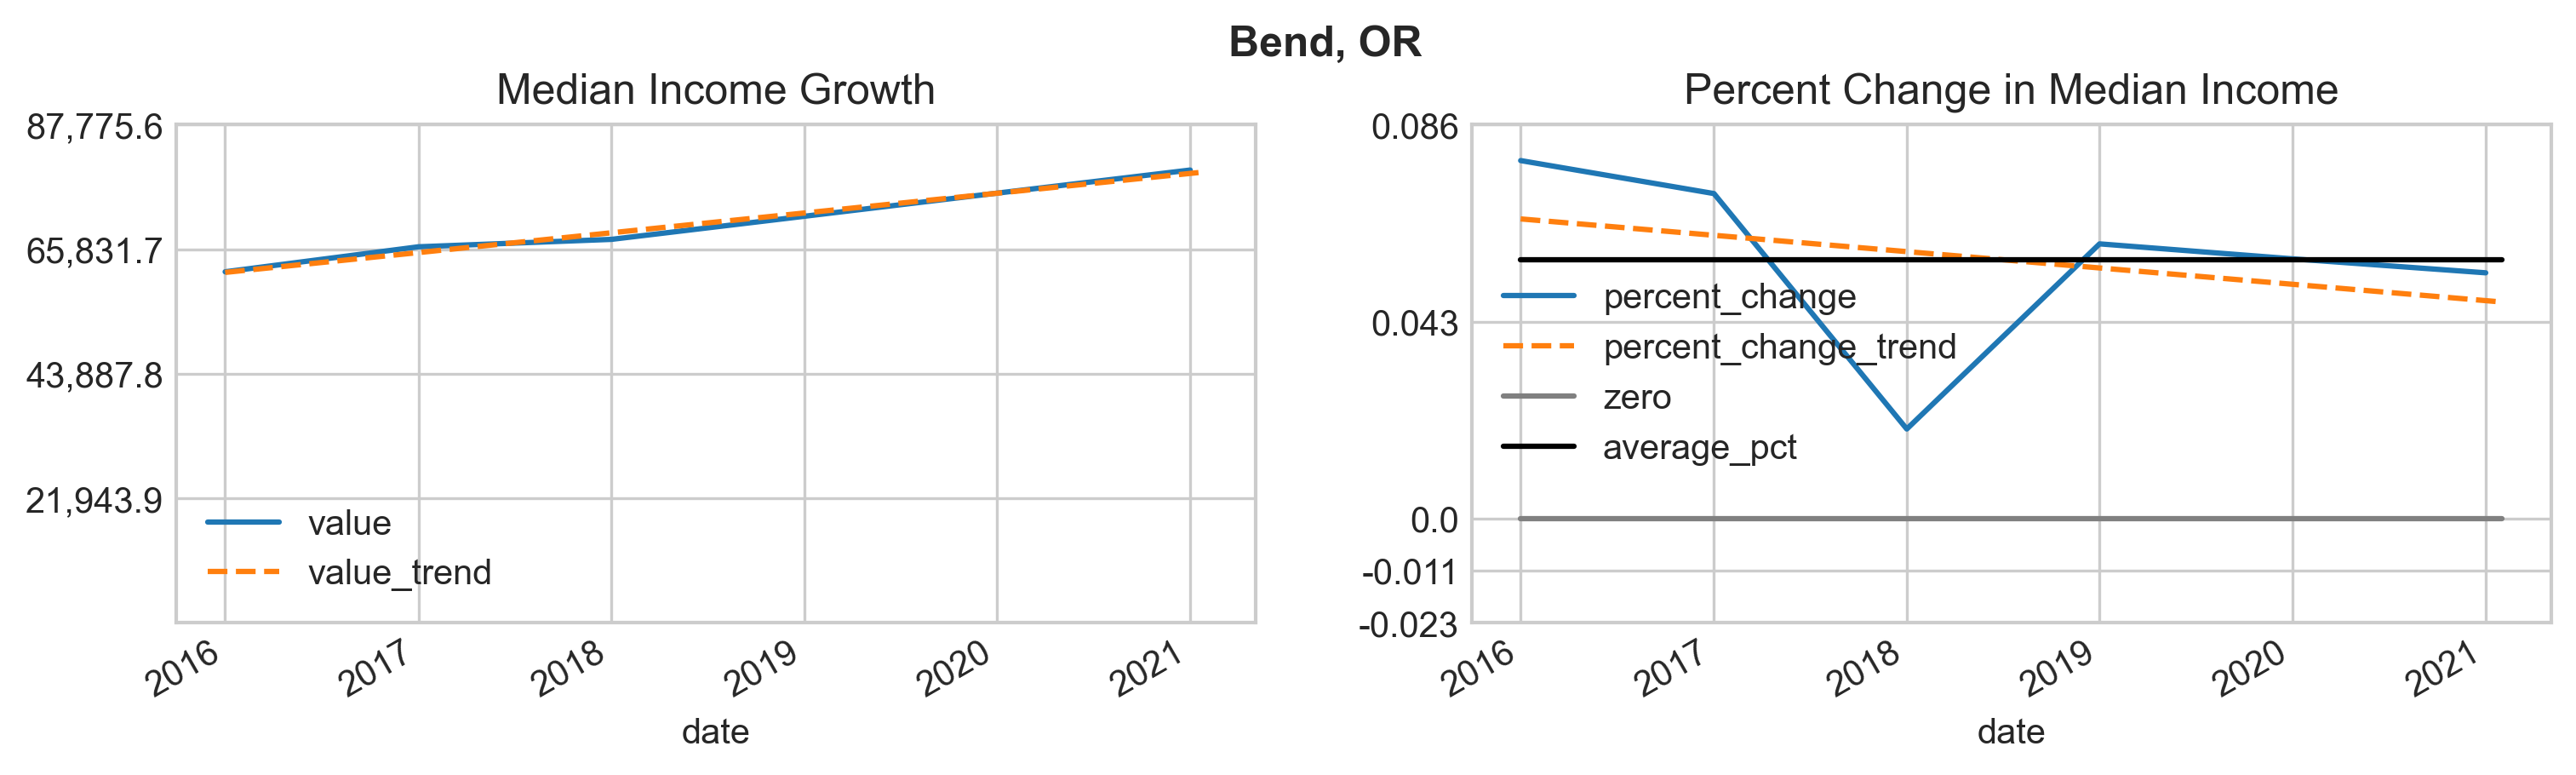

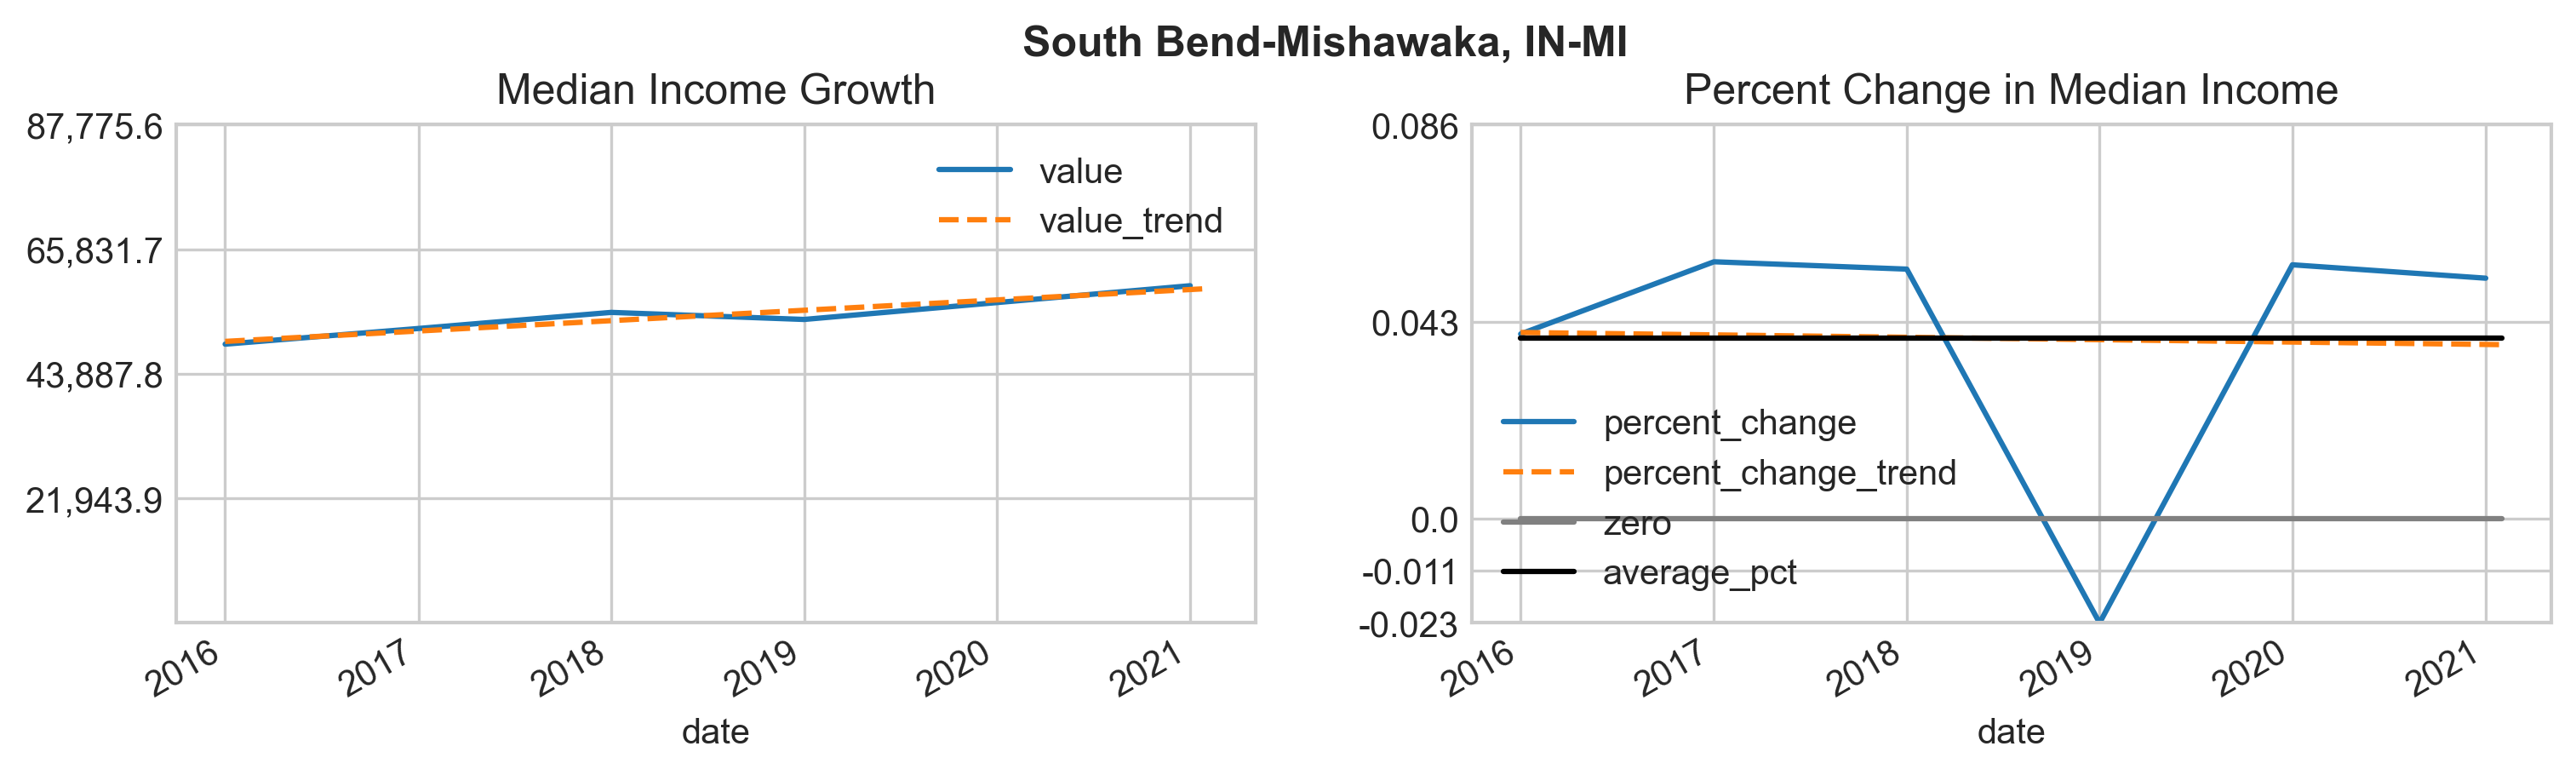

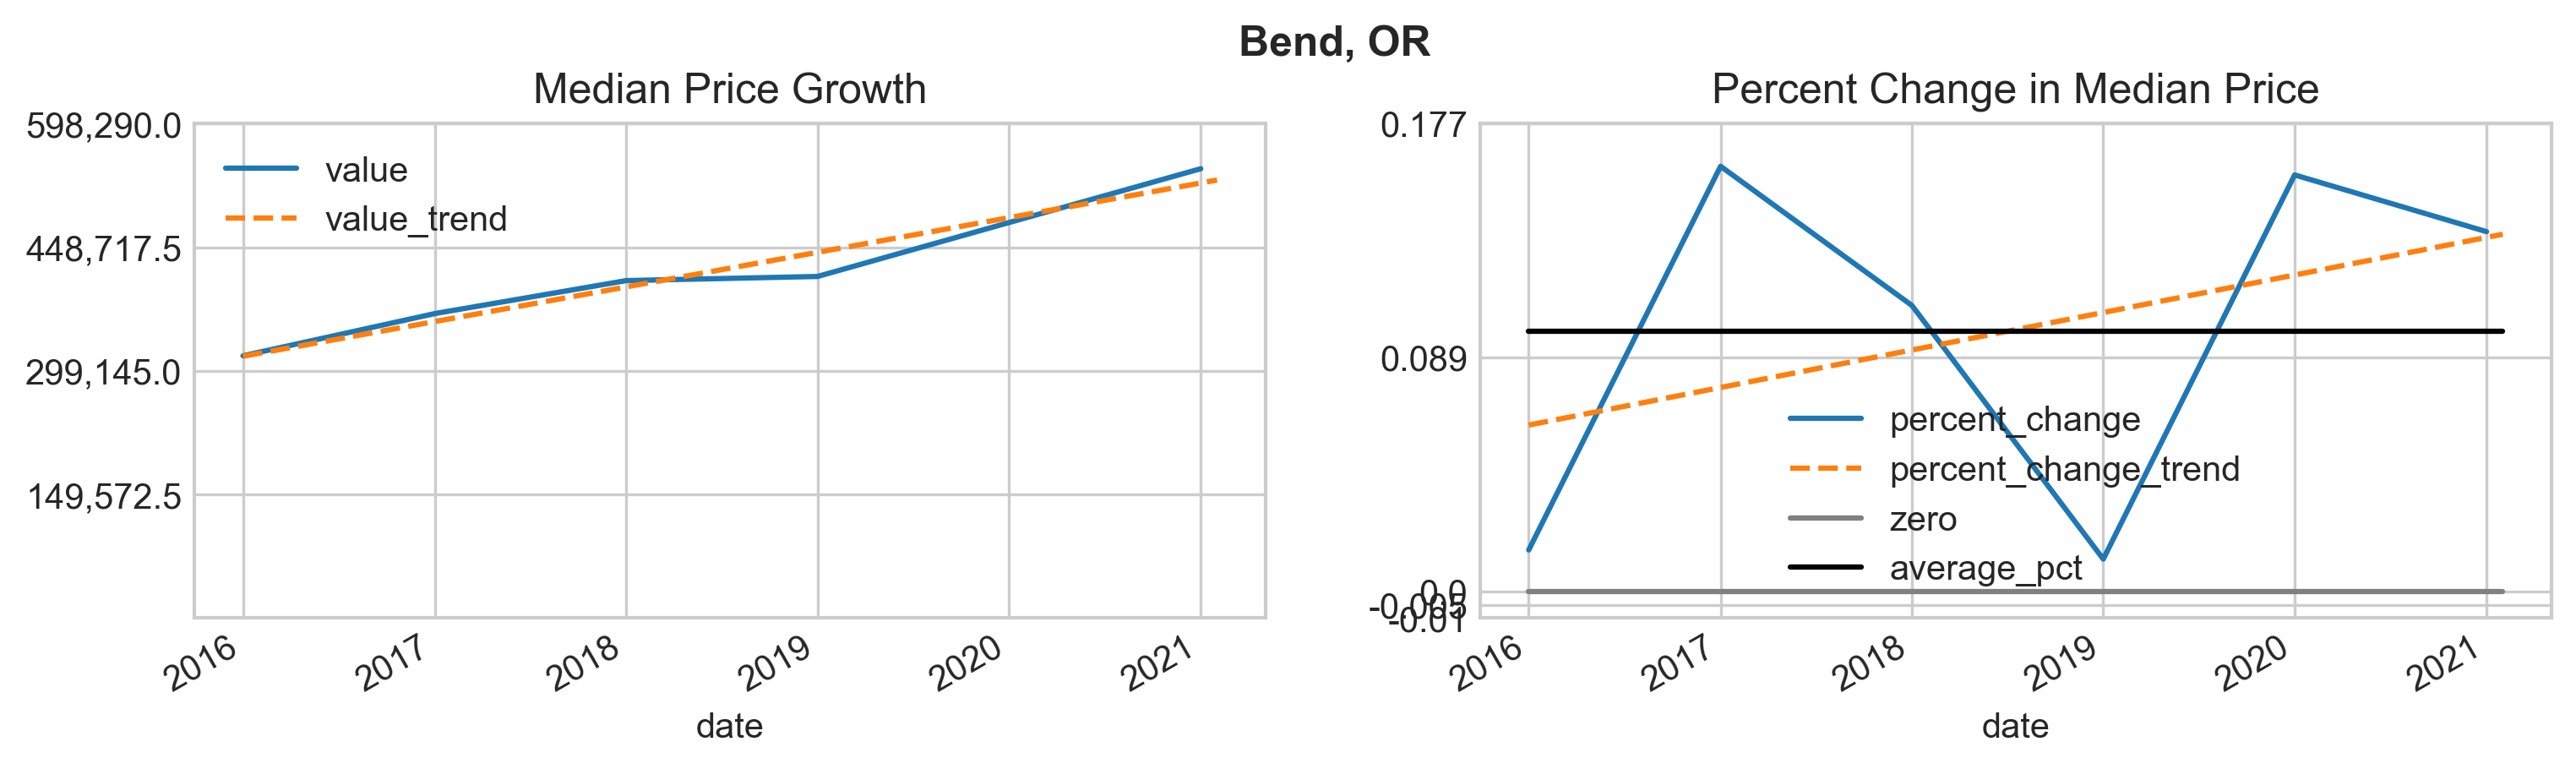

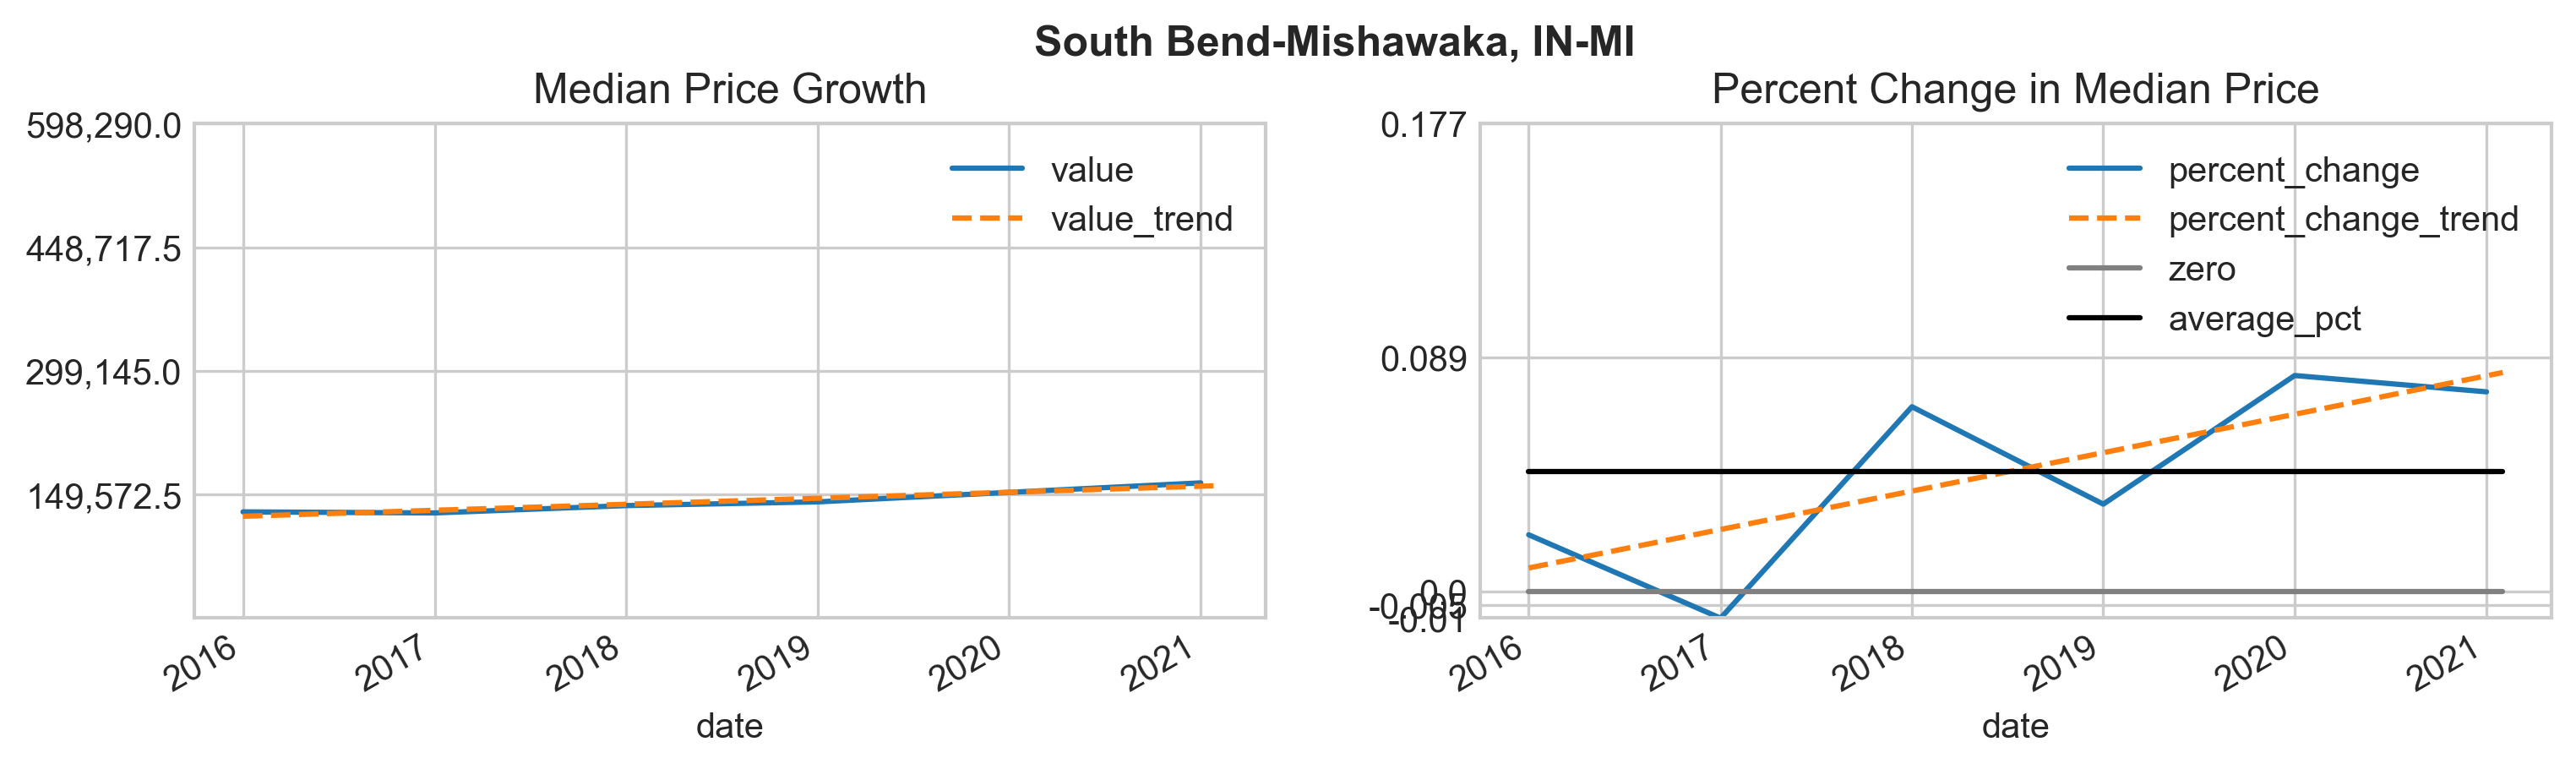

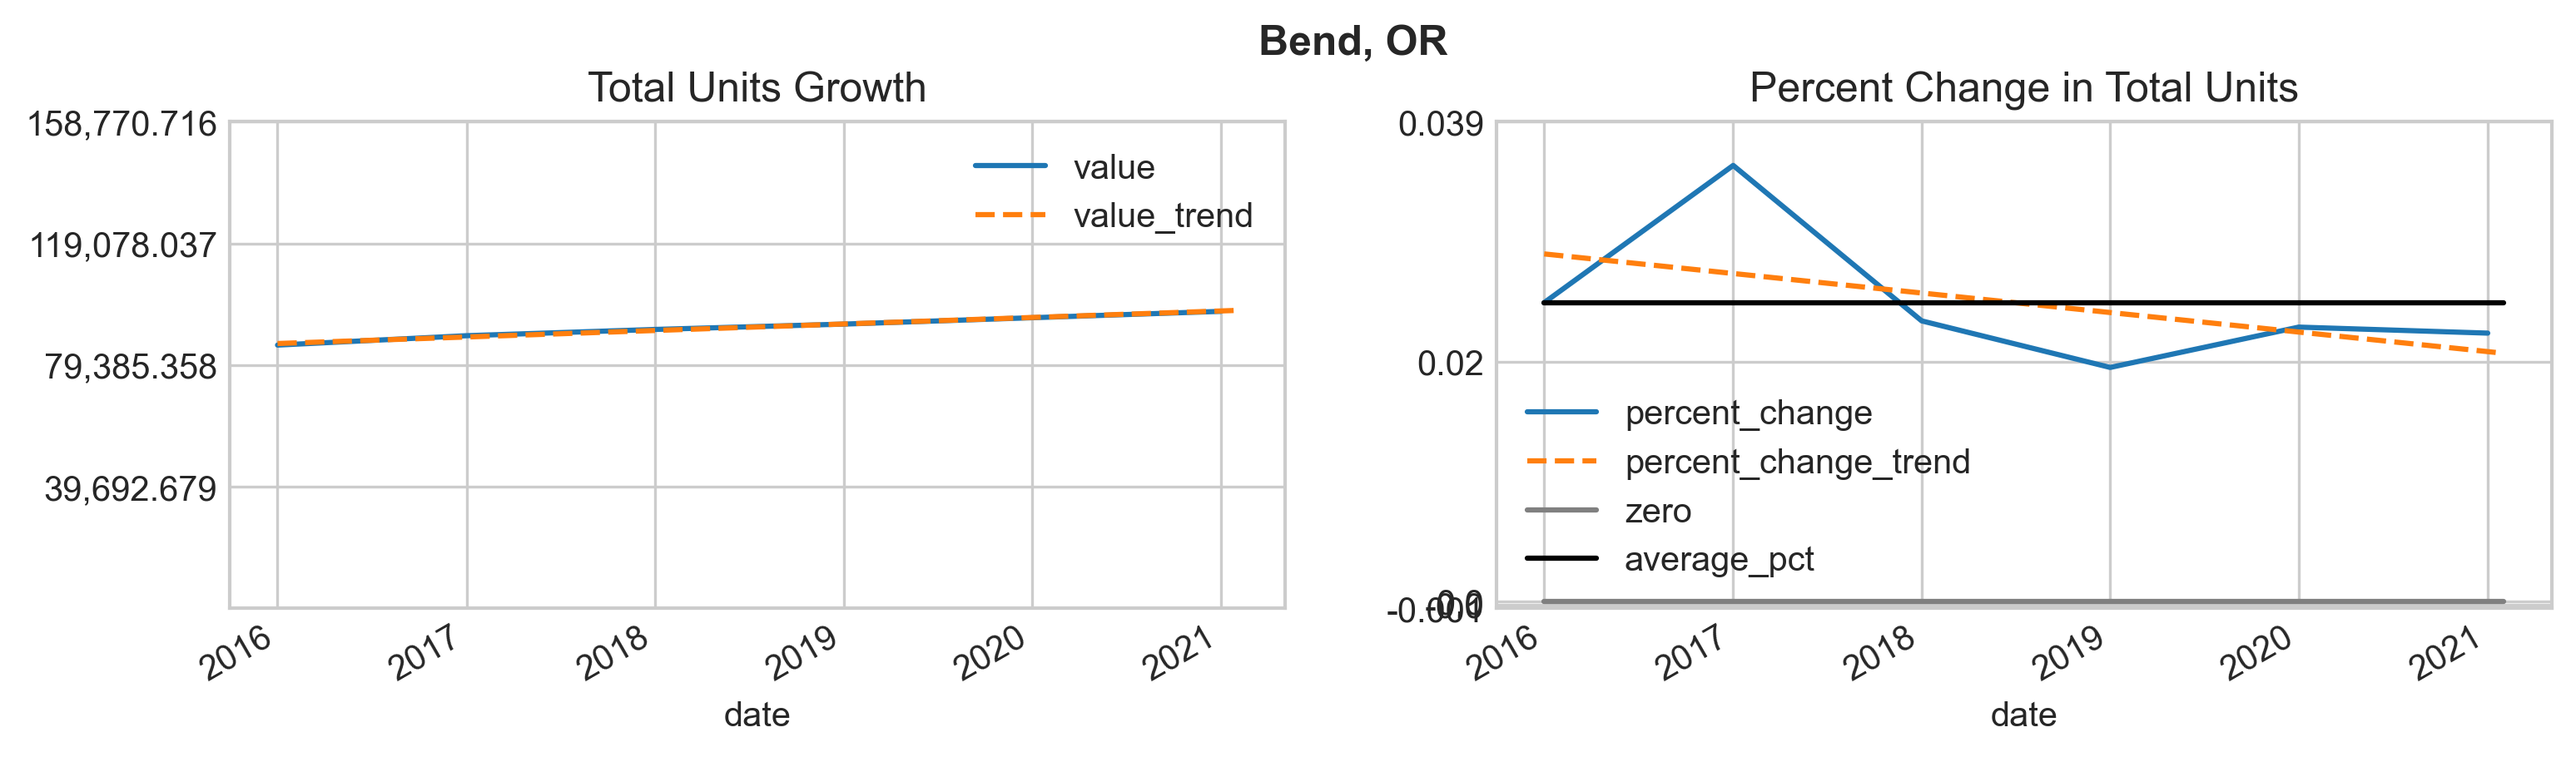

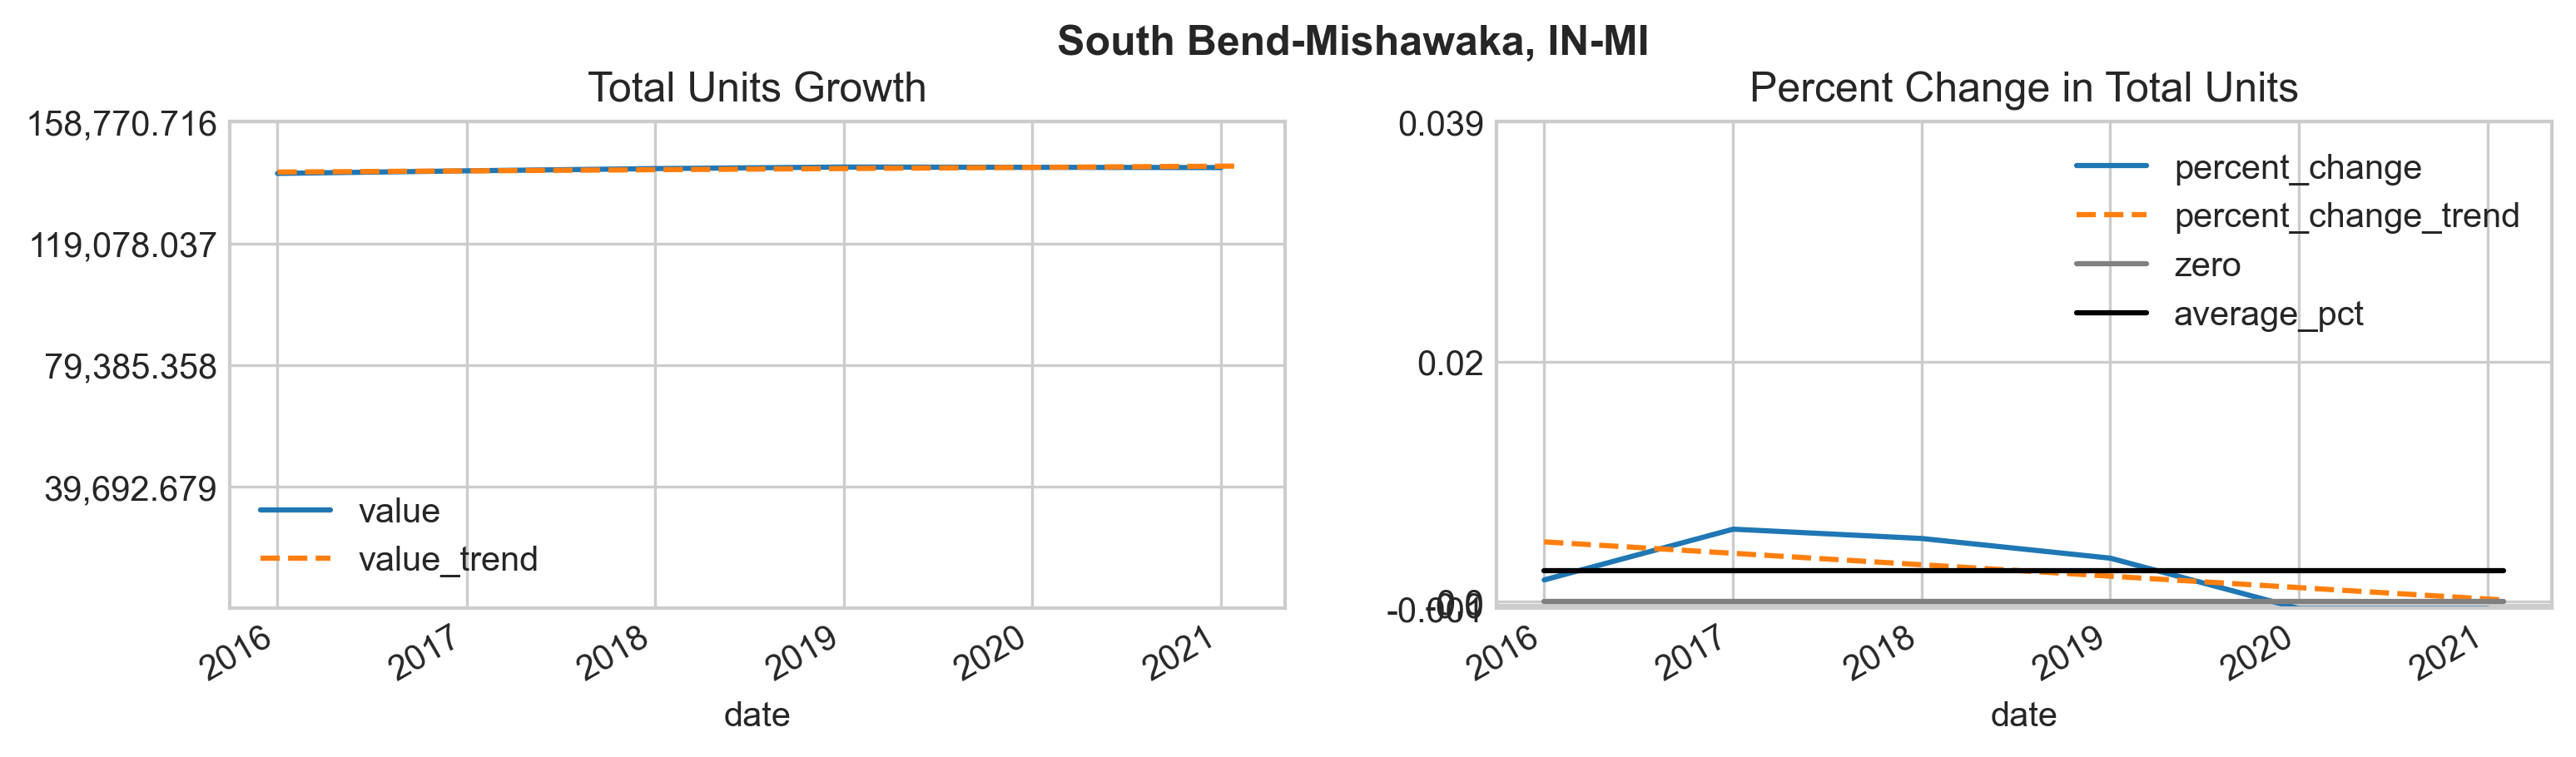

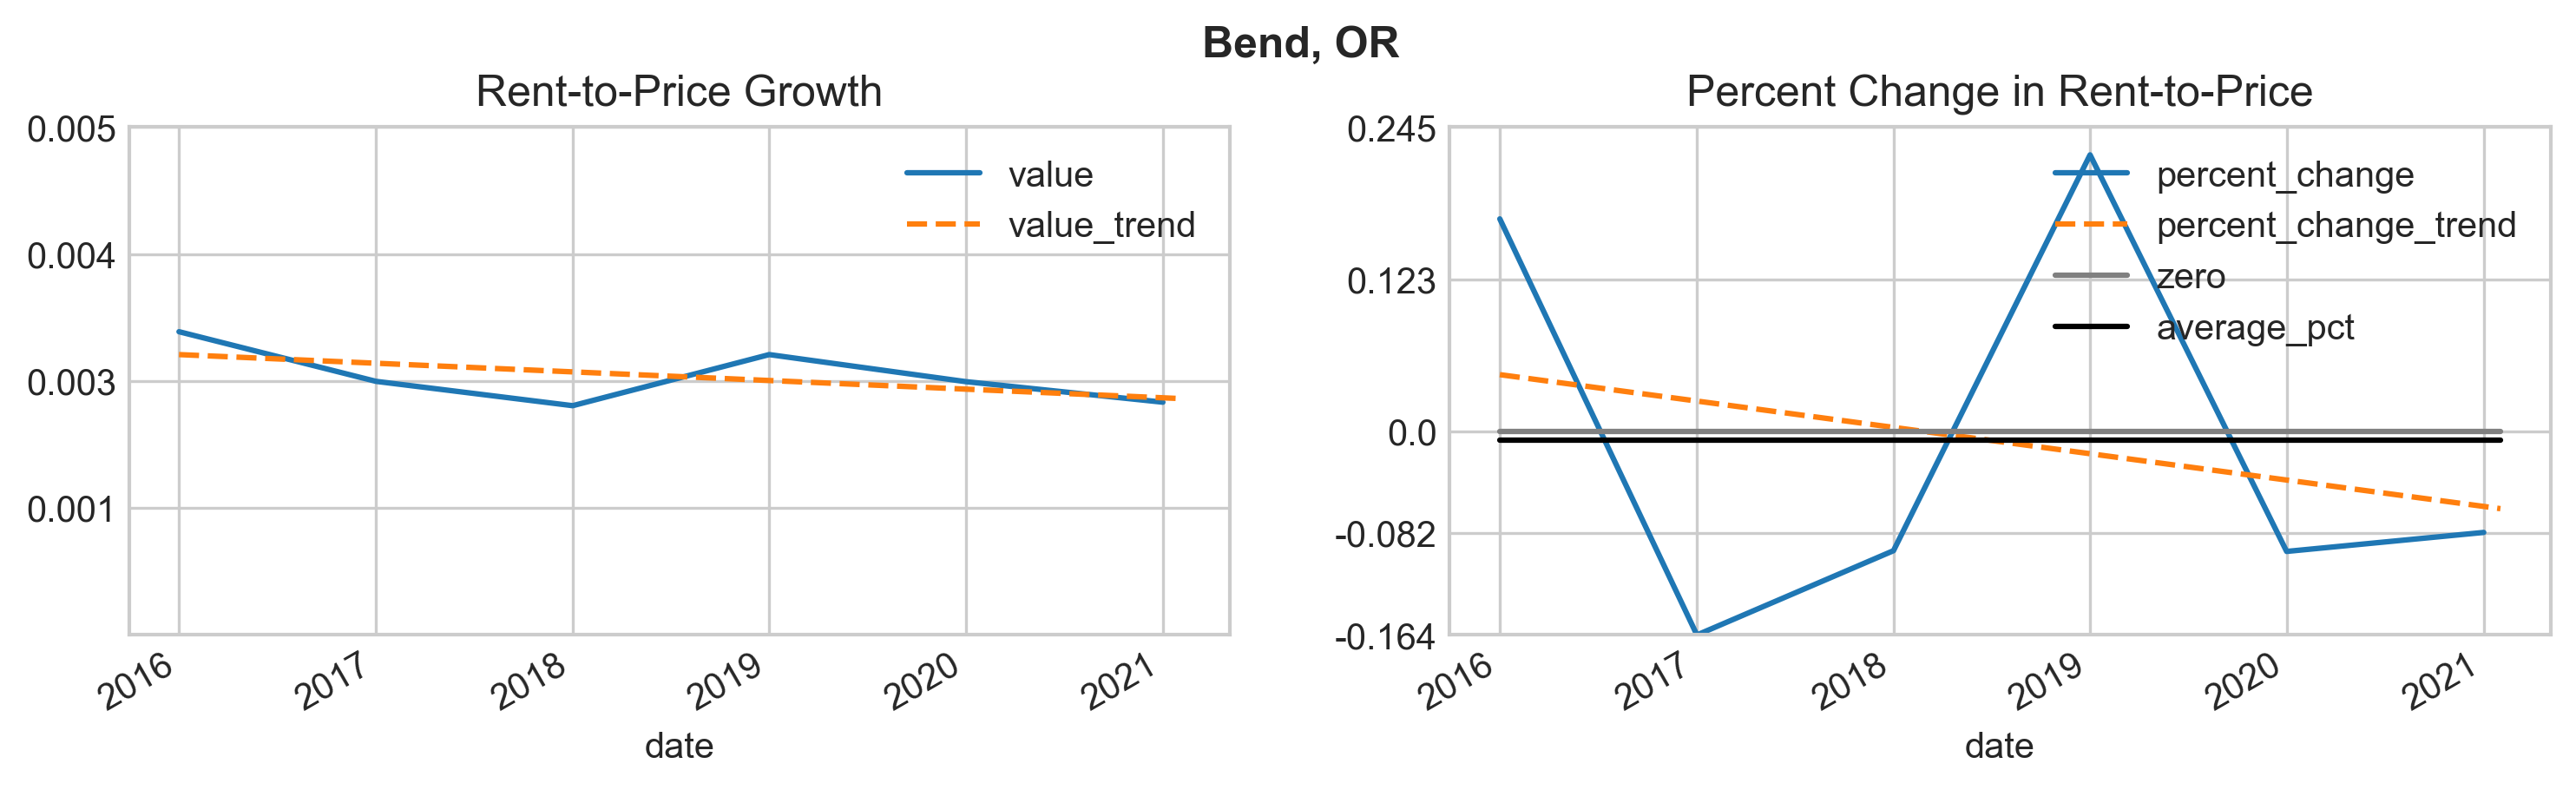

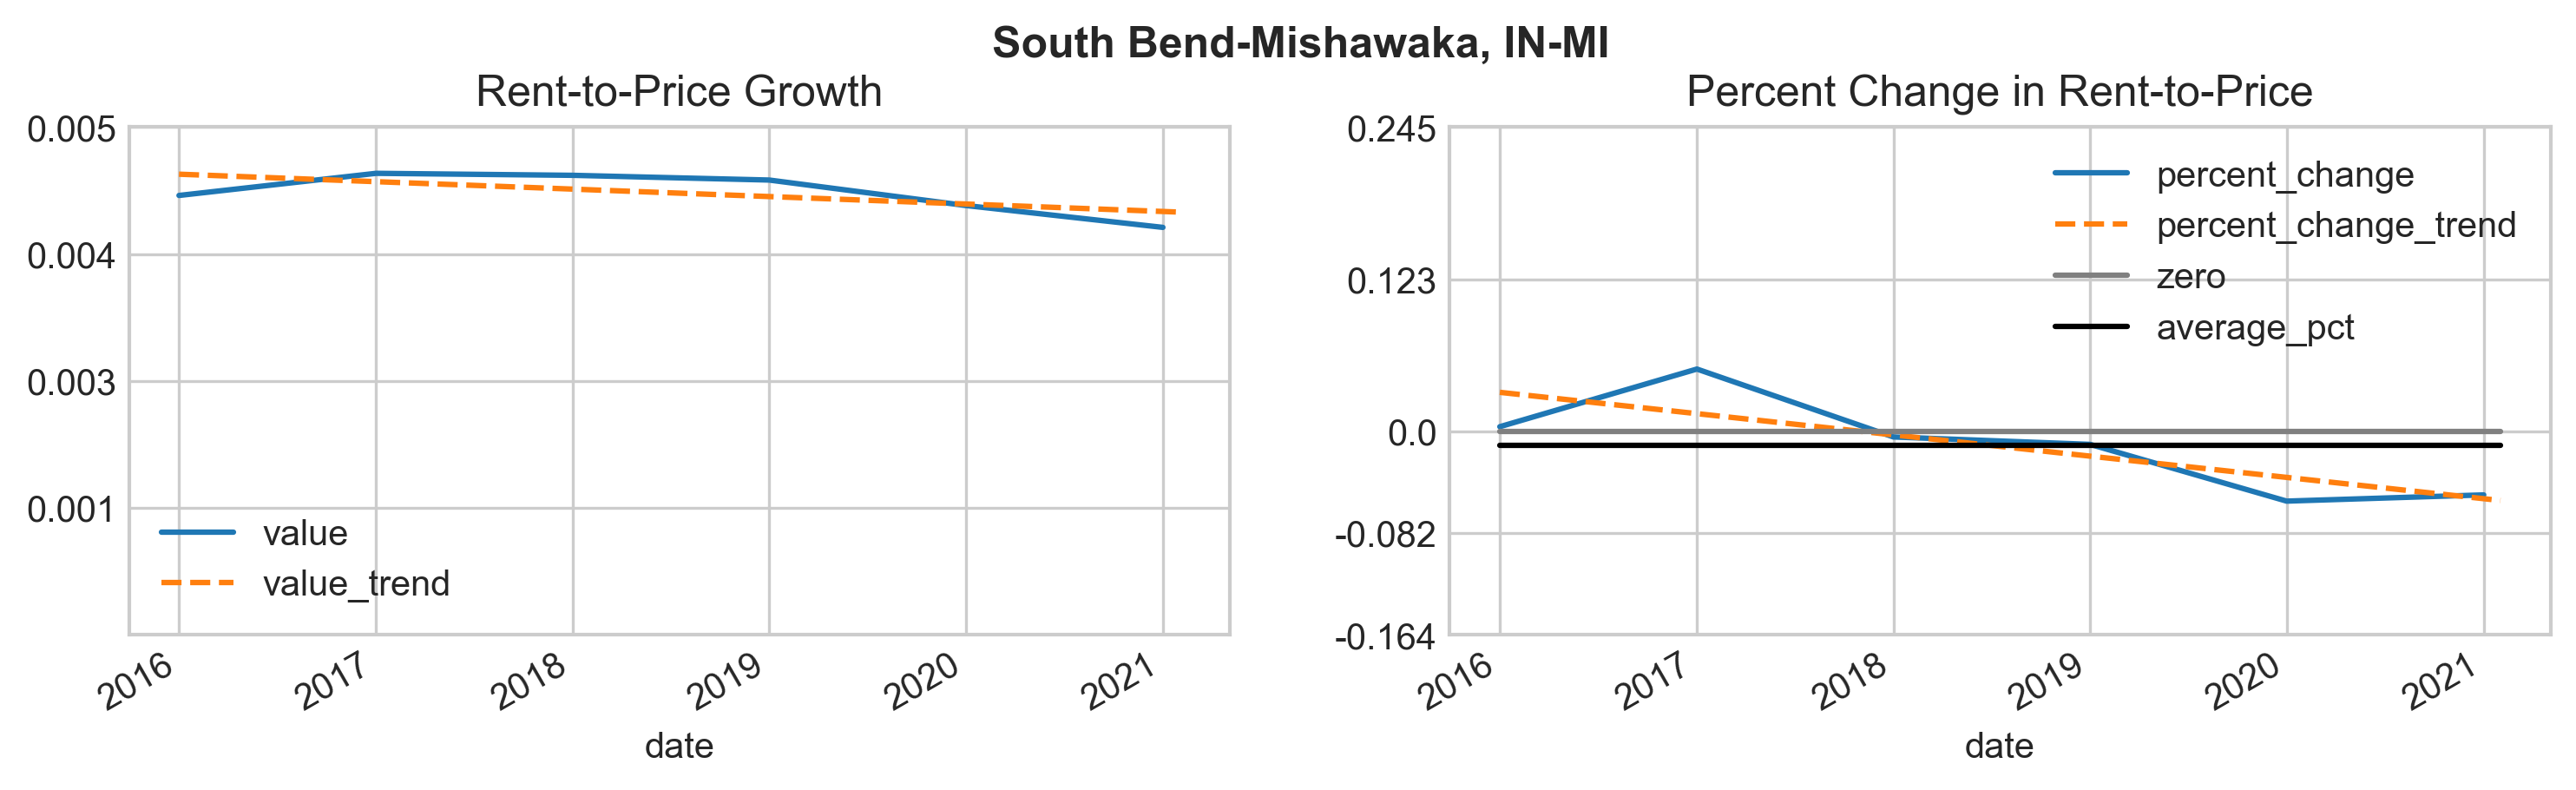

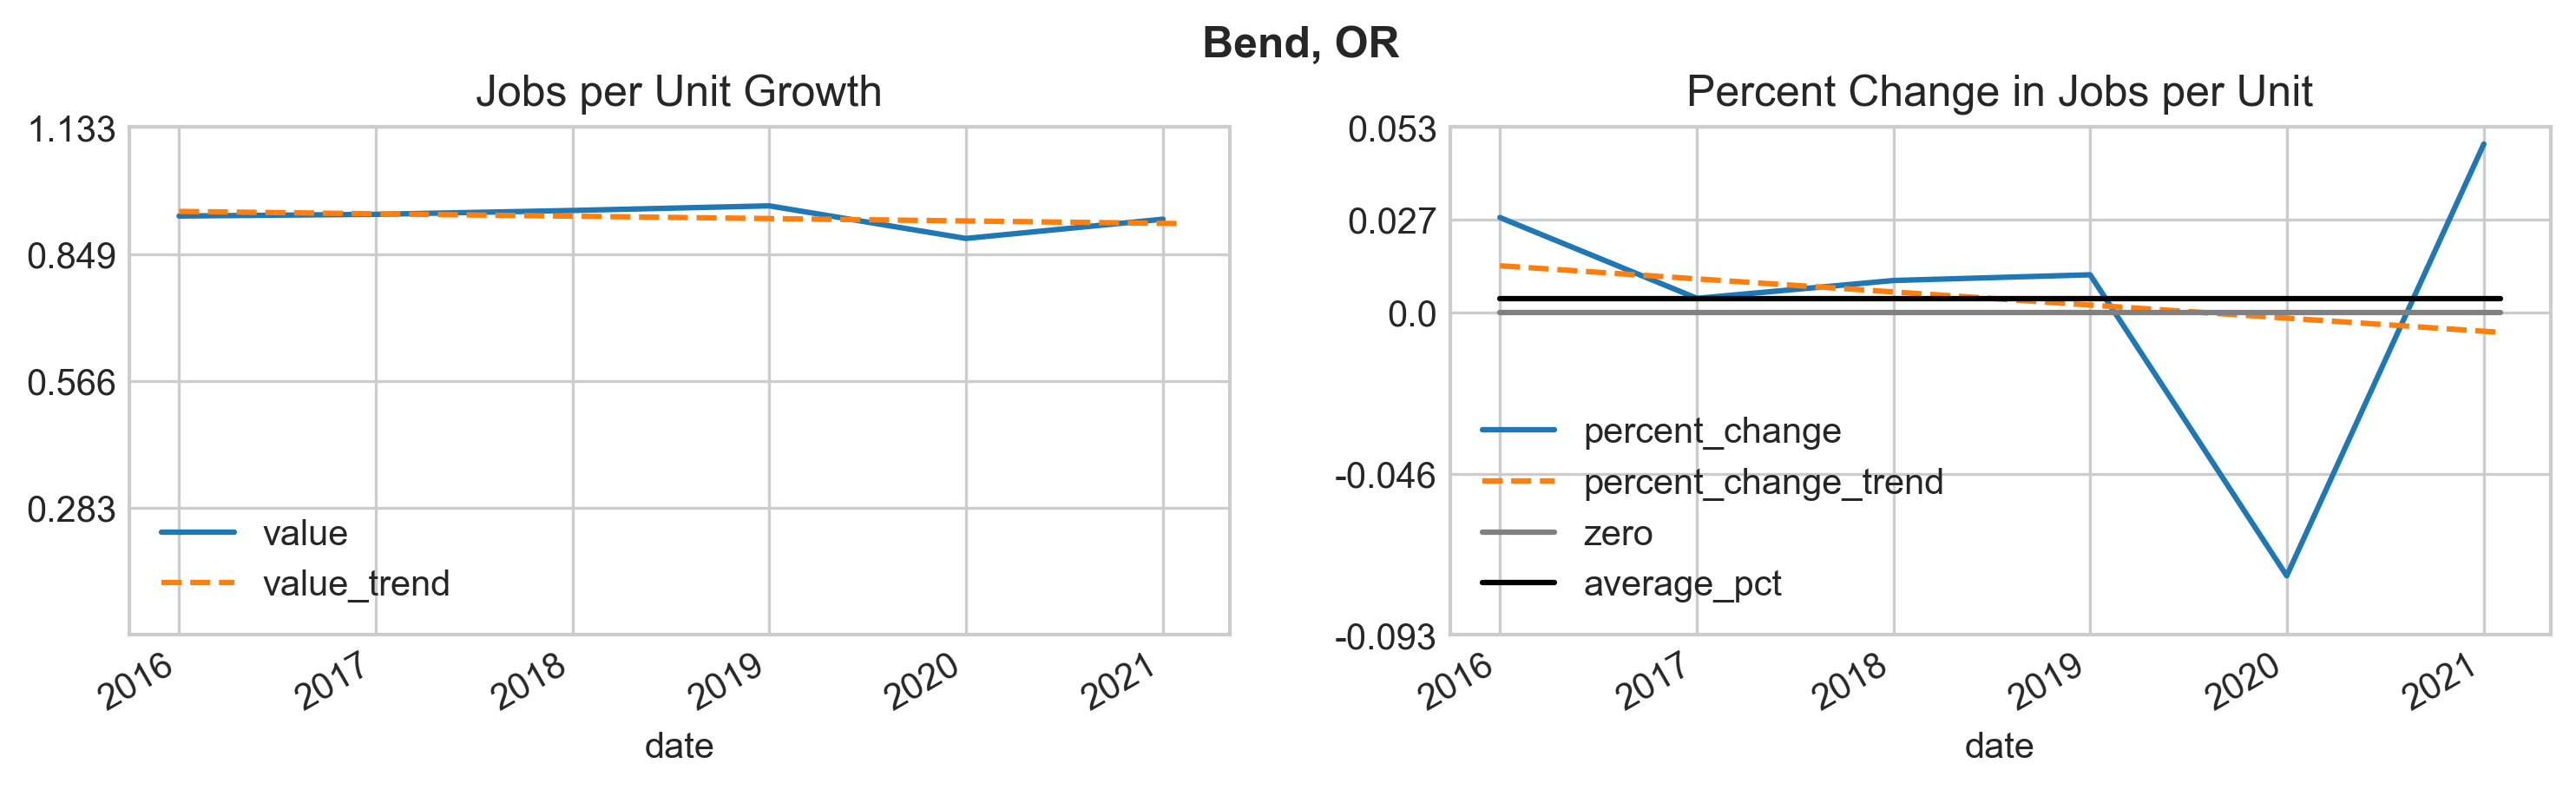

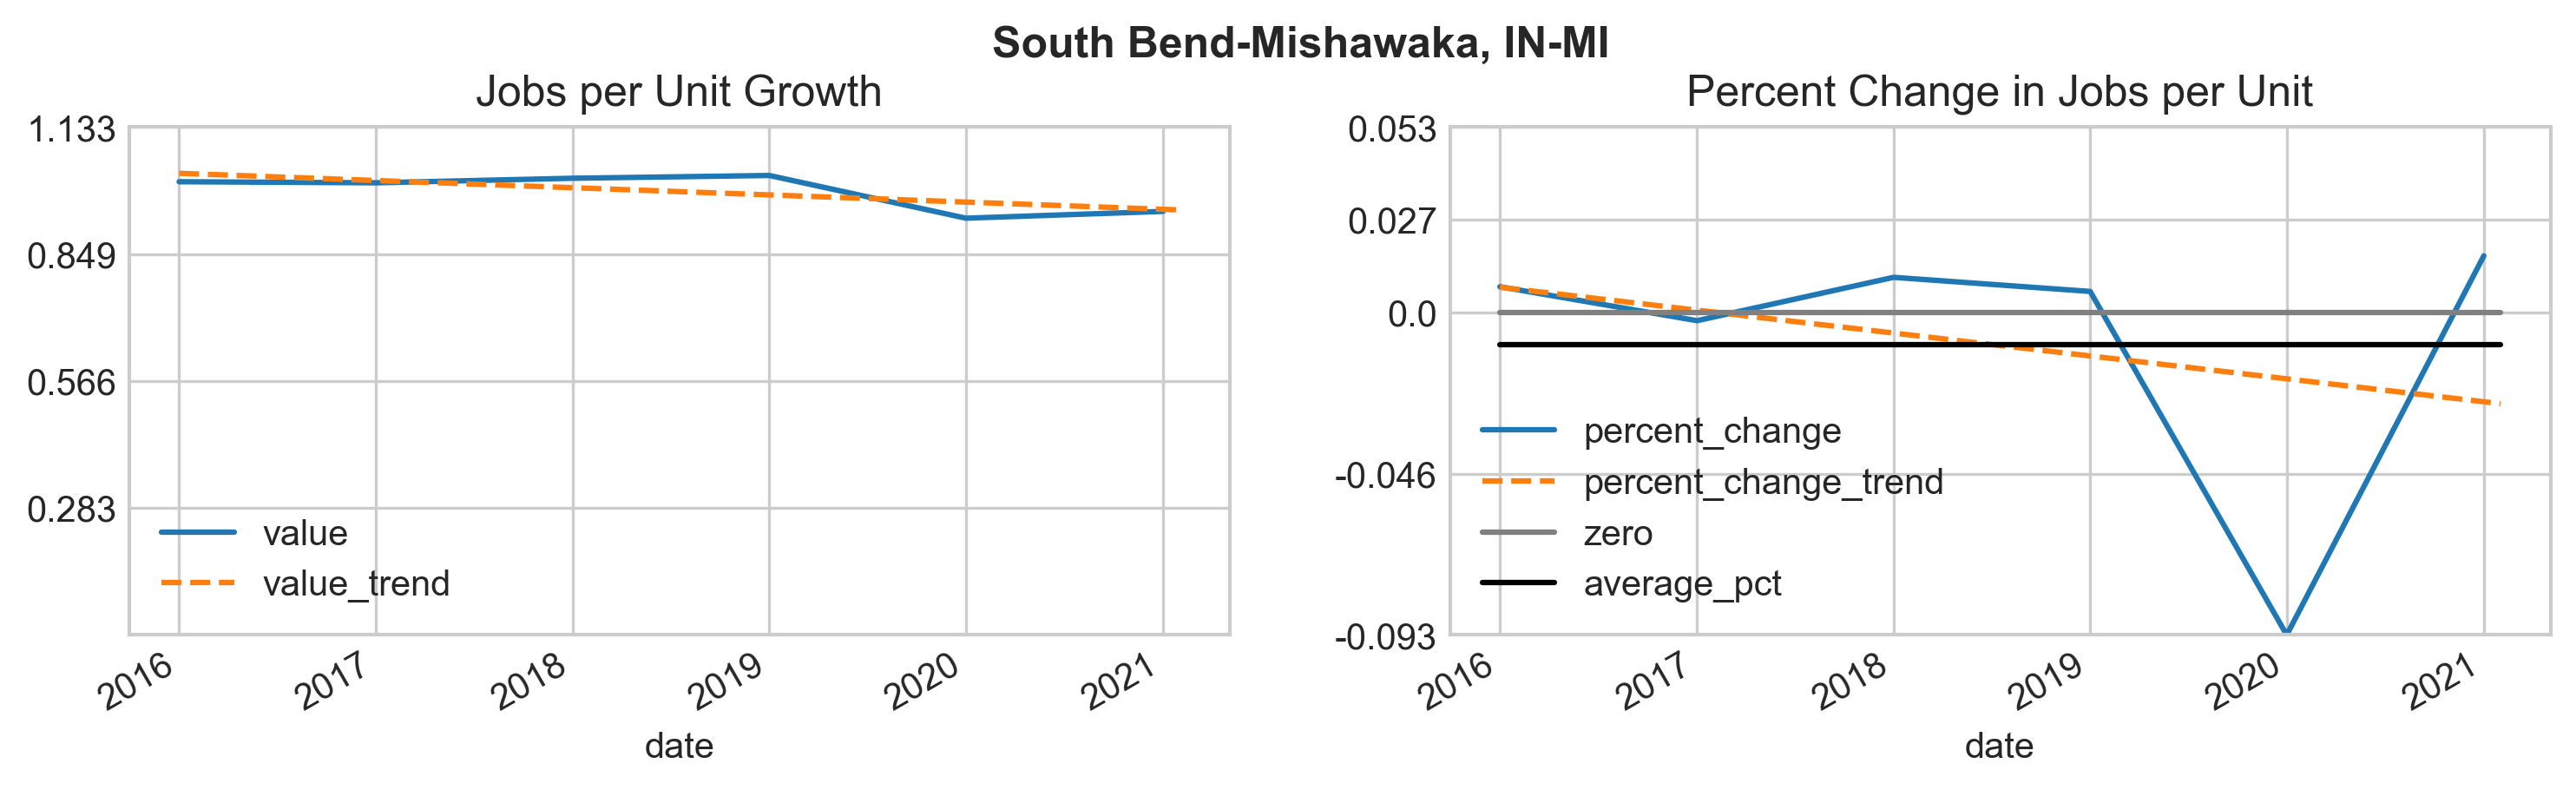

In [171]:
plot_every_demographic(specific_city)

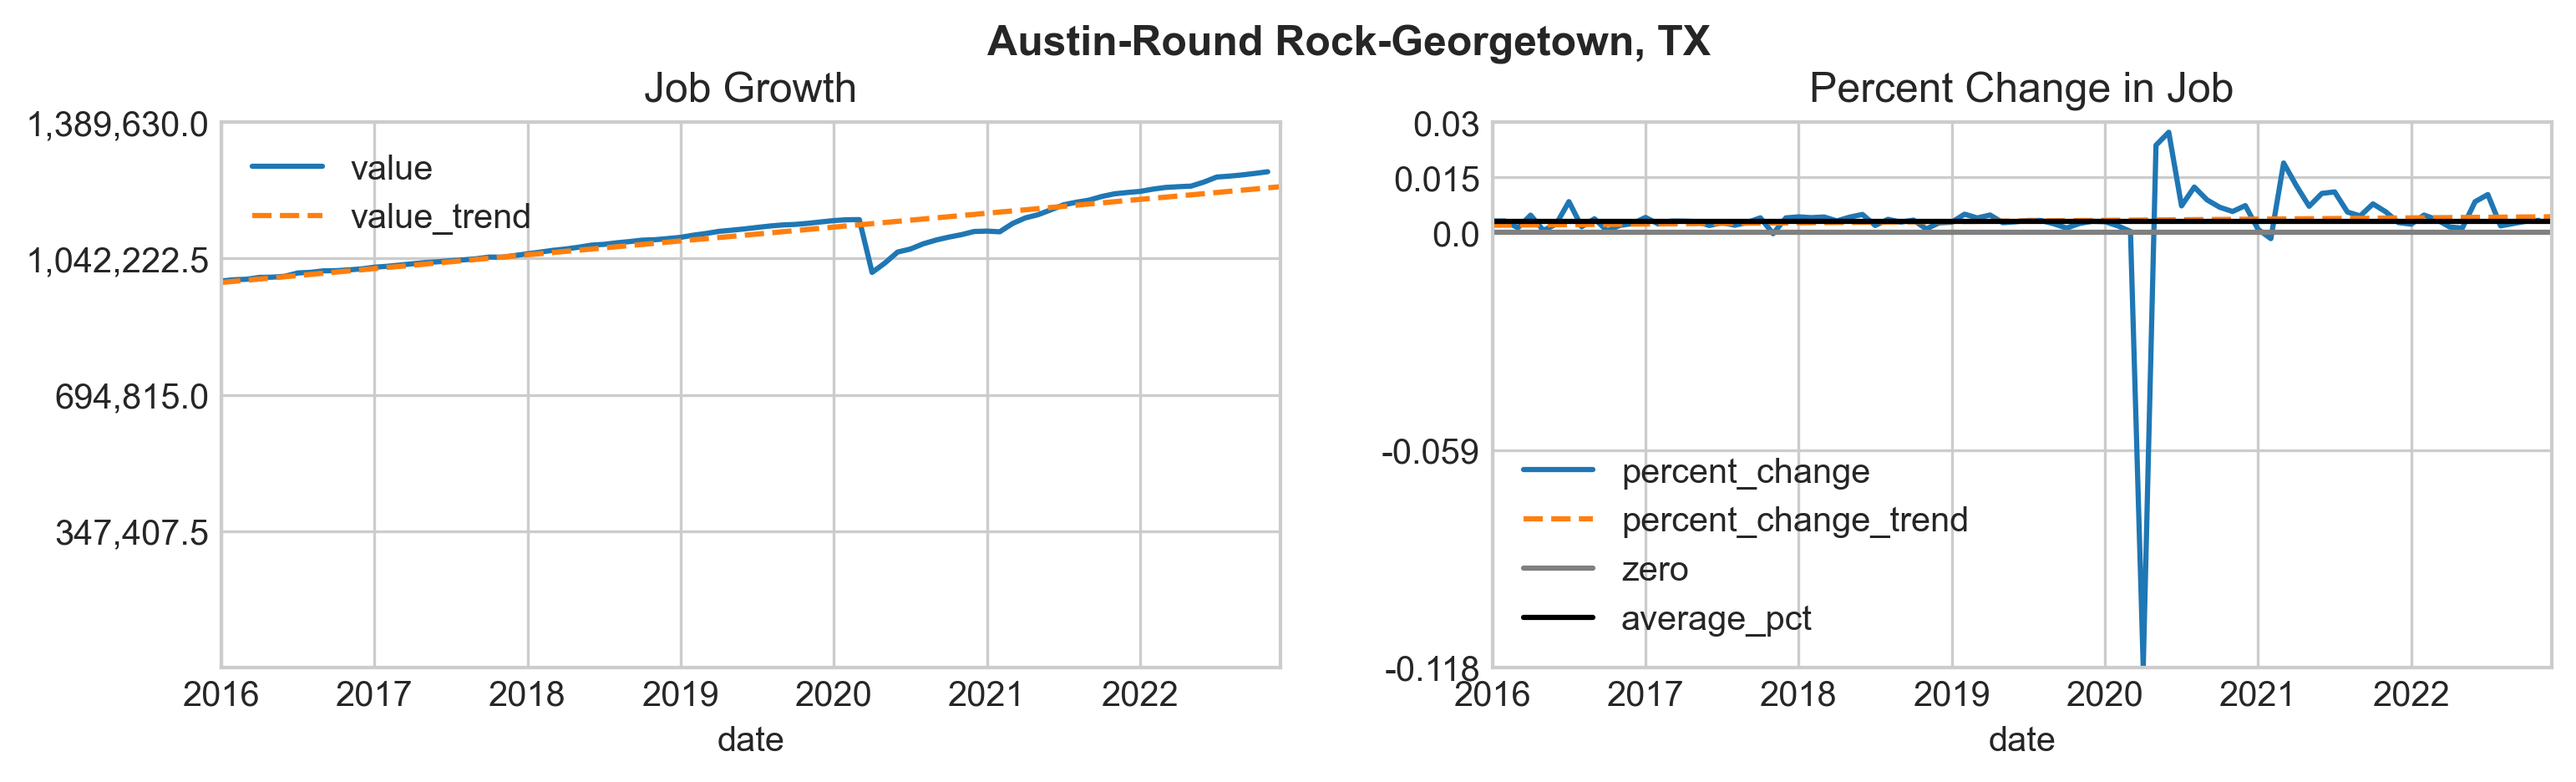

In [104]:
plot_top_10_cities(
    ranked_cities=specific_city,
    plot_jobs=True,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    begin_year_1=2016, 
)

KeyboardInterrupt: 

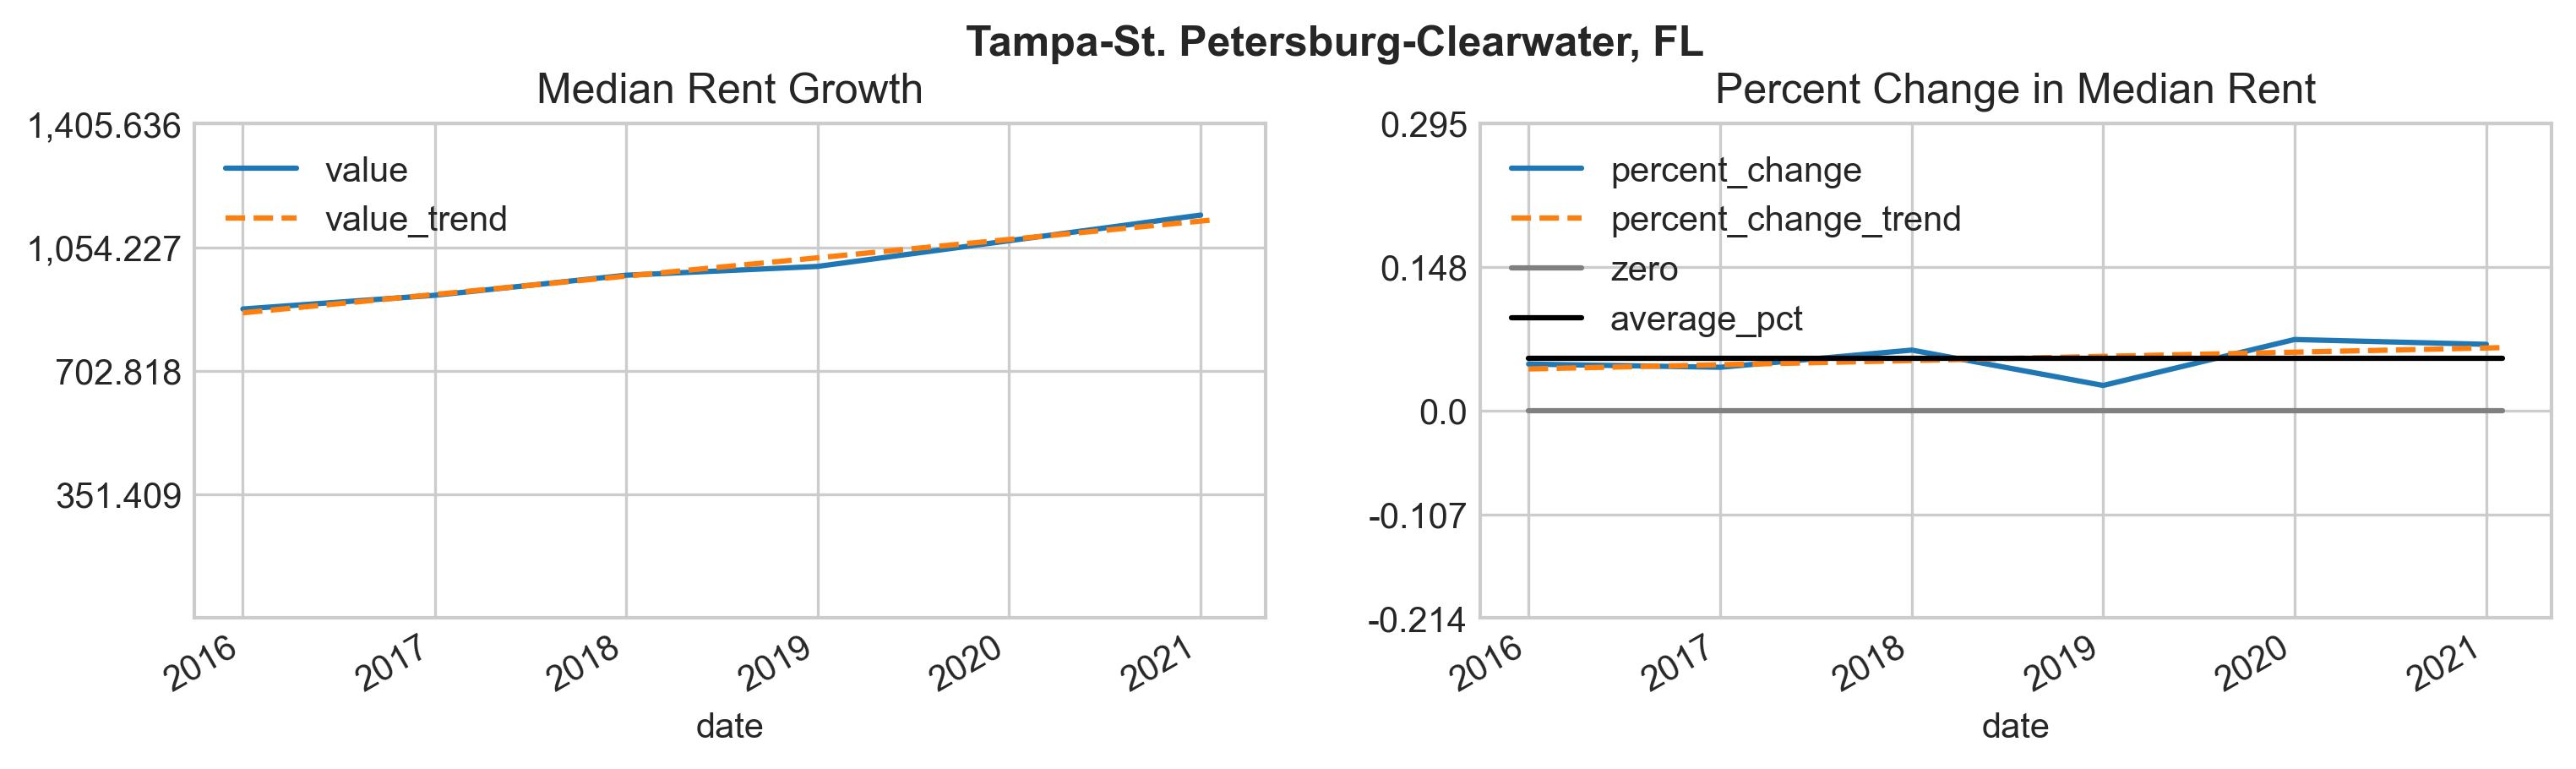

In [23]:
### PLOT EVERY GRAPH FOR EVERY CITY
### WARNING: THIS WILL TAKE A LONG TIME!
# plot_every_demographic(rank_all, plot_all=True)